In [1]:
#Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C:\Users\annek\AppData\Local\Temp\ipykernel_6024\803360209.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


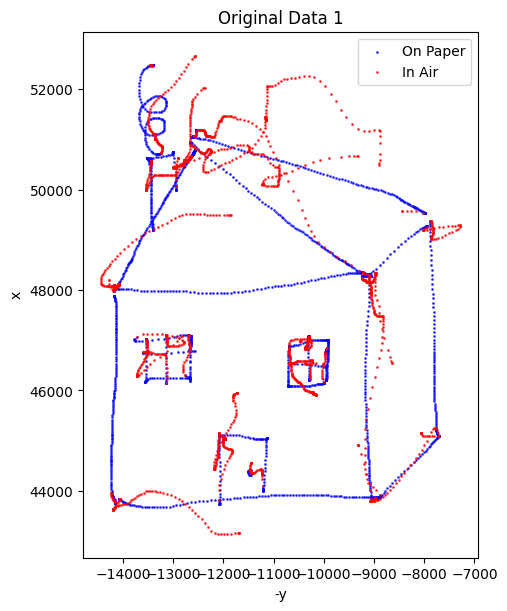

Processed data shape: (3681, 3)
Average number of data points: 3681


In [21]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points


directory = 'Task2'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")

In [22]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(3,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(3, activation='sigmoid')
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy = decoded[:, :2]
        pen_status = tf.round(decoded[:, 2])
        return tf.concat([xy, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Function to compute loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x[:, :2], x_reconstructed[:, :2]))
    pen_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 2], x_reconstructed[:, 2]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss + pen_loss, kl_loss, model.beta * kl_loss

latent_dim = 256
beta = 0.0001
# beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/1000:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 1/1000: 100%|██████████| 15/15 [00:05<00:00,  2.81batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=1.54]


Epoch 1: Total Loss = 7.579130, Reconstruction Loss = 7.578975, KL Divergence Loss = 1.544896
MAE = 0.317369, MSE = 0.144992, NRMSE = 0.380778


Epoch 2/1000: 100%|██████████| 15/15 [00:00<00:00, 50.42batch/s, Total Loss=6.41, Reconstruction Loss=6.41, KL Loss=1.53]


Epoch 2: Total Loss = 7.532801, Reconstruction Loss = 7.532647, KL Divergence Loss = 1.540934
MAE = 0.317565, MSE = 0.145506, NRMSE = 0.381453


Epoch 3/1000: 100%|██████████| 15/15 [00:00<00:00, 67.51batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.55]


Epoch 3: Total Loss = 7.593879, Reconstruction Loss = 7.593726, KL Divergence Loss = 1.536258
MAE = 0.317328, MSE = 0.145195, NRMSE = 0.381044


Epoch 4/1000: 100%|██████████| 15/15 [00:00<00:00, 67.92batch/s, Total Loss=6.9, Reconstruction Loss=6.9, KL Loss=1.49]  


Epoch 4: Total Loss = 7.548407, Reconstruction Loss = 7.548254, KL Divergence Loss = 1.531960
MAE = 0.317977, MSE = 0.145478, NRMSE = 0.381416


Epoch 5/1000: 100%|██████████| 15/15 [00:00<00:00, 69.61batch/s, Total Loss=8.05, Reconstruction Loss=8.05, KL Loss=1.53]


Epoch 5: Total Loss = 7.571042, Reconstruction Loss = 7.570889, KL Divergence Loss = 1.529260
MAE = 0.316223, MSE = 0.143851, NRMSE = 0.379277


Epoch 6/1000: 100%|██████████| 15/15 [00:00<00:00, 64.25batch/s, Total Loss=7.72, Reconstruction Loss=7.72, KL Loss=1.53]


Epoch 6: Total Loss = 7.532254, Reconstruction Loss = 7.532101, KL Divergence Loss = 1.521621
MAE = 0.316851, MSE = 0.144505, NRMSE = 0.380138


Epoch 7/1000: 100%|██████████| 15/15 [00:00<00:00, 69.41batch/s, Total Loss=6.58, Reconstruction Loss=6.58, KL Loss=1.49]


Epoch 7: Total Loss = 7.492919, Reconstruction Loss = 7.492768, KL Divergence Loss = 1.509565
MAE = 0.314856, MSE = 0.142715, NRMSE = 0.377776


Epoch 8/1000: 100%|██████████| 15/15 [00:00<00:00, 64.99batch/s, Total Loss=7.56, Reconstruction Loss=7.56, KL Loss=1.52]


Epoch 8: Total Loss = 7.558957, Reconstruction Loss = 7.558808, KL Divergence Loss = 1.489576
MAE = 0.315885, MSE = 0.144055, NRMSE = 0.379546


Epoch 9/1000: 100%|██████████| 15/15 [00:00<00:00, 57.15batch/s, Total Loss=7.56, Reconstruction Loss=7.56, KL Loss=1.43]


Epoch 9: Total Loss = 7.550719, Reconstruction Loss = 7.550571, KL Divergence Loss = 1.477341
MAE = 0.313964, MSE = 0.142578, NRMSE = 0.377595


Epoch 10/1000: 100%|██████████| 15/15 [00:00<00:00, 68.42batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=1.49]


Epoch 10: Total Loss = 7.617267, Reconstruction Loss = 7.617119, KL Divergence Loss = 1.482211
MAE = 0.315877, MSE = 0.143683, NRMSE = 0.379055


Epoch 11/1000: 100%|██████████| 15/15 [00:00<00:00, 62.81batch/s, Total Loss=6.57, Reconstruction Loss=6.57, KL Loss=1.48]


Epoch 11: Total Loss = 7.522426, Reconstruction Loss = 7.522277, KL Divergence Loss = 1.485667
MAE = 0.315313, MSE = 0.142916, NRMSE = 0.378042


Epoch 12/1000: 100%|██████████| 15/15 [00:00<00:00, 64.24batch/s, Total Loss=9.04, Reconstruction Loss=9.04, KL Loss=1.47]


Epoch 12: Total Loss = 7.641388, Reconstruction Loss = 7.641240, KL Divergence Loss = 1.486040
MAE = 0.315219, MSE = 0.143510, NRMSE = 0.378827


Epoch 13/1000: 100%|██████████| 15/15 [00:00<00:00, 52.99batch/s, Total Loss=7.72, Reconstruction Loss=7.72, KL Loss=1.49]


Epoch 13: Total Loss = 7.553132, Reconstruction Loss = 7.552982, KL Divergence Loss = 1.485982
MAE = 0.315698, MSE = 0.144036, NRMSE = 0.379521


Epoch 14/1000: 100%|██████████| 15/15 [00:00<00:00, 74.25batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=1.5] 


Epoch 14: Total Loss = 7.576198, Reconstruction Loss = 7.576050, KL Divergence Loss = 1.486331
MAE = 0.314968, MSE = 0.142716, NRMSE = 0.377778


Epoch 15/1000: 100%|██████████| 15/15 [00:00<00:00, 70.14batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=1.46]


Epoch 15: Total Loss = 7.496634, Reconstruction Loss = 7.496487, KL Divergence Loss = 1.481408
MAE = 0.312733, MSE = 0.141765, NRMSE = 0.376517


Epoch 16/1000: 100%|██████████| 15/15 [00:00<00:00, 62.99batch/s, Total Loss=9.04, Reconstruction Loss=9.04, KL Loss=1.46]


Epoch 16: Total Loss = 7.628524, Reconstruction Loss = 7.628376, KL Divergence Loss = 1.476830
MAE = 0.314922, MSE = 0.142788, NRMSE = 0.377873


Epoch 17/1000: 100%|██████████| 15/15 [00:00<00:00, 50.06batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.48]


Epoch 17: Total Loss = 7.585066, Reconstruction Loss = 7.584917, KL Divergence Loss = 1.474584
MAE = 0.314219, MSE = 0.142108, NRMSE = 0.376972


Epoch 18/1000: 100%|██████████| 15/15 [00:00<00:00, 64.03batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=1.48]


Epoch 18: Total Loss = 7.575671, Reconstruction Loss = 7.575524, KL Divergence Loss = 1.473023
MAE = 0.314393, MSE = 0.142685, NRMSE = 0.377737


Epoch 19/1000: 100%|██████████| 15/15 [00:00<00:00, 64.16batch/s, Total Loss=6.41, Reconstruction Loss=6.41, KL Loss=1.53]


Epoch 19: Total Loss = 7.494698, Reconstruction Loss = 7.494550, KL Divergence Loss = 1.472817
MAE = 0.314961, MSE = 0.142991, NRMSE = 0.378141


Epoch 20/1000: 100%|██████████| 15/15 [00:00<00:00, 55.89batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=1.45]


Epoch 20: Total Loss = 7.520700, Reconstruction Loss = 7.520554, KL Divergence Loss = 1.462144
MAE = 0.313640, MSE = 0.141993, NRMSE = 0.376819


Epoch 21/1000: 100%|██████████| 15/15 [00:00<00:00, 65.09batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.47]  


Epoch 21: Total Loss = 7.547872, Reconstruction Loss = 7.547727, KL Divergence Loss = 1.457322
MAE = 0.312867, MSE = 0.141315, NRMSE = 0.375918


Epoch 22/1000: 100%|██████████| 15/15 [00:00<00:00, 65.59batch/s, Total Loss=6.25, Reconstruction Loss=6.25, KL Loss=1.51]


Epoch 22: Total Loss = 7.491892, Reconstruction Loss = 7.491746, KL Divergence Loss = 1.459140
MAE = 0.312174, MSE = 0.140613, NRMSE = 0.374984


Epoch 23/1000: 100%|██████████| 15/15 [00:00<00:00, 67.67batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=1.5] 


Epoch 23: Total Loss = 7.557444, Reconstruction Loss = 7.557298, KL Divergence Loss = 1.452381
MAE = 0.313276, MSE = 0.141843, NRMSE = 0.376620


Epoch 24/1000: 100%|██████████| 15/15 [00:00<00:00, 44.48batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=1.43]


Epoch 24: Total Loss = 7.544745, Reconstruction Loss = 7.544601, KL Divergence Loss = 1.447773
MAE = 0.313252, MSE = 0.141700, NRMSE = 0.376430


Epoch 25/1000: 100%|██████████| 15/15 [00:00<00:00, 68.84batch/s, Total Loss=8.05, Reconstruction Loss=8.05, KL Loss=1.49]


Epoch 25: Total Loss = 7.516385, Reconstruction Loss = 7.516239, KL Divergence Loss = 1.446014
MAE = 0.313734, MSE = 0.141752, NRMSE = 0.376499


Epoch 26/1000: 100%|██████████| 15/15 [00:00<00:00, 64.39batch/s, Total Loss=8.71, Reconstruction Loss=8.71, KL Loss=1.44]


Epoch 26: Total Loss = 7.619274, Reconstruction Loss = 7.619131, KL Divergence Loss = 1.436652
MAE = 0.312763, MSE = 0.141093, NRMSE = 0.375624


Epoch 27/1000: 100%|██████████| 15/15 [00:00<00:00, 44.91batch/s, Total Loss=5.92, Reconstruction Loss=5.92, KL Loss=1.46]


Epoch 27: Total Loss = 7.499349, Reconstruction Loss = 7.499205, KL Divergence Loss = 1.430906
MAE = 0.312574, MSE = 0.141138, NRMSE = 0.375684


Epoch 28/1000: 100%|██████████| 15/15 [00:00<00:00, 68.64batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=1.4] 


Epoch 28: Total Loss = 7.558189, Reconstruction Loss = 7.558047, KL Divergence Loss = 1.424475
MAE = 0.311742, MSE = 0.140242, NRMSE = 0.374489


Epoch 29/1000: 100%|██████████| 15/15 [00:00<00:00, 65.51batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=1.38]


Epoch 29: Total Loss = 7.590804, Reconstruction Loss = 7.590662, KL Divergence Loss = 1.415204
MAE = 0.311091, MSE = 0.139768, NRMSE = 0.373855


Epoch 30/1000: 100%|██████████| 15/15 [00:00<00:00, 51.63batch/s, Total Loss=7.23, Reconstruction Loss=7.23, KL Loss=1.46]


Epoch 30: Total Loss = 7.578931, Reconstruction Loss = 7.578789, KL Divergence Loss = 1.415186
MAE = 0.312115, MSE = 0.140654, NRMSE = 0.375039


Epoch 31/1000: 100%|██████████| 15/15 [00:00<00:00, 66.13batch/s, Total Loss=7.23, Reconstruction Loss=7.23, KL Loss=1.38]


Epoch 31: Total Loss = 7.570572, Reconstruction Loss = 7.570430, KL Divergence Loss = 1.410873
MAE = 0.309749, MSE = 0.138772, NRMSE = 0.372522


Epoch 32/1000: 100%|██████████| 15/15 [00:00<00:00, 62.21batch/s, Total Loss=6.58, Reconstruction Loss=6.58, KL Loss=1.44]


Epoch 32: Total Loss = 7.526957, Reconstruction Loss = 7.526816, KL Divergence Loss = 1.410504
MAE = 0.311807, MSE = 0.140097, NRMSE = 0.374295


Epoch 33/1000: 100%|██████████| 15/15 [00:00<00:00, 44.52batch/s, Total Loss=8.38, Reconstruction Loss=8.38, KL Loss=1.4] 


Epoch 33: Total Loss = 7.614060, Reconstruction Loss = 7.613920, KL Divergence Loss = 1.407263
MAE = 0.311845, MSE = 0.140086, NRMSE = 0.374280


Epoch 34/1000: 100%|██████████| 15/15 [00:00<00:00, 48.80batch/s, Total Loss=6.58, Reconstruction Loss=6.58, KL Loss=1.41]


Epoch 34: Total Loss = 7.551607, Reconstruction Loss = 7.551467, KL Divergence Loss = 1.398927
MAE = 0.311186, MSE = 0.140144, NRMSE = 0.374358


Epoch 35/1000: 100%|██████████| 15/15 [00:00<00:00, 73.51batch/s, Total Loss=7.72, Reconstruction Loss=7.72, KL Loss=1.42]


Epoch 35: Total Loss = 7.586523, Reconstruction Loss = 7.586384, KL Divergence Loss = 1.393473
MAE = 0.311259, MSE = 0.139698, NRMSE = 0.373761


Epoch 36/1000: 100%|██████████| 15/15 [00:00<00:00, 73.11batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.37]  


Epoch 36: Total Loss = 7.577371, Reconstruction Loss = 7.577232, KL Divergence Loss = 1.390283
MAE = 0.309685, MSE = 0.138263, NRMSE = 0.371838


Epoch 37/1000: 100%|██████████| 15/15 [00:00<00:00, 34.19batch/s, Total Loss=6.57, Reconstruction Loss=6.57, KL Loss=1.38]


Epoch 37: Total Loss = 7.484366, Reconstruction Loss = 7.484228, KL Divergence Loss = 1.387927
MAE = 0.308988, MSE = 0.138124, NRMSE = 0.371651


Epoch 38/1000: 100%|██████████| 15/15 [00:00<00:00, 64.75batch/s, Total Loss=8.22, Reconstruction Loss=8.22, KL Loss=1.43]


Epoch 38: Total Loss = 7.556709, Reconstruction Loss = 7.556571, KL Divergence Loss = 1.383221
MAE = 0.310945, MSE = 0.139416, NRMSE = 0.373384


Epoch 39/1000: 100%|██████████| 15/15 [00:00<00:00, 71.51batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=1.38]


Epoch 39: Total Loss = 7.559428, Reconstruction Loss = 7.559289, KL Divergence Loss = 1.379282
MAE = 0.309547, MSE = 0.138373, NRMSE = 0.371985


Epoch 40/1000: 100%|██████████| 15/15 [00:00<00:00, 52.58batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=1.39]


Epoch 40: Total Loss = 7.592266, Reconstruction Loss = 7.592127, KL Divergence Loss = 1.379697
MAE = 0.311173, MSE = 0.139797, NRMSE = 0.373895


Epoch 41/1000: 100%|██████████| 15/15 [00:00<00:00, 61.56batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=1.41]


Epoch 41: Total Loss = 7.524653, Reconstruction Loss = 7.524516, KL Divergence Loss = 1.376744
MAE = 0.310326, MSE = 0.139266, NRMSE = 0.373183


Epoch 42/1000: 100%|██████████| 15/15 [00:00<00:00, 71.03batch/s, Total Loss=9.04, Reconstruction Loss=9.04, KL Loss=1.38]


Epoch 42: Total Loss = 7.611712, Reconstruction Loss = 7.611576, KL Divergence Loss = 1.370686
MAE = 0.309830, MSE = 0.138389, NRMSE = 0.372006


Epoch 43/1000: 100%|██████████| 15/15 [00:00<00:00, 59.93batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=1.34]


Epoch 43: Total Loss = 7.499594, Reconstruction Loss = 7.499458, KL Divergence Loss = 1.363619
MAE = 0.310837, MSE = 0.139569, NRMSE = 0.373589


Epoch 44/1000: 100%|██████████| 15/15 [00:00<00:00, 59.34batch/s, Total Loss=6.9, Reconstruction Loss=6.9, KL Loss=1.38]  


Epoch 44: Total Loss = 7.527344, Reconstruction Loss = 7.527207, KL Divergence Loss = 1.361163
MAE = 0.309384, MSE = 0.137684, NRMSE = 0.371058


Epoch 45/1000: 100%|██████████| 15/15 [00:00<00:00, 60.05batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=1.35]


Epoch 45: Total Loss = 7.524599, Reconstruction Loss = 7.524463, KL Divergence Loss = 1.354617
MAE = 0.308886, MSE = 0.137632, NRMSE = 0.370988


Epoch 46/1000: 100%|██████████| 15/15 [00:00<00:00, 40.30batch/s, Total Loss=7.72, Reconstruction Loss=7.72, KL Loss=1.33]


Epoch 46: Total Loss = 7.552893, Reconstruction Loss = 7.552759, KL Divergence Loss = 1.346083
MAE = 0.308601, MSE = 0.137430, NRMSE = 0.370716


Epoch 47/1000: 100%|██████████| 15/15 [00:00<00:00, 44.50batch/s, Total Loss=7.23, Reconstruction Loss=7.23, KL Loss=1.34]


Epoch 47: Total Loss = 7.540925, Reconstruction Loss = 7.540792, KL Divergence Loss = 1.340641
MAE = 0.309740, MSE = 0.138402, NRMSE = 0.372024


Epoch 48/1000: 100%|██████████| 15/15 [00:00<00:00, 53.71batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=1.3] 


Epoch 48: Total Loss = 7.509096, Reconstruction Loss = 7.508963, KL Divergence Loss = 1.336336
MAE = 0.308200, MSE = 0.137076, NRMSE = 0.370238


Epoch 49/1000: 100%|██████████| 15/15 [00:00<00:00, 63.13batch/s, Total Loss=6.25, Reconstruction Loss=6.25, KL Loss=1.31]


Epoch 49: Total Loss = 7.483363, Reconstruction Loss = 7.483230, KL Divergence Loss = 1.338687
MAE = 0.308993, MSE = 0.138151, NRMSE = 0.371687


Epoch 50/1000: 100%|██████████| 15/15 [00:00<00:00, 49.09batch/s, Total Loss=7.72, Reconstruction Loss=7.72, KL Loss=1.34]


Epoch 50: Total Loss = 7.565577, Reconstruction Loss = 7.565443, KL Divergence Loss = 1.341324
MAE = 0.308649, MSE = 0.137476, NRMSE = 0.370777


Epoch 51/1000: 100%|██████████| 15/15 [00:00<00:00, 63.60batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=1.3] 


Epoch 51: Total Loss = 7.513324, Reconstruction Loss = 7.513192, KL Divergence Loss = 1.330147
MAE = 0.307566, MSE = 0.136733, NRMSE = 0.369775


Epoch 52/1000: 100%|██████████| 15/15 [00:00<00:00, 44.80batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.31]  


Epoch 52: Total Loss = 7.568905, Reconstruction Loss = 7.568773, KL Divergence Loss = 1.323544
MAE = 0.306404, MSE = 0.135639, NRMSE = 0.368292


Epoch 53/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.72, Reconstruction Loss=7.72, KL Loss=1.29]


Epoch 53: Total Loss = 7.557125, Reconstruction Loss = 7.556992, KL Divergence Loss = 1.324754
MAE = 0.309290, MSE = 0.137778, NRMSE = 0.371184


Epoch 54/1000: 100%|██████████| 15/15 [00:00<00:00, 50.67batch/s, Total Loss=6.25, Reconstruction Loss=6.25, KL Loss=1.34]


Epoch 54: Total Loss = 7.495858, Reconstruction Loss = 7.495726, KL Divergence Loss = 1.327860
MAE = 0.308159, MSE = 0.137099, NRMSE = 0.370269


Epoch 55/1000: 100%|██████████| 15/15 [00:00<00:00, 63.98batch/s, Total Loss=7.23, Reconstruction Loss=7.23, KL Loss=1.31]


Epoch 55: Total Loss = 7.519891, Reconstruction Loss = 7.519759, KL Divergence Loss = 1.319017
MAE = 0.307293, MSE = 0.136439, NRMSE = 0.369377


Epoch 56/1000: 100%|██████████| 15/15 [00:00<00:00, 68.67batch/s, Total Loss=6.25, Reconstruction Loss=6.25, KL Loss=1.37]


Epoch 56: Total Loss = 7.495746, Reconstruction Loss = 7.495615, KL Divergence Loss = 1.313131
MAE = 0.307776, MSE = 0.136558, NRMSE = 0.369537


Epoch 57/1000: 100%|██████████| 15/15 [00:00<00:00, 45.66batch/s, Total Loss=8.05, Reconstruction Loss=8.05, KL Loss=1.32]


Epoch 57: Total Loss = 7.545463, Reconstruction Loss = 7.545331, KL Divergence Loss = 1.310766
MAE = 0.306801, MSE = 0.135713, NRMSE = 0.368392


Epoch 58/1000: 100%|██████████| 15/15 [00:00<00:00, 56.32batch/s, Total Loss=8.71, Reconstruction Loss=8.71, KL Loss=1.27]


Epoch 58: Total Loss = 7.572661, Reconstruction Loss = 7.572530, KL Divergence Loss = 1.306529
MAE = 0.307151, MSE = 0.136716, NRMSE = 0.369752


Epoch 59/1000: 100%|██████████| 15/15 [00:00<00:00, 50.45batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=1.27]


Epoch 59: Total Loss = 7.574965, Reconstruction Loss = 7.574835, KL Divergence Loss = 1.303137
MAE = 0.306029, MSE = 0.135433, NRMSE = 0.368013


Epoch 60/1000: 100%|██████████| 15/15 [00:00<00:00, 26.66batch/s, Total Loss=9.21, Reconstruction Loss=9.21, KL Loss=1.28]


Epoch 60: Total Loss = 7.639482, Reconstruction Loss = 7.639352, KL Divergence Loss = 1.298573
MAE = 0.307230, MSE = 0.135800, NRMSE = 0.368510


Epoch 61/1000: 100%|██████████| 15/15 [00:00<00:00, 31.93batch/s, Total Loss=6.41, Reconstruction Loss=6.41, KL Loss=1.3] 


Epoch 61: Total Loss = 7.527911, Reconstruction Loss = 7.527781, KL Divergence Loss = 1.299008
MAE = 0.307464, MSE = 0.136411, NRMSE = 0.369338


Epoch 62/1000: 100%|██████████| 15/15 [00:00<00:00, 53.36batch/s, Total Loss=9.04, Reconstruction Loss=9.04, KL Loss=1.34]


Epoch 62: Total Loss = 7.653851, Reconstruction Loss = 7.653720, KL Divergence Loss = 1.300785
MAE = 0.307526, MSE = 0.136139, NRMSE = 0.368970


Epoch 63/1000: 100%|██████████| 15/15 [00:00<00:00, 63.98batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.3] 


Epoch 63: Total Loss = 7.585011, Reconstruction Loss = 7.584882, KL Divergence Loss = 1.296134
MAE = 0.305705, MSE = 0.134823, NRMSE = 0.367182


Epoch 64/1000: 100%|██████████| 15/15 [00:00<00:00, 68.46batch/s, Total Loss=7.72, Reconstruction Loss=7.72, KL Loss=1.27]


Epoch 64: Total Loss = 7.582517, Reconstruction Loss = 7.582387, KL Divergence Loss = 1.291138
MAE = 0.306576, MSE = 0.135553, NRMSE = 0.368175


Epoch 65/1000: 100%|██████████| 15/15 [00:00<00:00, 56.48batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=1.26]


Epoch 65: Total Loss = 7.527882, Reconstruction Loss = 7.527754, KL Divergence Loss = 1.279106
MAE = 0.305152, MSE = 0.134462, NRMSE = 0.366691


Epoch 66/1000: 100%|██████████| 15/15 [00:00<00:00, 60.22batch/s, Total Loss=9.04, Reconstruction Loss=9.04, KL Loss=1.29]


Epoch 66: Total Loss = 7.657994, Reconstruction Loss = 7.657865, KL Divergence Loss = 1.275289
MAE = 0.306493, MSE = 0.135760, NRMSE = 0.368456


Epoch 67/1000: 100%|██████████| 15/15 [00:00<00:00, 41.66batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.25]  


Epoch 67: Total Loss = 7.585857, Reconstruction Loss = 7.585730, KL Divergence Loss = 1.269071
MAE = 0.305544, MSE = 0.134216, NRMSE = 0.366355


Epoch 68/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=7.23, Reconstruction Loss=7.23, KL Loss=1.31]


Epoch 68: Total Loss = 7.591569, Reconstruction Loss = 7.591442, KL Divergence Loss = 1.271256
MAE = 0.305587, MSE = 0.134627, NRMSE = 0.366915


Epoch 69/1000: 100%|██████████| 15/15 [00:00<00:00, 46.12batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.25]


Epoch 69: Total Loss = 7.610214, Reconstruction Loss = 7.610086, KL Divergence Loss = 1.268379
MAE = 0.304176, MSE = 0.133606, NRMSE = 0.365521


Epoch 70/1000: 100%|██████████| 15/15 [00:00<00:00, 43.58batch/s, Total Loss=6.9, Reconstruction Loss=6.9, KL Loss=1.22]  


Epoch 70: Total Loss = 7.603038, Reconstruction Loss = 7.602913, KL Divergence Loss = 1.256559
MAE = 0.303698, MSE = 0.133183, NRMSE = 0.364942


Epoch 71/1000: 100%|██████████| 15/15 [00:00<00:00, 55.05batch/s, Total Loss=6.08, Reconstruction Loss=6.08, KL Loss=1.27]


Epoch 71: Total Loss = 7.514457, Reconstruction Loss = 7.514331, KL Divergence Loss = 1.256746
MAE = 0.304312, MSE = 0.134351, NRMSE = 0.366539


Epoch 72/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.22, Reconstruction Loss=8.22, KL Loss=1.21]


Epoch 72: Total Loss = 7.640836, Reconstruction Loss = 7.640710, KL Divergence Loss = 1.251766
MAE = 0.304894, MSE = 0.134209, NRMSE = 0.366345


Epoch 73/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=7.23, Reconstruction Loss=7.23, KL Loss=1.23]


Epoch 73: Total Loss = 7.612647, Reconstruction Loss = 7.612523, KL Divergence Loss = 1.241973
MAE = 0.302849, MSE = 0.132710, NRMSE = 0.364294


Epoch 74/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.22, Reconstruction Loss=8.22, KL Loss=1.24]


Epoch 74: Total Loss = 7.623950, Reconstruction Loss = 7.623826, KL Divergence Loss = 1.239170
MAE = 0.305725, MSE = 0.134678, NRMSE = 0.366985


Epoch 75/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.25]


Epoch 75: Total Loss = 7.584861, Reconstruction Loss = 7.584737, KL Divergence Loss = 1.241201
MAE = 0.304187, MSE = 0.133151, NRMSE = 0.364898


Epoch 76/1000: 100%|██████████| 15/15 [00:00<00:00, 68.48batch/s, Total Loss=6.08, Reconstruction Loss=6.08, KL Loss=1.26]


Epoch 76: Total Loss = 7.527123, Reconstruction Loss = 7.527000, KL Divergence Loss = 1.245472
MAE = 0.303899, MSE = 0.133313, NRMSE = 0.365120


Epoch 77/1000: 100%|██████████| 15/15 [00:00<00:00, 44.81batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.26]  


Epoch 77: Total Loss = 7.560426, Reconstruction Loss = 7.560302, KL Divergence Loss = 1.245331
MAE = 0.304248, MSE = 0.133400, NRMSE = 0.365239


Epoch 78/1000: 100%|██████████| 15/15 [00:00<00:00, 63.92batch/s, Total Loss=6.58, Reconstruction Loss=6.58, KL Loss=1.25]


Epoch 78: Total Loss = 7.551651, Reconstruction Loss = 7.551526, KL Divergence Loss = 1.243551
MAE = 0.304507, MSE = 0.133958, NRMSE = 0.366003


Epoch 79/1000: 100%|██████████| 15/15 [00:00<00:00, 59.77batch/s, Total Loss=8.38, Reconstruction Loss=8.38, KL Loss=1.22]


Epoch 79: Total Loss = 7.618054, Reconstruction Loss = 7.617930, KL Divergence Loss = 1.238796
MAE = 0.305400, MSE = 0.134525, NRMSE = 0.366777


Epoch 80/1000: 100%|██████████| 15/15 [00:00<00:00, 44.12batch/s, Total Loss=7.23, Reconstruction Loss=7.23, KL Loss=1.21]


Epoch 80: Total Loss = 7.621103, Reconstruction Loss = 7.620980, KL Divergence Loss = 1.230740
MAE = 0.304361, MSE = 0.133993, NRMSE = 0.366051


Epoch 81/1000: 100%|██████████| 15/15 [00:00<00:00, 58.48batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=1.25]


Epoch 81: Total Loss = 7.579622, Reconstruction Loss = 7.579500, KL Divergence Loss = 1.226843
MAE = 0.303587, MSE = 0.133177, NRMSE = 0.364934


Epoch 82/1000: 100%|██████████| 15/15 [00:00<00:00, 56.35batch/s, Total Loss=7.56, Reconstruction Loss=7.56, KL Loss=1.26]


Epoch 82: Total Loss = 7.571567, Reconstruction Loss = 7.571445, KL Divergence Loss = 1.224127
MAE = 0.304432, MSE = 0.133921, NRMSE = 0.365952


Epoch 83/1000: 100%|██████████| 15/15 [00:00<00:00, 39.92batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.21]  


Epoch 83: Total Loss = 7.614897, Reconstruction Loss = 7.614774, KL Divergence Loss = 1.221440
MAE = 0.302937, MSE = 0.133058, NRMSE = 0.364771


Epoch 84/1000: 100%|██████████| 15/15 [00:00<00:00, 50.46batch/s, Total Loss=8.38, Reconstruction Loss=8.38, KL Loss=1.19]


Epoch 84: Total Loss = 7.622346, Reconstruction Loss = 7.622225, KL Divergence Loss = 1.216783
MAE = 0.301348, MSE = 0.131606, NRMSE = 0.362776


Epoch 85/1000: 100%|██████████| 15/15 [00:00<00:00, 47.98batch/s, Total Loss=7.23, Reconstruction Loss=7.23, KL Loss=1.23]


Epoch 85: Total Loss = 7.557999, Reconstruction Loss = 7.557878, KL Divergence Loss = 1.213266
MAE = 0.302622, MSE = 0.132357, NRMSE = 0.363810


Epoch 86/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=6.57, Reconstruction Loss=6.57, KL Loss=1.22]


Epoch 86: Total Loss = 7.547390, Reconstruction Loss = 7.547269, KL Divergence Loss = 1.207312
MAE = 0.301922, MSE = 0.131553, NRMSE = 0.362703


Epoch 87/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=1.23]


Epoch 87: Total Loss = 7.596010, Reconstruction Loss = 7.595889, KL Divergence Loss = 1.206409
MAE = 0.303268, MSE = 0.132400, NRMSE = 0.363867


Epoch 88/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=8.38, Reconstruction Loss=8.38, KL Loss=1.22]


Epoch 88: Total Loss = 7.609865, Reconstruction Loss = 7.609744, KL Divergence Loss = 1.202936
MAE = 0.302371, MSE = 0.131935, NRMSE = 0.363229


Epoch 89/1000: 100%|██████████| 15/15 [00:00<00:00, 64.02batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.21]


Epoch 89: Total Loss = 7.622846, Reconstruction Loss = 7.622725, KL Divergence Loss = 1.199364
MAE = 0.303040, MSE = 0.132089, NRMSE = 0.363441


Epoch 90/1000: 100%|██████████| 15/15 [00:00<00:00, 50.49batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.2] 


Epoch 90: Total Loss = 7.606048, Reconstruction Loss = 7.605927, KL Divergence Loss = 1.198308
MAE = 0.303618, MSE = 0.132578, NRMSE = 0.364112


Epoch 91/1000: 100%|██████████| 15/15 [00:00<00:00, 59.88batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.2] 


Epoch 91: Total Loss = 7.597795, Reconstruction Loss = 7.597674, KL Divergence Loss = 1.199020
MAE = 0.302353, MSE = 0.131917, NRMSE = 0.363204


Epoch 92/1000: 100%|██████████| 15/15 [00:00<00:00, 60.02batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.17]  


Epoch 92: Total Loss = 7.581602, Reconstruction Loss = 7.581482, KL Divergence Loss = 1.193504
MAE = 0.301473, MSE = 0.131010, NRMSE = 0.361953


Epoch 93/1000: 100%|██████████| 15/15 [00:00<00:00, 43.54batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.17]  


Epoch 93: Total Loss = 7.581834, Reconstruction Loss = 7.581714, KL Divergence Loss = 1.187322
MAE = 0.302144, MSE = 0.131405, NRMSE = 0.362498


Epoch 94/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.38, Reconstruction Loss=8.38, KL Loss=1.19]


Epoch 94: Total Loss = 7.676882, Reconstruction Loss = 7.676764, KL Divergence Loss = 1.179756
MAE = 0.301894, MSE = 0.131344, NRMSE = 0.362414


Epoch 95/1000: 100%|██████████| 15/15 [00:00<00:00, 68.26batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=1.21]


Epoch 95: Total Loss = 7.610122, Reconstruction Loss = 7.610005, KL Divergence Loss = 1.176161
MAE = 0.300844, MSE = 0.130696, NRMSE = 0.361519


Epoch 96/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=9.86, Reconstruction Loss=9.86, KL Loss=1.17]


Epoch 96: Total Loss = 7.725409, Reconstruction Loss = 7.725291, KL Divergence Loss = 1.169142
MAE = 0.302487, MSE = 0.132312, NRMSE = 0.363747


Epoch 97/1000: 100%|██████████| 15/15 [00:00<00:00, 38.39batch/s, Total Loss=8.71, Reconstruction Loss=8.71, KL Loss=1.18]


Epoch 97: Total Loss = 7.657006, Reconstruction Loss = 7.656890, KL Divergence Loss = 1.166339
MAE = 0.302050, MSE = 0.131720, NRMSE = 0.362933


Epoch 98/1000: 100%|██████████| 15/15 [00:00<00:00, 63.53batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=1.16]


Epoch 98: Total Loss = 7.582611, Reconstruction Loss = 7.582495, KL Divergence Loss = 1.163122
MAE = 0.299945, MSE = 0.130145, NRMSE = 0.360757


Epoch 99/1000: 100%|██████████| 15/15 [00:00<00:00, 66.91batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=1.15]


Epoch 99: Total Loss = 7.528945, Reconstruction Loss = 7.528830, KL Divergence Loss = 1.155940
MAE = 0.300994, MSE = 0.130285, NRMSE = 0.360950


Epoch 100/1000: 100%|██████████| 15/15 [00:00<00:00, 45.99batch/s, Total Loss=7.56, Reconstruction Loss=7.56, KL Loss=1.15]


Epoch 100: Total Loss = 7.592598, Reconstruction Loss = 7.592484, KL Divergence Loss = 1.144359
MAE = 0.298526, MSE = 0.128982, NRMSE = 0.359141


Epoch 101/1000: 100%|██████████| 15/15 [00:00<00:00, 68.47batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=1.13]


Epoch 101: Total Loss = 7.595230, Reconstruction Loss = 7.595115, KL Divergence Loss = 1.147146
MAE = 0.300639, MSE = 0.130739, NRMSE = 0.361579


Epoch 102/1000: 100%|██████████| 15/15 [00:00<00:00, 72.04batch/s, Total Loss=8.22, Reconstruction Loss=8.22, KL Loss=1.17]


Epoch 102: Total Loss = 7.552649, Reconstruction Loss = 7.552533, KL Divergence Loss = 1.154147
MAE = 0.299010, MSE = 0.128950, NRMSE = 0.359096


Epoch 103/1000: 100%|██████████| 15/15 [00:00<00:00, 46.40batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=1.14]


Epoch 103: Total Loss = 7.579231, Reconstruction Loss = 7.579117, KL Divergence Loss = 1.150053
MAE = 0.299846, MSE = 0.129913, NRMSE = 0.360434


Epoch 104/1000: 100%|██████████| 15/15 [00:00<00:00, 69.64batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.14]


Epoch 104: Total Loss = 7.597438, Reconstruction Loss = 7.597324, KL Divergence Loss = 1.149588
MAE = 0.299732, MSE = 0.129479, NRMSE = 0.359831


Epoch 105/1000: 100%|██████████| 15/15 [00:00<00:00, 73.28batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.11]  


Epoch 105: Total Loss = 7.598235, Reconstruction Loss = 7.598121, KL Divergence Loss = 1.141939
MAE = 0.299938, MSE = 0.129789, NRMSE = 0.360262


Epoch 106/1000: 100%|██████████| 15/15 [00:00<00:00, 52.06batch/s, Total Loss=6.41, Reconstruction Loss=6.41, KL Loss=1.13]


Epoch 106: Total Loss = 7.544588, Reconstruction Loss = 7.544474, KL Divergence Loss = 1.139159
MAE = 0.301597, MSE = 0.130843, NRMSE = 0.361723


Epoch 107/1000: 100%|██████████| 15/15 [00:00<00:00, 53.54batch/s, Total Loss=9.37, Reconstruction Loss=9.37, KL Loss=1.13]


Epoch 107: Total Loss = 7.667531, Reconstruction Loss = 7.667417, KL Divergence Loss = 1.135904
MAE = 0.300683, MSE = 0.130362, NRMSE = 0.361056


Epoch 108/1000: 100%|██████████| 15/15 [00:00<00:00, 64.54batch/s, Total Loss=8.71, Reconstruction Loss=8.71, KL Loss=1.13]


Epoch 108: Total Loss = 7.602572, Reconstruction Loss = 7.602460, KL Divergence Loss = 1.128301
MAE = 0.299334, MSE = 0.129345, NRMSE = 0.359646


Epoch 109/1000: 100%|██████████| 15/15 [00:00<00:00, 68.29batch/s, Total Loss=7.72, Reconstruction Loss=7.72, KL Loss=1.13]


Epoch 109: Total Loss = 7.582700, Reconstruction Loss = 7.582587, KL Divergence Loss = 1.126928
MAE = 0.300182, MSE = 0.129599, NRMSE = 0.359998


Epoch 110/1000: 100%|██████████| 15/15 [00:00<00:00, 39.52batch/s, Total Loss=6.57, Reconstruction Loss=6.57, KL Loss=1.12]


Epoch 110: Total Loss = 7.551710, Reconstruction Loss = 7.551599, KL Divergence Loss = 1.125713
MAE = 0.298414, MSE = 0.128757, NRMSE = 0.358827


Epoch 111/1000: 100%|██████████| 15/15 [00:00<00:00, 63.47batch/s, Total Loss=7.72, Reconstruction Loss=7.72, KL Loss=1.11]


Epoch 111: Total Loss = 7.603766, Reconstruction Loss = 7.603654, KL Divergence Loss = 1.121731
MAE = 0.298709, MSE = 0.128883, NRMSE = 0.359003


Epoch 112/1000: 100%|██████████| 15/15 [00:00<00:00, 64.45batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=1.09]


Epoch 112: Total Loss = 7.622049, Reconstruction Loss = 7.621938, KL Divergence Loss = 1.108441
MAE = 0.298461, MSE = 0.128666, NRMSE = 0.358701


Epoch 113/1000: 100%|██████████| 15/15 [00:00<00:00, 39.27batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=1.1] 


Epoch 113: Total Loss = 7.667700, Reconstruction Loss = 7.667590, KL Divergence Loss = 1.105142
MAE = 0.297815, MSE = 0.128141, NRMSE = 0.357967


Epoch 114/1000: 100%|██████████| 15/15 [00:00<00:00, 66.73batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=1.11]


Epoch 114: Total Loss = 7.519678, Reconstruction Loss = 7.519568, KL Divergence Loss = 1.107050
MAE = 0.297903, MSE = 0.128316, NRMSE = 0.358212


Epoch 115/1000: 100%|██████████| 15/15 [00:00<00:00, 71.14batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=1.1] 


Epoch 115: Total Loss = 7.633883, Reconstruction Loss = 7.633772, KL Divergence Loss = 1.107981
MAE = 0.297768, MSE = 0.128192, NRMSE = 0.358040


Epoch 116/1000: 100%|██████████| 15/15 [00:00<00:00, 67.97batch/s, Total Loss=8.71, Reconstruction Loss=8.71, KL Loss=1.1] 


Epoch 116: Total Loss = 7.661176, Reconstruction Loss = 7.661065, KL Divergence Loss = 1.112727
MAE = 0.297459, MSE = 0.128116, NRMSE = 0.357933


Epoch 117/1000: 100%|██████████| 15/15 [00:00<00:00, 44.43batch/s, Total Loss=6.08, Reconstruction Loss=6.08, KL Loss=1.13]


Epoch 117: Total Loss = 7.518930, Reconstruction Loss = 7.518819, KL Divergence Loss = 1.113538
MAE = 0.297681, MSE = 0.127807, NRMSE = 0.357500


Epoch 118/1000: 100%|██████████| 15/15 [00:00<00:00, 71.68batch/s, Total Loss=6.41, Reconstruction Loss=6.41, KL Loss=1.1] 


Epoch 118: Total Loss = 7.540745, Reconstruction Loss = 7.540634, KL Divergence Loss = 1.107294
MAE = 0.297144, MSE = 0.127408, NRMSE = 0.356943


Epoch 119/1000: 100%|██████████| 15/15 [00:00<00:00, 66.09batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=1.12]


Epoch 119: Total Loss = 7.551533, Reconstruction Loss = 7.551422, KL Divergence Loss = 1.100283
MAE = 0.296479, MSE = 0.126272, NRMSE = 0.355348


Epoch 120/1000: 100%|██████████| 15/15 [00:00<00:00, 48.82batch/s, Total Loss=8.22, Reconstruction Loss=8.22, KL Loss=1.09]


Epoch 120: Total Loss = 7.632391, Reconstruction Loss = 7.632281, KL Divergence Loss = 1.092287
MAE = 0.298182, MSE = 0.127663, NRMSE = 0.357299


Epoch 121/1000: 100%|██████████| 15/15 [00:00<00:00, 70.51batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.08]


Epoch 121: Total Loss = 7.635559, Reconstruction Loss = 7.635450, KL Divergence Loss = 1.084069
MAE = 0.296497, MSE = 0.126852, NRMSE = 0.356163


Epoch 122/1000: 100%|██████████| 15/15 [00:00<00:00, 67.63batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.08]  


Epoch 122: Total Loss = 7.610869, Reconstruction Loss = 7.610761, KL Divergence Loss = 1.081970
MAE = 0.296619, MSE = 0.126706, NRMSE = 0.355958


Epoch 123/1000: 100%|██████████| 15/15 [00:00<00:00, 55.37batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.08]  


Epoch 123: Total Loss = 7.598598, Reconstruction Loss = 7.598489, KL Divergence Loss = 1.085921
MAE = 0.297286, MSE = 0.127787, NRMSE = 0.357473


Epoch 124/1000: 100%|██████████| 15/15 [00:00<00:00, 69.33batch/s, Total Loss=7.23, Reconstruction Loss=7.23, KL Loss=1.08]


Epoch 124: Total Loss = 7.604233, Reconstruction Loss = 7.604125, KL Divergence Loss = 1.084917
MAE = 0.296331, MSE = 0.127262, NRMSE = 0.356738


Epoch 125/1000: 100%|██████████| 15/15 [00:00<00:00, 70.86batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=1.07]


Epoch 125: Total Loss = 7.579540, Reconstruction Loss = 7.579432, KL Divergence Loss = 1.079427
MAE = 0.294775, MSE = 0.126452, NRMSE = 0.355601


Epoch 126/1000: 100%|██████████| 15/15 [00:00<00:00, 52.23batch/s, Total Loss=8.05, Reconstruction Loss=8.05, KL Loss=1.06]


Epoch 126: Total Loss = 7.625593, Reconstruction Loss = 7.625485, KL Divergence Loss = 1.076802
MAE = 0.297212, MSE = 0.127066, NRMSE = 0.356463


Epoch 127/1000: 100%|██████████| 15/15 [00:00<00:00, 71.32batch/s, Total Loss=7.23, Reconstruction Loss=7.23, KL Loss=1.09]


Epoch 127: Total Loss = 7.574767, Reconstruction Loss = 7.574659, KL Divergence Loss = 1.075903
MAE = 0.296732, MSE = 0.126902, NRMSE = 0.356233


Epoch 128/1000: 100%|██████████| 15/15 [00:00<00:00, 73.00batch/s, Total Loss=6.9, Reconstruction Loss=6.9, KL Loss=1.08]  


Epoch 128: Total Loss = 7.573570, Reconstruction Loss = 7.573463, KL Divergence Loss = 1.075292
MAE = 0.295049, MSE = 0.125535, NRMSE = 0.354309


Epoch 129/1000: 100%|██████████| 15/15 [00:00<00:00, 50.17batch/s, Total Loss=7.56, Reconstruction Loss=7.56, KL Loss=1.08]


Epoch 129: Total Loss = 7.554654, Reconstruction Loss = 7.554548, KL Divergence Loss = 1.069856
MAE = 0.294764, MSE = 0.125613, NRMSE = 0.354420


Epoch 130/1000: 100%|██████████| 15/15 [00:00<00:00, 68.64batch/s, Total Loss=5.92, Reconstruction Loss=5.92, KL Loss=1.09]


Epoch 130: Total Loss = 7.503513, Reconstruction Loss = 7.503407, KL Divergence Loss = 1.067072
MAE = 0.296037, MSE = 0.126005, NRMSE = 0.354971


Epoch 131/1000: 100%|██████████| 15/15 [00:00<00:00, 71.79batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.05]


Epoch 131: Total Loss = 7.597533, Reconstruction Loss = 7.597427, KL Divergence Loss = 1.061877
MAE = 0.294040, MSE = 0.124958, NRMSE = 0.353494


Epoch 132/1000: 100%|██████████| 15/15 [00:00<00:00, 54.92batch/s, Total Loss=7.72, Reconstruction Loss=7.72, KL Loss=1.05]


Epoch 132: Total Loss = 7.515632, Reconstruction Loss = 7.515525, KL Divergence Loss = 1.054545
MAE = 0.295519, MSE = 0.125611, NRMSE = 0.354416


Epoch 133/1000: 100%|██████████| 15/15 [00:00<00:00, 69.24batch/s, Total Loss=8.22, Reconstruction Loss=8.22, KL Loss=1.05]


Epoch 133: Total Loss = 7.598915, Reconstruction Loss = 7.598809, KL Divergence Loss = 1.052410
MAE = 0.294602, MSE = 0.126022, NRMSE = 0.354995


Epoch 134/1000: 100%|██████████| 15/15 [00:00<00:00, 72.30batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=1.05]


Epoch 134: Total Loss = 7.605455, Reconstruction Loss = 7.605351, KL Divergence Loss = 1.051573
MAE = 0.296375, MSE = 0.126507, NRMSE = 0.355678


Epoch 135/1000: 100%|██████████| 15/15 [00:00<00:00, 60.05batch/s, Total Loss=8.71, Reconstruction Loss=8.71, KL Loss=1.04]


Epoch 135: Total Loss = 7.657485, Reconstruction Loss = 7.657379, KL Divergence Loss = 1.049579
MAE = 0.295004, MSE = 0.125638, NRMSE = 0.354455


Epoch 136/1000: 100%|██████████| 15/15 [00:00<00:00, 64.61batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=1.04]


Epoch 136: Total Loss = 7.567087, Reconstruction Loss = 7.566982, KL Divergence Loss = 1.045992
MAE = 0.294765, MSE = 0.125891, NRMSE = 0.354812


Epoch 137/1000: 100%|██████████| 15/15 [00:00<00:00, 72.17batch/s, Total Loss=8.38, Reconstruction Loss=8.38, KL Loss=1.02]


Epoch 137: Total Loss = 7.593278, Reconstruction Loss = 7.593174, KL Divergence Loss = 1.039091
MAE = 0.292647, MSE = 0.124073, NRMSE = 0.352240


Epoch 138/1000: 100%|██████████| 15/15 [00:00<00:00, 74.05batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=1.04]  


Epoch 138: Total Loss = 7.624104, Reconstruction Loss = 7.624000, KL Divergence Loss = 1.034456
MAE = 0.292225, MSE = 0.123398, NRMSE = 0.351280


Epoch 139/1000: 100%|██████████| 15/15 [00:00<00:00, 47.48batch/s, Total Loss=8.22, Reconstruction Loss=8.22, KL Loss=1.03]


Epoch 139: Total Loss = 7.658753, Reconstruction Loss = 7.658650, KL Divergence Loss = 1.034166
MAE = 0.292538, MSE = 0.123681, NRMSE = 0.351683


Epoch 140/1000: 100%|██████████| 15/15 [00:00<00:00, 67.06batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.03]


Epoch 140: Total Loss = 7.724601, Reconstruction Loss = 7.724496, KL Divergence Loss = 1.034533
MAE = 0.293188, MSE = 0.124145, NRMSE = 0.352342


Epoch 141/1000: 100%|██████████| 15/15 [00:00<00:00, 69.88batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=1.05]


Epoch 141: Total Loss = 7.681045, Reconstruction Loss = 7.680941, KL Divergence Loss = 1.038463
MAE = 0.294949, MSE = 0.125498, NRMSE = 0.354257


Epoch 142/1000: 100%|██████████| 15/15 [00:00<00:00, 46.20batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=1.05]


Epoch 142: Total Loss = 7.609508, Reconstruction Loss = 7.609406, KL Divergence Loss = 1.034316
MAE = 0.293744, MSE = 0.124308, NRMSE = 0.352574


Epoch 143/1000: 100%|██████████| 15/15 [00:00<00:00, 65.74batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=1.01]


Epoch 143: Total Loss = 7.574946, Reconstruction Loss = 7.574844, KL Divergence Loss = 1.029090
MAE = 0.293266, MSE = 0.124107, NRMSE = 0.352288


Epoch 144/1000: 100%|██████████| 15/15 [00:00<00:00, 68.63batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=1.02]


Epoch 144: Total Loss = 7.660522, Reconstruction Loss = 7.660421, KL Divergence Loss = 1.022337
MAE = 0.293051, MSE = 0.123916, NRMSE = 0.352017


Epoch 145/1000: 100%|██████████| 15/15 [00:00<00:00, 66.63batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=1.01]


Epoch 145: Total Loss = 7.731163, Reconstruction Loss = 7.731061, KL Divergence Loss = 1.019775
MAE = 0.293239, MSE = 0.123975, NRMSE = 0.352101


Epoch 146/1000: 100%|██████████| 15/15 [00:00<00:00, 42.56batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=1.02]


Epoch 146: Total Loss = 7.675595, Reconstruction Loss = 7.675493, KL Divergence Loss = 1.016653
MAE = 0.293194, MSE = 0.124062, NRMSE = 0.352225


Epoch 147/1000: 100%|██████████| 15/15 [00:00<00:00, 68.46batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=1.02]


Epoch 147: Total Loss = 7.658217, Reconstruction Loss = 7.658117, KL Divergence Loss = 1.007665
MAE = 0.293882, MSE = 0.123970, NRMSE = 0.352093


Epoch 148/1000: 100%|██████████| 15/15 [00:00<00:00, 60.59batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=0.995]


Epoch 148: Total Loss = 7.683221, Reconstruction Loss = 7.683120, KL Divergence Loss = 1.007115
MAE = 0.292718, MSE = 0.123601, NRMSE = 0.351569


Epoch 149/1000: 100%|██████████| 15/15 [00:00<00:00, 46.93batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=1.01]


Epoch 149: Total Loss = 7.652510, Reconstruction Loss = 7.652409, KL Divergence Loss = 1.013980
MAE = 0.289985, MSE = 0.121475, NRMSE = 0.348532


Epoch 150/1000: 100%|██████████| 15/15 [00:00<00:00, 59.39batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=1]   


Epoch 150: Total Loss = 7.672229, Reconstruction Loss = 7.672129, KL Divergence Loss = 1.012032
MAE = 0.292229, MSE = 0.123223, NRMSE = 0.351032


Epoch 151/1000: 100%|██████████| 15/15 [00:00<00:00, 46.10batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.984] 


Epoch 151: Total Loss = 7.628610, Reconstruction Loss = 7.628508, KL Divergence Loss = 1.012170
MAE = 0.291295, MSE = 0.122632, NRMSE = 0.350189


Epoch 152/1000: 100%|██████████| 15/15 [00:00<00:00, 64.26batch/s, Total Loss=6.9, Reconstruction Loss=6.9, KL Loss=1.02]  


Epoch 152: Total Loss = 7.629178, Reconstruction Loss = 7.629076, KL Divergence Loss = 1.011384
MAE = 0.291270, MSE = 0.122525, NRMSE = 0.350035


Epoch 153/1000: 100%|██████████| 15/15 [00:00<00:00, 67.03batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=1.03]


Epoch 153: Total Loss = 7.597002, Reconstruction Loss = 7.596902, KL Divergence Loss = 1.010204
MAE = 0.292147, MSE = 0.123053, NRMSE = 0.350789


Epoch 154/1000: 100%|██████████| 15/15 [00:00<00:00, 56.61batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=1.01]   


Epoch 154: Total Loss = 7.699937, Reconstruction Loss = 7.699837, KL Divergence Loss = 1.003573
MAE = 0.291839, MSE = 0.122156, NRMSE = 0.349508


Epoch 155/1000: 100%|██████████| 15/15 [00:00<00:00, 58.03batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=1.01] 


Epoch 155: Total Loss = 7.695189, Reconstruction Loss = 7.695089, KL Divergence Loss = 0.996307
MAE = 0.290528, MSE = 0.121866, NRMSE = 0.349093


Epoch 156/1000: 100%|██████████| 15/15 [00:00<00:00, 56.04batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.987]


Epoch 156: Total Loss = 7.727705, Reconstruction Loss = 7.727606, KL Divergence Loss = 0.995779
MAE = 0.290253, MSE = 0.121647, NRMSE = 0.348779


Epoch 157/1000: 100%|██████████| 15/15 [00:00<00:00, 59.08batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=0.995]


Epoch 157: Total Loss = 7.657952, Reconstruction Loss = 7.657852, KL Divergence Loss = 0.991602
MAE = 0.293050, MSE = 0.123605, NRMSE = 0.351575


Epoch 158/1000: 100%|██████████| 15/15 [00:00<00:00, 40.87batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.979]


Epoch 158: Total Loss = 7.690499, Reconstruction Loss = 7.690400, KL Divergence Loss = 0.989980
MAE = 0.291507, MSE = 0.122501, NRMSE = 0.350002


Epoch 159/1000: 100%|██████████| 15/15 [00:00<00:00, 45.56batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=1.01] 


Epoch 159: Total Loss = 7.728752, Reconstruction Loss = 7.728653, KL Divergence Loss = 0.989224
MAE = 0.291337, MSE = 0.122004, NRMSE = 0.349291


Epoch 160/1000: 100%|██████████| 15/15 [00:00<00:00, 63.59batch/s, Total Loss=6.25, Reconstruction Loss=6.25, KL Loss=0.972]


Epoch 160: Total Loss = 7.699303, Reconstruction Loss = 7.699204, KL Divergence Loss = 0.983658
MAE = 0.290866, MSE = 0.121944, NRMSE = 0.349205


Epoch 161/1000: 100%|██████████| 15/15 [00:00<00:00, 42.46batch/s, Total Loss=6.58, Reconstruction Loss=6.58, KL Loss=0.971]


Epoch 161: Total Loss = 7.700516, Reconstruction Loss = 7.700419, KL Divergence Loss = 0.981067
MAE = 0.290303, MSE = 0.121329, NRMSE = 0.348322


Epoch 162/1000: 100%|██████████| 15/15 [00:00<00:00, 64.24batch/s, Total Loss=8.22, Reconstruction Loss=8.22, KL Loss=0.981]


Epoch 162: Total Loss = 7.826936, Reconstruction Loss = 7.826838, KL Divergence Loss = 0.974952
MAE = 0.288827, MSE = 0.120218, NRMSE = 0.346725


Epoch 163/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=0.957]


Epoch 163: Total Loss = 7.742357, Reconstruction Loss = 7.742259, KL Divergence Loss = 0.971765
MAE = 0.291020, MSE = 0.121997, NRMSE = 0.349280


Epoch 164/1000: 100%|██████████| 15/15 [00:00<00:00, 43.85batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=0.977]


Epoch 164: Total Loss = 7.720541, Reconstruction Loss = 7.720445, KL Divergence Loss = 0.966966
MAE = 0.290510, MSE = 0.121565, NRMSE = 0.348661


Epoch 165/1000: 100%|██████████| 15/15 [00:00<00:00, 64.58batch/s, Total Loss=7.56, Reconstruction Loss=7.56, KL Loss=0.964]


Epoch 165: Total Loss = 7.631909, Reconstruction Loss = 7.631814, KL Divergence Loss = 0.963854
MAE = 0.290824, MSE = 0.122078, NRMSE = 0.349396


Epoch 166/1000: 100%|██████████| 15/15 [00:00<00:00, 61.02batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=0.967]


Epoch 166: Total Loss = 7.674749, Reconstruction Loss = 7.674651, KL Divergence Loss = 0.960822
MAE = 0.289340, MSE = 0.121042, NRMSE = 0.347911


Epoch 167/1000: 100%|██████████| 15/15 [00:00<00:00, 43.40batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.955]


Epoch 167: Total Loss = 7.709397, Reconstruction Loss = 7.709301, KL Divergence Loss = 0.956868
MAE = 0.289108, MSE = 0.120497, NRMSE = 0.347126


Epoch 168/1000: 100%|██████████| 15/15 [00:00<00:00, 55.48batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.987]


Epoch 168: Total Loss = 7.718765, Reconstruction Loss = 7.718668, KL Divergence Loss = 0.958349
MAE = 0.289160, MSE = 0.120438, NRMSE = 0.347042


Epoch 169/1000: 100%|██████████| 15/15 [00:00<00:00, 56.06batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.949]


Epoch 169: Total Loss = 7.828912, Reconstruction Loss = 7.828817, KL Divergence Loss = 0.953683
MAE = 0.289383, MSE = 0.120427, NRMSE = 0.347026


Epoch 170/1000: 100%|██████████| 15/15 [00:00<00:00, 44.72batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=0.956]


Epoch 170: Total Loss = 7.674135, Reconstruction Loss = 7.674040, KL Divergence Loss = 0.954123
MAE = 0.288159, MSE = 0.119708, NRMSE = 0.345988


Epoch 171/1000: 100%|██████████| 15/15 [00:00<00:00, 56.35batch/s, Total Loss=6.58, Reconstruction Loss=6.58, KL Loss=0.978]


Epoch 171: Total Loss = 7.692411, Reconstruction Loss = 7.692316, KL Divergence Loss = 0.952691
MAE = 0.290121, MSE = 0.121067, NRMSE = 0.347947


Epoch 172/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.38, Reconstruction Loss=8.38, KL Loss=0.926]


Epoch 172: Total Loss = 7.729304, Reconstruction Loss = 7.729208, KL Divergence Loss = 0.948704
MAE = 0.289300, MSE = 0.120096, NRMSE = 0.346548


Epoch 173/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.955]


Epoch 173: Total Loss = 7.714841, Reconstruction Loss = 7.714746, KL Divergence Loss = 0.946409
MAE = 0.289181, MSE = 0.120398, NRMSE = 0.346985


Epoch 174/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.954]


Epoch 174: Total Loss = 7.718722, Reconstruction Loss = 7.718629, KL Divergence Loss = 0.940812
MAE = 0.287597, MSE = 0.119425, NRMSE = 0.345580


Epoch 175/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.917]  


Epoch 175: Total Loss = 7.705682, Reconstruction Loss = 7.705589, KL Divergence Loss = 0.937761
MAE = 0.288162, MSE = 0.119785, NRMSE = 0.346099


Epoch 176/1000: 100%|██████████| 15/15 [00:00<00:00, 68.44batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.945]


Epoch 176: Total Loss = 7.820099, Reconstruction Loss = 7.820004, KL Divergence Loss = 0.940295
MAE = 0.288815, MSE = 0.120316, NRMSE = 0.346866


Epoch 177/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.957]


Epoch 177: Total Loss = 7.728055, Reconstruction Loss = 7.727960, KL Divergence Loss = 0.942497
MAE = 0.287880, MSE = 0.119582, NRMSE = 0.345807


Epoch 178/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=0.963]


Epoch 178: Total Loss = 7.715831, Reconstruction Loss = 7.715737, KL Divergence Loss = 0.942007
MAE = 0.287727, MSE = 0.119244, NRMSE = 0.345317


Epoch 179/1000: 100%|██████████| 15/15 [00:00<00:00, 63.95batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=0.944]


Epoch 179: Total Loss = 7.695315, Reconstruction Loss = 7.695222, KL Divergence Loss = 0.938525
MAE = 0.287522, MSE = 0.119486, NRMSE = 0.345667


Epoch 180/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.919]


Epoch 180: Total Loss = 7.836315, Reconstruction Loss = 7.836221, KL Divergence Loss = 0.935374
MAE = 0.289702, MSE = 0.120517, NRMSE = 0.347156


Epoch 181/1000: 100%|██████████| 15/15 [00:00<00:00, 73.84batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.922]


Epoch 181: Total Loss = 7.850161, Reconstruction Loss = 7.850068, KL Divergence Loss = 0.924931
MAE = 0.288006, MSE = 0.119516, NRMSE = 0.345710


Epoch 182/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=6.26, Reconstruction Loss=6.26, KL Loss=0.913]


Epoch 182: Total Loss = 7.738266, Reconstruction Loss = 7.738173, KL Divergence Loss = 0.920973
MAE = 0.287689, MSE = 0.118887, NRMSE = 0.344800


Epoch 183/1000: 100%|██████████| 15/15 [00:00<00:00, 47.53batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.926]


Epoch 183: Total Loss = 7.846191, Reconstruction Loss = 7.846098, KL Divergence Loss = 0.924001
MAE = 0.287383, MSE = 0.118604, NRMSE = 0.344390


Epoch 184/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.914]


Epoch 184: Total Loss = 7.811913, Reconstruction Loss = 7.811821, KL Divergence Loss = 0.919702
MAE = 0.288958, MSE = 0.120642, NRMSE = 0.347335


Epoch 185/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.917]


Epoch 185: Total Loss = 7.664750, Reconstruction Loss = 7.664659, KL Divergence Loss = 0.919421
MAE = 0.288446, MSE = 0.119811, NRMSE = 0.346137


Epoch 186/1000: 100%|██████████| 15/15 [00:00<00:00, 79.76batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.925]


Epoch 186: Total Loss = 7.648251, Reconstruction Loss = 7.648160, KL Divergence Loss = 0.915606
MAE = 0.288797, MSE = 0.120125, NRMSE = 0.346591


Epoch 187/1000: 100%|██████████| 15/15 [00:00<00:00, 53.22batch/s, Total Loss=8.71, Reconstruction Loss=8.71, KL Loss=0.911]


Epoch 187: Total Loss = 7.763774, Reconstruction Loss = 7.763683, KL Divergence Loss = 0.911478
MAE = 0.287907, MSE = 0.119167, NRMSE = 0.345206


Epoch 188/1000: 100%|██████████| 15/15 [00:00<00:00, 64.07batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.91] 


Epoch 188: Total Loss = 7.837949, Reconstruction Loss = 7.837858, KL Divergence Loss = 0.910533
MAE = 0.287411, MSE = 0.118659, NRMSE = 0.344469


Epoch 189/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.89]   


Epoch 189: Total Loss = 7.805800, Reconstruction Loss = 7.805709, KL Divergence Loss = 0.906329
MAE = 0.288294, MSE = 0.119207, NRMSE = 0.345263


Epoch 190/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=0.902]


Epoch 190: Total Loss = 7.705029, Reconstruction Loss = 7.704938, KL Divergence Loss = 0.900258
MAE = 0.285703, MSE = 0.117566, NRMSE = 0.342879


Epoch 191/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.902]


Epoch 191: Total Loss = 7.744638, Reconstruction Loss = 7.744550, KL Divergence Loss = 0.893369
MAE = 0.288401, MSE = 0.119629, NRMSE = 0.345874


Epoch 192/1000: 100%|██████████| 15/15 [00:00<00:00, 63.77batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=0.885]


Epoch 192: Total Loss = 7.751159, Reconstruction Loss = 7.751070, KL Divergence Loss = 0.889862
MAE = 0.285611, MSE = 0.117670, NRMSE = 0.343030


Epoch 193/1000: 100%|██████████| 15/15 [00:00<00:00, 45.71batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.895]


Epoch 193: Total Loss = 7.741545, Reconstruction Loss = 7.741456, KL Divergence Loss = 0.887989
MAE = 0.286455, MSE = 0.118656, NRMSE = 0.344464


Epoch 194/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=6.58, Reconstruction Loss=6.58, KL Loss=0.903]


Epoch 194: Total Loss = 7.721916, Reconstruction Loss = 7.721827, KL Divergence Loss = 0.892567
MAE = 0.286377, MSE = 0.118347, NRMSE = 0.344016


Epoch 195/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.859]


Epoch 195: Total Loss = 7.771317, Reconstruction Loss = 7.771228, KL Divergence Loss = 0.887486
MAE = 0.284890, MSE = 0.116734, NRMSE = 0.341664


Epoch 196/1000: 100%|██████████| 15/15 [00:00<00:00, 43.64batch/s, Total Loss=6.42, Reconstruction Loss=6.42, KL Loss=0.907]


Epoch 196: Total Loss = 7.745318, Reconstruction Loss = 7.745229, KL Divergence Loss = 0.884763
MAE = 0.285465, MSE = 0.117582, NRMSE = 0.342902


Epoch 197/1000: 100%|██████████| 15/15 [00:00<00:00, 56.43batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.888]


Epoch 197: Total Loss = 7.777650, Reconstruction Loss = 7.777562, KL Divergence Loss = 0.881659
MAE = 0.285007, MSE = 0.117524, NRMSE = 0.342817


Epoch 198/1000: 100%|██████████| 15/15 [00:00<00:00, 67.31batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.866]  


Epoch 198: Total Loss = 7.789235, Reconstruction Loss = 7.789145, KL Divergence Loss = 0.879740
MAE = 0.284950, MSE = 0.116641, NRMSE = 0.341527


Epoch 199/1000: 100%|██████████| 15/15 [00:00<00:00, 27.43batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.901]


Epoch 199: Total Loss = 7.821802, Reconstruction Loss = 7.821714, KL Divergence Loss = 0.875924
MAE = 0.283837, MSE = 0.116173, NRMSE = 0.340842


Epoch 200/1000: 100%|██████████| 15/15 [00:00<00:00, 53.34batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.868]


Epoch 200: Total Loss = 7.778667, Reconstruction Loss = 7.778580, KL Divergence Loss = 0.873288
MAE = 0.285784, MSE = 0.117420, NRMSE = 0.342666


Epoch 201/1000: 100%|██████████| 15/15 [00:00<00:00, 46.28batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.865]


Epoch 201: Total Loss = 7.756846, Reconstruction Loss = 7.756759, KL Divergence Loss = 0.873245
MAE = 0.285241, MSE = 0.117144, NRMSE = 0.342264


Epoch 202/1000: 100%|██████████| 15/15 [00:00<00:00, 30.94batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.9]  


Epoch 202: Total Loss = 7.771790, Reconstruction Loss = 7.771703, KL Divergence Loss = 0.872434
MAE = 0.285139, MSE = 0.116965, NRMSE = 0.342002


Epoch 203/1000: 100%|██████████| 15/15 [00:00<00:00, 41.70batch/s, Total Loss=9.38, Reconstruction Loss=9.38, KL Loss=0.867]


Epoch 203: Total Loss = 7.834151, Reconstruction Loss = 7.834065, KL Divergence Loss = 0.867706
MAE = 0.285013, MSE = 0.116941, NRMSE = 0.341966


Epoch 204/1000: 100%|██████████| 15/15 [00:00<00:00, 43.64batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.867]


Epoch 204: Total Loss = 7.896981, Reconstruction Loss = 7.896895, KL Divergence Loss = 0.862403
MAE = 0.285042, MSE = 0.116496, NRMSE = 0.341314


Epoch 205/1000: 100%|██████████| 15/15 [00:00<00:00, 31.97batch/s, Total Loss=9.37, Reconstruction Loss=9.37, KL Loss=0.873]


Epoch 205: Total Loss = 7.888440, Reconstruction Loss = 7.888353, KL Divergence Loss = 0.853127
MAE = 0.283597, MSE = 0.115642, NRMSE = 0.340062


Epoch 206/1000: 100%|██████████| 15/15 [00:00<00:00, 60.02batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.883]


Epoch 206: Total Loss = 7.895346, Reconstruction Loss = 7.895259, KL Divergence Loss = 0.863926
MAE = 0.285480, MSE = 0.116767, NRMSE = 0.341711


Epoch 207/1000: 100%|██████████| 15/15 [00:00<00:00, 45.57batch/s, Total Loss=8.22, Reconstruction Loss=8.22, KL Loss=0.829]


Epoch 207: Total Loss = 7.857717, Reconstruction Loss = 7.857630, KL Divergence Loss = 0.866300
MAE = 0.284225, MSE = 0.116711, NRMSE = 0.341630


Epoch 208/1000: 100%|██████████| 15/15 [00:00<00:00, 56.32batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.857]


Epoch 208: Total Loss = 7.803585, Reconstruction Loss = 7.803499, KL Divergence Loss = 0.863115
MAE = 0.284721, MSE = 0.116646, NRMSE = 0.341535


Epoch 209/1000: 100%|██████████| 15/15 [00:00<00:00, 43.46batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.857]


Epoch 209: Total Loss = 7.778963, Reconstruction Loss = 7.778877, KL Divergence Loss = 0.858417
MAE = 0.283625, MSE = 0.115521, NRMSE = 0.339884


Epoch 210/1000: 100%|██████████| 15/15 [00:00<00:00, 60.53batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=0.846]


Epoch 210: Total Loss = 7.768514, Reconstruction Loss = 7.768428, KL Divergence Loss = 0.857882
MAE = 0.283567, MSE = 0.115804, NRMSE = 0.340299


Epoch 211/1000: 100%|██████████| 15/15 [00:00<00:00, 55.40batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.842]


Epoch 211: Total Loss = 7.819921, Reconstruction Loss = 7.819837, KL Divergence Loss = 0.849222
MAE = 0.283825, MSE = 0.116061, NRMSE = 0.340678


Epoch 212/1000: 100%|██████████| 15/15 [00:00<00:00, 36.08batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.858]


Epoch 212: Total Loss = 7.774156, Reconstruction Loss = 7.774071, KL Divergence Loss = 0.850680
MAE = 0.284425, MSE = 0.116384, NRMSE = 0.341151


Epoch 213/1000: 100%|██████████| 15/15 [00:00<00:00, 50.23batch/s, Total Loss=6.09, Reconstruction Loss=6.09, KL Loss=0.848]


Epoch 213: Total Loss = 7.664433, Reconstruction Loss = 7.664348, KL Divergence Loss = 0.847589
MAE = 0.283602, MSE = 0.115650, NRMSE = 0.340074


Epoch 214/1000: 100%|██████████| 15/15 [00:00<00:00, 33.30batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.861]


Epoch 214: Total Loss = 7.842362, Reconstruction Loss = 7.842278, KL Divergence Loss = 0.840504
MAE = 0.282782, MSE = 0.115091, NRMSE = 0.339251


Epoch 215/1000: 100%|██████████| 15/15 [00:00<00:00, 23.94batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.851]


Epoch 215: Total Loss = 7.829794, Reconstruction Loss = 7.829711, KL Divergence Loss = 0.840146
MAE = 0.283326, MSE = 0.115273, NRMSE = 0.339518


Epoch 216/1000: 100%|██████████| 15/15 [00:00<00:00, 22.48batch/s, Total Loss=9.04, Reconstruction Loss=9.04, KL Loss=0.83] 


Epoch 216: Total Loss = 7.875016, Reconstruction Loss = 7.874932, KL Divergence Loss = 0.843019
MAE = 0.282700, MSE = 0.115003, NRMSE = 0.339120


Epoch 217/1000: 100%|██████████| 15/15 [00:00<00:00, 53.02batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.856]


Epoch 217: Total Loss = 7.808866, Reconstruction Loss = 7.808782, KL Divergence Loss = 0.844425
MAE = 0.282631, MSE = 0.115073, NRMSE = 0.339224


Epoch 218/1000: 100%|██████████| 15/15 [00:00<00:00, 35.15batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.837]  


Epoch 218: Total Loss = 7.857725, Reconstruction Loss = 7.857641, KL Divergence Loss = 0.838337
MAE = 0.282211, MSE = 0.114970, NRMSE = 0.339072


Epoch 219/1000: 100%|██████████| 15/15 [00:00<00:00, 42.97batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.818]


Epoch 219: Total Loss = 7.877115, Reconstruction Loss = 7.877031, KL Divergence Loss = 0.834007
MAE = 0.283741, MSE = 0.115442, NRMSE = 0.339767


Epoch 220/1000: 100%|██████████| 15/15 [00:00<00:00, 39.29batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.834]


Epoch 220: Total Loss = 7.935672, Reconstruction Loss = 7.935588, KL Divergence Loss = 0.833237
MAE = 0.283588, MSE = 0.116028, NRMSE = 0.340629


Epoch 221/1000: 100%|██████████| 15/15 [00:00<00:00, 26.74batch/s, Total Loss=7.56, Reconstruction Loss=7.56, KL Loss=0.829]


Epoch 221: Total Loss = 7.847662, Reconstruction Loss = 7.847579, KL Divergence Loss = 0.830428
MAE = 0.282317, MSE = 0.114372, NRMSE = 0.338190


Epoch 222/1000: 100%|██████████| 15/15 [00:00<00:00, 27.10batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.831]


Epoch 222: Total Loss = 7.850852, Reconstruction Loss = 7.850769, KL Divergence Loss = 0.831634
MAE = 0.283434, MSE = 0.114743, NRMSE = 0.338738


Epoch 223/1000: 100%|██████████| 15/15 [00:00<00:00, 43.18batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.823]


Epoch 223: Total Loss = 7.870340, Reconstruction Loss = 7.870257, KL Divergence Loss = 0.826650
MAE = 0.282831, MSE = 0.114953, NRMSE = 0.339047


Epoch 224/1000: 100%|██████████| 15/15 [00:00<00:00, 44.01batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.818]  


Epoch 224: Total Loss = 7.790351, Reconstruction Loss = 7.790269, KL Divergence Loss = 0.824894
MAE = 0.283154, MSE = 0.115522, NRMSE = 0.339886


Epoch 225/1000: 100%|██████████| 15/15 [00:00<00:00, 21.31batch/s, Total Loss=9.71, Reconstruction Loss=9.71, KL Loss=0.812]


Epoch 225: Total Loss = 7.986359, Reconstruction Loss = 7.986277, KL Divergence Loss = 0.821795
MAE = 0.282956, MSE = 0.115316, NRMSE = 0.339581


Epoch 226/1000: 100%|██████████| 15/15 [00:00<00:00, 51.32batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.798]


Epoch 226: Total Loss = 7.854171, Reconstruction Loss = 7.854090, KL Divergence Loss = 0.815047
MAE = 0.282882, MSE = 0.115243, NRMSE = 0.339475


Epoch 227/1000: 100%|██████████| 15/15 [00:00<00:00, 54.12batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.804]


Epoch 227: Total Loss = 7.844376, Reconstruction Loss = 7.844295, KL Divergence Loss = 0.811887
MAE = 0.280907, MSE = 0.113547, NRMSE = 0.336967


Epoch 228/1000: 100%|██████████| 15/15 [00:00<00:00, 37.58batch/s, Total Loss=6.58, Reconstruction Loss=6.58, KL Loss=0.794]


Epoch 228: Total Loss = 7.765128, Reconstruction Loss = 7.765048, KL Divergence Loss = 0.807907
MAE = 0.282542, MSE = 0.114386, NRMSE = 0.338210


Epoch 229/1000: 100%|██████████| 15/15 [00:00<00:00, 41.19batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.817]


Epoch 229: Total Loss = 7.884204, Reconstruction Loss = 7.884124, KL Divergence Loss = 0.808976
MAE = 0.282419, MSE = 0.114194, NRMSE = 0.337926


Epoch 230/1000: 100%|██████████| 15/15 [00:00<00:00, 51.42batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.818]


Epoch 230: Total Loss = 7.837957, Reconstruction Loss = 7.837875, KL Divergence Loss = 0.809037
MAE = 0.282774, MSE = 0.114745, NRMSE = 0.338741


Epoch 231/1000: 100%|██████████| 15/15 [00:00<00:00, 37.95batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.808]


Epoch 231: Total Loss = 7.876139, Reconstruction Loss = 7.876059, KL Divergence Loss = 0.805976
MAE = 0.281477, MSE = 0.113870, NRMSE = 0.337446


Epoch 232/1000: 100%|██████████| 15/15 [00:00<00:00, 54.08batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.781]


Epoch 232: Total Loss = 7.911059, Reconstruction Loss = 7.910980, KL Divergence Loss = 0.801045
MAE = 0.279690, MSE = 0.112615, NRMSE = 0.335582


Epoch 233/1000: 100%|██████████| 15/15 [00:00<00:00, 53.10batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.813]


Epoch 233: Total Loss = 7.872313, Reconstruction Loss = 7.872233, KL Divergence Loss = 0.799846
MAE = 0.282794, MSE = 0.114303, NRMSE = 0.338087


Epoch 234/1000: 100%|██████████| 15/15 [00:00<00:00, 38.59batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.798]


Epoch 234: Total Loss = 7.877824, Reconstruction Loss = 7.877745, KL Divergence Loss = 0.796353
MAE = 0.282425, MSE = 0.114239, NRMSE = 0.337993


Epoch 235/1000: 100%|██████████| 15/15 [00:00<00:00, 64.97batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.795]


Epoch 235: Total Loss = 7.927253, Reconstruction Loss = 7.927173, KL Divergence Loss = 0.797284
MAE = 0.281857, MSE = 0.113938, NRMSE = 0.337547


Epoch 236/1000: 100%|██████████| 15/15 [00:00<00:00, 63.00batch/s, Total Loss=6.58, Reconstruction Loss=6.58, KL Loss=0.802]


Epoch 236: Total Loss = 7.852926, Reconstruction Loss = 7.852845, KL Divergence Loss = 0.800537
MAE = 0.280178, MSE = 0.113067, NRMSE = 0.336254


Epoch 237/1000: 100%|██████████| 15/15 [00:00<00:00, 57.46batch/s, Total Loss=9.05, Reconstruction Loss=9.05, KL Loss=0.796]


Epoch 237: Total Loss = 7.980828, Reconstruction Loss = 7.980748, KL Divergence Loss = 0.799124
MAE = 0.279834, MSE = 0.112568, NRMSE = 0.335512


Epoch 238/1000: 100%|██████████| 15/15 [00:00<00:00, 45.32batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.795]


Epoch 238: Total Loss = 7.873209, Reconstruction Loss = 7.873130, KL Divergence Loss = 0.793396
MAE = 0.281571, MSE = 0.113881, NRMSE = 0.337462


Epoch 239/1000: 100%|██████████| 15/15 [00:00<00:00, 56.28batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.788]


Epoch 239: Total Loss = 7.920889, Reconstruction Loss = 7.920810, KL Divergence Loss = 0.788641
MAE = 0.279469, MSE = 0.112578, NRMSE = 0.335526


Epoch 240/1000: 100%|██████████| 15/15 [00:00<00:00, 54.07batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.775]


Epoch 240: Total Loss = 7.867873, Reconstruction Loss = 7.867795, KL Divergence Loss = 0.786926
MAE = 0.280193, MSE = 0.112726, NRMSE = 0.335747


Epoch 241/1000: 100%|██████████| 15/15 [00:00<00:00, 62.35batch/s, Total Loss=9.54, Reconstruction Loss=9.54, KL Loss=0.805]


Epoch 241: Total Loss = 7.967462, Reconstruction Loss = 7.967384, KL Divergence Loss = 0.787777
MAE = 0.279713, MSE = 0.112536, NRMSE = 0.335464


Epoch 242/1000: 100%|██████████| 15/15 [00:00<00:00, 63.96batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=0.786]


Epoch 242: Total Loss = 7.895169, Reconstruction Loss = 7.895089, KL Divergence Loss = 0.786759
MAE = 0.280463, MSE = 0.112818, NRMSE = 0.335883


Epoch 243/1000: 100%|██████████| 15/15 [00:00<00:00, 55.29batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.79] 


Epoch 243: Total Loss = 7.949114, Reconstruction Loss = 7.949036, KL Divergence Loss = 0.781082
MAE = 0.280093, MSE = 0.112081, NRMSE = 0.334785


Epoch 244/1000: 100%|██████████| 15/15 [00:00<00:00, 66.72batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.79] 


Epoch 244: Total Loss = 7.874018, Reconstruction Loss = 7.873940, KL Divergence Loss = 0.781450
MAE = 0.280245, MSE = 0.112506, NRMSE = 0.335419


Epoch 245/1000: 100%|██████████| 15/15 [00:00<00:00, 69.61batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.787]


Epoch 245: Total Loss = 7.884673, Reconstruction Loss = 7.884595, KL Divergence Loss = 0.779703
MAE = 0.279524, MSE = 0.112198, NRMSE = 0.334960


Epoch 246/1000: 100%|██████████| 15/15 [00:00<00:00, 71.12batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.784]


Epoch 246: Total Loss = 7.946071, Reconstruction Loss = 7.945994, KL Divergence Loss = 0.775626
MAE = 0.279219, MSE = 0.112197, NRMSE = 0.334958


Epoch 247/1000: 100%|██████████| 15/15 [00:00<00:00, 61.90batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.778]


Epoch 247: Total Loss = 7.879153, Reconstruction Loss = 7.879076, KL Divergence Loss = 0.775205
MAE = 0.279337, MSE = 0.111737, NRMSE = 0.334271


Epoch 248/1000: 100%|██████████| 15/15 [00:00<00:00, 66.28batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.78] 


Epoch 248: Total Loss = 7.994287, Reconstruction Loss = 7.994210, KL Divergence Loss = 0.770374
MAE = 0.280870, MSE = 0.112531, NRMSE = 0.335456


Epoch 249/1000: 100%|██████████| 15/15 [00:00<00:00, 64.10batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.782]  


Epoch 249: Total Loss = 7.899313, Reconstruction Loss = 7.899236, KL Divergence Loss = 0.770967
MAE = 0.279691, MSE = 0.111820, NRMSE = 0.334396


Epoch 250/1000: 100%|██████████| 15/15 [00:00<00:00, 39.61batch/s, Total Loss=8.22, Reconstruction Loss=8.22, KL Loss=0.753]


Epoch 250: Total Loss = 7.904472, Reconstruction Loss = 7.904395, KL Divergence Loss = 0.770613
MAE = 0.277627, MSE = 0.110698, NRMSE = 0.332712


Epoch 251/1000: 100%|██████████| 15/15 [00:00<00:00, 67.49batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.778]


Epoch 251: Total Loss = 7.935494, Reconstruction Loss = 7.935418, KL Divergence Loss = 0.771089
MAE = 0.277854, MSE = 0.110923, NRMSE = 0.333050


Epoch 252/1000: 100%|██████████| 15/15 [00:00<00:00, 75.58batch/s, Total Loss=6.58, Reconstruction Loss=6.58, KL Loss=0.765]


Epoch 252: Total Loss = 7.853442, Reconstruction Loss = 7.853365, KL Divergence Loss = 0.766275
MAE = 0.281363, MSE = 0.113959, NRMSE = 0.337578


Epoch 253/1000: 100%|██████████| 15/15 [00:00<00:00, 49.74batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.769]  


Epoch 253: Total Loss = 7.903729, Reconstruction Loss = 7.903653, KL Divergence Loss = 0.761805
MAE = 0.279602, MSE = 0.112462, NRMSE = 0.335353


Epoch 254/1000: 100%|██████████| 15/15 [00:00<00:00, 65.15batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.775]


Epoch 254: Total Loss = 7.940745, Reconstruction Loss = 7.940669, KL Divergence Loss = 0.764092
MAE = 0.279228, MSE = 0.111818, NRMSE = 0.334392


Epoch 255/1000: 100%|██████████| 15/15 [00:00<00:00, 73.97batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.763]


Epoch 255: Total Loss = 7.838628, Reconstruction Loss = 7.838552, KL Divergence Loss = 0.763505
MAE = 0.278955, MSE = 0.111833, NRMSE = 0.334414


Epoch 256/1000: 100%|██████████| 15/15 [00:00<00:00, 65.36batch/s, Total Loss=7.89, Reconstruction Loss=7.89, KL Loss=0.751]


Epoch 256: Total Loss = 7.899340, Reconstruction Loss = 7.899263, KL Divergence Loss = 0.752383
MAE = 0.278610, MSE = 0.111361, NRMSE = 0.333709


Epoch 257/1000: 100%|██████████| 15/15 [00:00<00:00, 65.12batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.785]


Epoch 257: Total Loss = 7.871814, Reconstruction Loss = 7.871738, KL Divergence Loss = 0.753926
MAE = 0.279741, MSE = 0.111649, NRMSE = 0.334140


Epoch 258/1000: 100%|██████████| 15/15 [00:00<00:00, 73.97batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.745]


Epoch 258: Total Loss = 7.970111, Reconstruction Loss = 7.970036, KL Divergence Loss = 0.754576
MAE = 0.278465, MSE = 0.111436, NRMSE = 0.333821


Epoch 259/1000: 100%|██████████| 15/15 [00:00<00:00, 72.69batch/s, Total Loss=11, Reconstruction Loss=11, KL Loss=0.759]    


Epoch 259: Total Loss = 8.037320, Reconstruction Loss = 8.037245, KL Divergence Loss = 0.756687
MAE = 0.277789, MSE = 0.110824, NRMSE = 0.332903


Epoch 260/1000: 100%|██████████| 15/15 [00:00<00:00, 70.38batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.741]


Epoch 260: Total Loss = 7.893327, Reconstruction Loss = 7.893252, KL Divergence Loss = 0.748373
MAE = 0.277910, MSE = 0.110639, NRMSE = 0.332624


Epoch 261/1000: 100%|██████████| 15/15 [00:00<00:00, 54.94batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.749]


Epoch 261: Total Loss = 7.923662, Reconstruction Loss = 7.923587, KL Divergence Loss = 0.745474
MAE = 0.278693, MSE = 0.111180, NRMSE = 0.333436


Epoch 262/1000: 100%|██████████| 15/15 [00:00<00:00, 65.95batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.743]


Epoch 262: Total Loss = 7.967525, Reconstruction Loss = 7.967452, KL Divergence Loss = 0.749520
MAE = 0.277151, MSE = 0.110619, NRMSE = 0.332595


Epoch 263/1000: 100%|██████████| 15/15 [00:00<00:00, 69.47batch/s, Total Loss=8.22, Reconstruction Loss=8.22, KL Loss=0.741]


Epoch 263: Total Loss = 7.921654, Reconstruction Loss = 7.921579, KL Divergence Loss = 0.749508
MAE = 0.277605, MSE = 0.110482, NRMSE = 0.332388


Epoch 264/1000: 100%|██████████| 15/15 [00:00<00:00, 46.16batch/s, Total Loss=9.22, Reconstruction Loss=9.22, KL Loss=0.756]


Epoch 264: Total Loss = 7.962359, Reconstruction Loss = 7.962286, KL Divergence Loss = 0.748822
MAE = 0.278570, MSE = 0.111159, NRMSE = 0.333405


Epoch 265/1000: 100%|██████████| 15/15 [00:00<00:00, 67.44batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.743]  


Epoch 265: Total Loss = 7.924960, Reconstruction Loss = 7.924884, KL Divergence Loss = 0.744535
MAE = 0.279366, MSE = 0.112019, NRMSE = 0.334693


Epoch 266/1000: 100%|██████████| 15/15 [00:00<00:00, 70.39batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.749]


Epoch 266: Total Loss = 7.896650, Reconstruction Loss = 7.896576, KL Divergence Loss = 0.731933
MAE = 0.278784, MSE = 0.110796, NRMSE = 0.332861


Epoch 267/1000: 100%|██████████| 15/15 [00:00<00:00, 74.09batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.749]  


Epoch 267: Total Loss = 7.950109, Reconstruction Loss = 7.950035, KL Divergence Loss = 0.746408
MAE = 0.276437, MSE = 0.109382, NRMSE = 0.330729


Epoch 268/1000: 100%|██████████| 15/15 [00:00<00:00, 50.77batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.759]


Epoch 268: Total Loss = 7.905449, Reconstruction Loss = 7.905375, KL Divergence Loss = 0.749593
MAE = 0.276067, MSE = 0.108979, NRMSE = 0.330120


Epoch 269/1000: 100%|██████████| 15/15 [00:00<00:00, 68.35batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.749]


Epoch 269: Total Loss = 7.974235, Reconstruction Loss = 7.974160, KL Divergence Loss = 0.748246
MAE = 0.276569, MSE = 0.109814, NRMSE = 0.331382


Epoch 270/1000: 100%|██████████| 15/15 [00:00<00:00, 70.18batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.742]


Epoch 270: Total Loss = 7.990770, Reconstruction Loss = 7.990695, KL Divergence Loss = 0.744618
MAE = 0.278504, MSE = 0.110723, NRMSE = 0.332751


Epoch 271/1000: 100%|██████████| 15/15 [00:00<00:00, 54.10batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.744]


Epoch 271: Total Loss = 7.939302, Reconstruction Loss = 7.939228, KL Divergence Loss = 0.738282
MAE = 0.277208, MSE = 0.110101, NRMSE = 0.331815


Epoch 272/1000: 100%|██████████| 15/15 [00:00<00:00, 55.81batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.739]  


Epoch 272: Total Loss = 7.895750, Reconstruction Loss = 7.895676, KL Divergence Loss = 0.734217
MAE = 0.277601, MSE = 0.109945, NRMSE = 0.331580


Epoch 273/1000: 100%|██████████| 15/15 [00:00<00:00, 69.03batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.732]


Epoch 273: Total Loss = 7.916511, Reconstruction Loss = 7.916438, KL Divergence Loss = 0.732643
MAE = 0.277729, MSE = 0.109953, NRMSE = 0.331592


Epoch 274/1000: 100%|██████████| 15/15 [00:00<00:00, 66.82batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.731]


Epoch 274: Total Loss = 7.913720, Reconstruction Loss = 7.913647, KL Divergence Loss = 0.730585
MAE = 0.275912, MSE = 0.109658, NRMSE = 0.331146


Epoch 275/1000: 100%|██████████| 15/15 [00:00<00:00, 44.30batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.739]


Epoch 275: Total Loss = 7.942878, Reconstruction Loss = 7.942806, KL Divergence Loss = 0.726525
MAE = 0.277052, MSE = 0.110085, NRMSE = 0.331790


Epoch 276/1000: 100%|██████████| 15/15 [00:00<00:00, 63.44batch/s, Total Loss=6.42, Reconstruction Loss=6.42, KL Loss=0.729]


Epoch 276: Total Loss = 7.855010, Reconstruction Loss = 7.854936, KL Divergence Loss = 0.725911
MAE = 0.276419, MSE = 0.108877, NRMSE = 0.329965


Epoch 277/1000: 100%|██████████| 15/15 [00:00<00:00, 66.97batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.728]


Epoch 277: Total Loss = 7.918448, Reconstruction Loss = 7.918375, KL Divergence Loss = 0.721227
MAE = 0.275114, MSE = 0.108599, NRMSE = 0.329543


Epoch 278/1000: 100%|██████████| 15/15 [00:00<00:00, 51.61batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.711]


Epoch 278: Total Loss = 7.852169, Reconstruction Loss = 7.852095, KL Divergence Loss = 0.723494
MAE = 0.275128, MSE = 0.108148, NRMSE = 0.328859


Epoch 279/1000: 100%|██████████| 15/15 [00:00<00:00, 72.54batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.719]


Epoch 279: Total Loss = 7.838407, Reconstruction Loss = 7.838333, KL Divergence Loss = 0.726072
MAE = 0.277298, MSE = 0.110334, NRMSE = 0.332165


Epoch 280/1000: 100%|██████████| 15/15 [00:00<00:00, 77.41batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.727]  


Epoch 280: Total Loss = 7.887715, Reconstruction Loss = 7.887642, KL Divergence Loss = 0.723074
MAE = 0.276275, MSE = 0.109820, NRMSE = 0.331391


Epoch 281/1000: 100%|██████████| 15/15 [00:00<00:00, 72.82batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.709]


Epoch 281: Total Loss = 7.892283, Reconstruction Loss = 7.892212, KL Divergence Loss = 0.718279
MAE = 0.277172, MSE = 0.110203, NRMSE = 0.331969


Epoch 282/1000: 100%|██████████| 15/15 [00:00<00:00, 70.29batch/s, Total Loss=9.21, Reconstruction Loss=9.21, KL Loss=0.728]


Epoch 282: Total Loss = 7.962671, Reconstruction Loss = 7.962600, KL Divergence Loss = 0.718698
MAE = 0.275826, MSE = 0.108686, NRMSE = 0.329675


Epoch 283/1000: 100%|██████████| 15/15 [00:00<00:00, 62.03batch/s, Total Loss=9.05, Reconstruction Loss=9.05, KL Loss=0.724]


Epoch 283: Total Loss = 7.972847, Reconstruction Loss = 7.972776, KL Divergence Loss = 0.718029
MAE = 0.276208, MSE = 0.109380, NRMSE = 0.330727


Epoch 284/1000: 100%|██████████| 15/15 [00:00<00:00, 57.24batch/s, Total Loss=9.05, Reconstruction Loss=9.05, KL Loss=0.713]


Epoch 284: Total Loss = 7.993689, Reconstruction Loss = 7.993617, KL Divergence Loss = 0.718029
MAE = 0.276766, MSE = 0.109555, NRMSE = 0.330991


Epoch 285/1000: 100%|██████████| 15/15 [00:00<00:00, 50.31batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.721]


Epoch 285: Total Loss = 7.931625, Reconstruction Loss = 7.931554, KL Divergence Loss = 0.719871
MAE = 0.274832, MSE = 0.107739, NRMSE = 0.328236


Epoch 286/1000: 100%|██████████| 15/15 [00:00<00:00, 58.38batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.7]  


Epoch 286: Total Loss = 7.956539, Reconstruction Loss = 7.956468, KL Divergence Loss = 0.709629
MAE = 0.275415, MSE = 0.108869, NRMSE = 0.329952


Epoch 287/1000: 100%|██████████| 15/15 [00:00<00:00, 61.59batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.704]


Epoch 287: Total Loss = 7.892671, Reconstruction Loss = 7.892600, KL Divergence Loss = 0.709607
MAE = 0.275451, MSE = 0.108129, NRMSE = 0.328830


Epoch 288/1000: 100%|██████████| 15/15 [00:00<00:00, 76.14batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=0.705]


Epoch 288: Total Loss = 7.903118, Reconstruction Loss = 7.903047, KL Divergence Loss = 0.710318
MAE = 0.276043, MSE = 0.109097, NRMSE = 0.330299


Epoch 289/1000: 100%|██████████| 15/15 [00:00<00:00, 52.60batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.71] 


Epoch 289: Total Loss = 7.879303, Reconstruction Loss = 7.879233, KL Divergence Loss = 0.707225
MAE = 0.276197, MSE = 0.108951, NRMSE = 0.330077


Epoch 290/1000: 100%|██████████| 15/15 [00:00<00:00, 75.02batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.691]


Epoch 290: Total Loss = 7.997839, Reconstruction Loss = 7.997768, KL Divergence Loss = 0.702840
MAE = 0.276929, MSE = 0.109419, NRMSE = 0.330785


Epoch 291/1000: 100%|██████████| 15/15 [00:00<00:00, 78.03batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.709]


Epoch 291: Total Loss = 7.953331, Reconstruction Loss = 7.953260, KL Divergence Loss = 0.706995
MAE = 0.275136, MSE = 0.107934, NRMSE = 0.328533


Epoch 292/1000: 100%|██████████| 15/15 [00:00<00:00, 80.90batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.709]


Epoch 292: Total Loss = 7.969738, Reconstruction Loss = 7.969667, KL Divergence Loss = 0.707435
MAE = 0.275575, MSE = 0.108938, NRMSE = 0.330058


Epoch 293/1000: 100%|██████████| 15/15 [00:00<00:00, 50.84batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.703]


Epoch 293: Total Loss = 7.984305, Reconstruction Loss = 7.984235, KL Divergence Loss = 0.705533
MAE = 0.274819, MSE = 0.108134, NRMSE = 0.328838


Epoch 294/1000: 100%|██████████| 15/15 [00:00<00:00, 78.17batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.703]  


Epoch 294: Total Loss = 7.921137, Reconstruction Loss = 7.921067, KL Divergence Loss = 0.701717
MAE = 0.276043, MSE = 0.108587, NRMSE = 0.329526


Epoch 295/1000: 100%|██████████| 15/15 [00:00<00:00, 78.14batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.695]


Epoch 295: Total Loss = 7.934440, Reconstruction Loss = 7.934370, KL Divergence Loss = 0.695373
MAE = 0.275504, MSE = 0.108512, NRMSE = 0.329411


Epoch 296/1000: 100%|██████████| 15/15 [00:00<00:00, 61.19batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.707]


Epoch 296: Total Loss = 7.939504, Reconstruction Loss = 7.939434, KL Divergence Loss = 0.695226
MAE = 0.274980, MSE = 0.107932, NRMSE = 0.328530


Epoch 297/1000: 100%|██████████| 15/15 [00:00<00:00, 66.98batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.674]


Epoch 297: Total Loss = 7.941408, Reconstruction Loss = 7.941339, KL Divergence Loss = 0.690841
MAE = 0.275686, MSE = 0.108207, NRMSE = 0.328948


Epoch 298/1000: 100%|██████████| 15/15 [00:00<00:00, 78.14batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.697]


Epoch 298: Total Loss = 7.865702, Reconstruction Loss = 7.865633, KL Divergence Loss = 0.689924
MAE = 0.274904, MSE = 0.108171, NRMSE = 0.328894


Epoch 299/1000: 100%|██████████| 15/15 [00:00<00:00, 74.80batch/s, Total Loss=9.21, Reconstruction Loss=9.21, KL Loss=0.686]


Epoch 299: Total Loss = 8.000546, Reconstruction Loss = 8.000476, KL Divergence Loss = 0.687374
MAE = 0.273517, MSE = 0.107306, NRMSE = 0.327576


Epoch 300/1000: 100%|██████████| 15/15 [00:00<00:00, 54.91batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.691]


Epoch 300: Total Loss = 7.882700, Reconstruction Loss = 7.882631, KL Divergence Loss = 0.689201
MAE = 0.273139, MSE = 0.106789, NRMSE = 0.326786


Epoch 301/1000: 100%|██████████| 15/15 [00:00<00:00, 75.44batch/s, Total Loss=9.05, Reconstruction Loss=9.05, KL Loss=0.697]


Epoch 301: Total Loss = 7.998005, Reconstruction Loss = 7.997937, KL Divergence Loss = 0.691525
MAE = 0.274848, MSE = 0.107537, NRMSE = 0.327928


Epoch 302/1000: 100%|██████████| 15/15 [00:00<00:00, 74.97batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.687]


Epoch 302: Total Loss = 7.926796, Reconstruction Loss = 7.926726, KL Divergence Loss = 0.691493
MAE = 0.274616, MSE = 0.107410, NRMSE = 0.327735


Epoch 303/1000: 100%|██████████| 15/15 [00:00<00:00, 57.21batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.686]


Epoch 303: Total Loss = 7.934257, Reconstruction Loss = 7.934187, KL Divergence Loss = 0.688600
MAE = 0.273755, MSE = 0.107152, NRMSE = 0.327341


Epoch 304/1000: 100%|██████████| 15/15 [00:00<00:00, 71.62batch/s, Total Loss=9.22, Reconstruction Loss=9.22, KL Loss=0.701]


Epoch 304: Total Loss = 7.983902, Reconstruction Loss = 7.983834, KL Divergence Loss = 0.687934
MAE = 0.275220, MSE = 0.108390, NRMSE = 0.329226


Epoch 305/1000: 100%|██████████| 15/15 [00:00<00:00, 78.01batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.687]


Epoch 305: Total Loss = 7.941333, Reconstruction Loss = 7.941265, KL Divergence Loss = 0.684649
MAE = 0.273781, MSE = 0.107219, NRMSE = 0.327443


Epoch 306/1000: 100%|██████████| 15/15 [00:00<00:00, 73.63batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.669]


Epoch 306: Total Loss = 7.961003, Reconstruction Loss = 7.960933, KL Divergence Loss = 0.679341
MAE = 0.274770, MSE = 0.107726, NRMSE = 0.328216


Epoch 307/1000: 100%|██████████| 15/15 [00:00<00:00, 66.19batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.69] 


Epoch 307: Total Loss = 7.914138, Reconstruction Loss = 7.914071, KL Divergence Loss = 0.680297
MAE = 0.274782, MSE = 0.107566, NRMSE = 0.327972


Epoch 308/1000: 100%|██████████| 15/15 [00:00<00:00, 72.18batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.685]


Epoch 308: Total Loss = 7.870125, Reconstruction Loss = 7.870057, KL Divergence Loss = 0.679559
MAE = 0.273953, MSE = 0.107519, NRMSE = 0.327901


Epoch 309/1000: 100%|██████████| 15/15 [00:00<00:00, 76.83batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.678]


Epoch 309: Total Loss = 7.883801, Reconstruction Loss = 7.883735, KL Divergence Loss = 0.674333
MAE = 0.275284, MSE = 0.108634, NRMSE = 0.329596


Epoch 310/1000: 100%|██████████| 15/15 [00:00<00:00, 48.81batch/s, Total Loss=6.25, Reconstruction Loss=6.25, KL Loss=0.679]


Epoch 310: Total Loss = 7.856641, Reconstruction Loss = 7.856574, KL Divergence Loss = 0.671498
MAE = 0.273135, MSE = 0.106583, NRMSE = 0.326470


Epoch 311/1000: 100%|██████████| 15/15 [00:00<00:00, 74.66batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.679]


Epoch 311: Total Loss = 7.911366, Reconstruction Loss = 7.911298, KL Divergence Loss = 0.674325
MAE = 0.274137, MSE = 0.107270, NRMSE = 0.327521


Epoch 312/1000: 100%|██████████| 15/15 [00:00<00:00, 72.46batch/s, Total Loss=9.05, Reconstruction Loss=9.05, KL Loss=0.668]


Epoch 312: Total Loss = 7.976948, Reconstruction Loss = 7.976880, KL Divergence Loss = 0.672046
MAE = 0.271350, MSE = 0.105552, NRMSE = 0.324887


Epoch 313/1000: 100%|██████████| 15/15 [00:00<00:00, 81.47batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.656]


Epoch 313: Total Loss = 7.943513, Reconstruction Loss = 7.943447, KL Divergence Loss = 0.672565
MAE = 0.273226, MSE = 0.106893, NRMSE = 0.326946


Epoch 314/1000: 100%|██████████| 15/15 [00:00<00:00, 52.66batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.664]


Epoch 314: Total Loss = 7.892748, Reconstruction Loss = 7.892682, KL Divergence Loss = 0.669825
MAE = 0.274669, MSE = 0.108123, NRMSE = 0.328820


Epoch 315/1000: 100%|██████████| 15/15 [00:00<00:00, 77.39batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.677]


Epoch 315: Total Loss = 7.957269, Reconstruction Loss = 7.957202, KL Divergence Loss = 0.671366
MAE = 0.275275, MSE = 0.107597, NRMSE = 0.328020


Epoch 316/1000: 100%|██████████| 15/15 [00:00<00:00, 65.35batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.66]   


Epoch 316: Total Loss = 7.867550, Reconstruction Loss = 7.867483, KL Divergence Loss = 0.661884
MAE = 0.274197, MSE = 0.107272, NRMSE = 0.327524


Epoch 317/1000: 100%|██████████| 15/15 [00:00<00:00, 57.04batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.664]


Epoch 317: Total Loss = 7.931125, Reconstruction Loss = 7.931059, KL Divergence Loss = 0.659971
MAE = 0.273274, MSE = 0.106757, NRMSE = 0.326736


Epoch 318/1000: 100%|██████████| 15/15 [00:00<00:00, 77.00batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.653]


Epoch 318: Total Loss = 7.924735, Reconstruction Loss = 7.924668, KL Divergence Loss = 0.662534
MAE = 0.272673, MSE = 0.106413, NRMSE = 0.326209


Epoch 319/1000: 100%|██████████| 15/15 [00:00<00:00, 77.88batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.684]


Epoch 319: Total Loss = 7.935699, Reconstruction Loss = 7.935633, KL Divergence Loss = 0.661531
MAE = 0.274039, MSE = 0.106915, NRMSE = 0.326978


Epoch 320/1000: 100%|██████████| 15/15 [00:00<00:00, 75.08batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.669]


Epoch 320: Total Loss = 7.928214, Reconstruction Loss = 7.928146, KL Divergence Loss = 0.663216
MAE = 0.272582, MSE = 0.106060, NRMSE = 0.325668


Epoch 321/1000: 100%|██████████| 15/15 [00:00<00:00, 60.26batch/s, Total Loss=9.87, Reconstruction Loss=9.87, KL Loss=0.676]


Epoch 321: Total Loss = 8.028137, Reconstruction Loss = 8.028070, KL Divergence Loss = 0.663907
MAE = 0.272846, MSE = 0.106205, NRMSE = 0.325892


Epoch 322/1000: 100%|██████████| 15/15 [00:00<00:00, 78.18batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.672]


Epoch 322: Total Loss = 7.888552, Reconstruction Loss = 7.888487, KL Divergence Loss = 0.660596
MAE = 0.273122, MSE = 0.106153, NRMSE = 0.325812


Epoch 323/1000: 100%|██████████| 15/15 [00:00<00:00, 75.73batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.65] 


Epoch 323: Total Loss = 7.993293, Reconstruction Loss = 7.993227, KL Divergence Loss = 0.658963
MAE = 0.273559, MSE = 0.106471, NRMSE = 0.326298


Epoch 324/1000: 100%|██████████| 15/15 [00:00<00:00, 79.47batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.633]


Epoch 324: Total Loss = 7.958491, Reconstruction Loss = 7.958425, KL Divergence Loss = 0.654196
MAE = 0.273436, MSE = 0.106894, NRMSE = 0.326946


Epoch 325/1000: 100%|██████████| 15/15 [00:00<00:00, 55.08batch/s, Total Loss=6.25, Reconstruction Loss=6.25, KL Loss=0.66] 


Epoch 325: Total Loss = 7.865678, Reconstruction Loss = 7.865613, KL Divergence Loss = 0.651925
MAE = 0.272297, MSE = 0.106261, NRMSE = 0.325977


Epoch 326/1000: 100%|██████████| 15/15 [00:00<00:00, 79.21batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.649]


Epoch 326: Total Loss = 7.969446, Reconstruction Loss = 7.969382, KL Divergence Loss = 0.650973
MAE = 0.274005, MSE = 0.106821, NRMSE = 0.326835


Epoch 327/1000: 100%|██████████| 15/15 [00:00<00:00, 76.64batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.653]


Epoch 327: Total Loss = 7.899062, Reconstruction Loss = 7.898997, KL Divergence Loss = 0.651107
MAE = 0.272548, MSE = 0.106290, NRMSE = 0.326021


Epoch 328/1000: 100%|██████████| 15/15 [00:00<00:00, 80.87batch/s, Total Loss=8.23, Reconstruction Loss=8.22, KL Loss=0.643]


Epoch 328: Total Loss = 7.914140, Reconstruction Loss = 7.914076, KL Divergence Loss = 0.650407
MAE = 0.273008, MSE = 0.105979, NRMSE = 0.325544


Epoch 329/1000: 100%|██████████| 15/15 [00:00<00:00, 46.90batch/s, Total Loss=9.21, Reconstruction Loss=9.21, KL Loss=0.651]


Epoch 329: Total Loss = 7.958924, Reconstruction Loss = 7.958859, KL Divergence Loss = 0.649793
MAE = 0.272594, MSE = 0.106065, NRMSE = 0.325676


Epoch 330/1000: 100%|██████████| 15/15 [00:00<00:00, 73.28batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.645]


Epoch 330: Total Loss = 7.965691, Reconstruction Loss = 7.965627, KL Divergence Loss = 0.647865
MAE = 0.272557, MSE = 0.106592, NRMSE = 0.326485


Epoch 331/1000: 100%|██████████| 15/15 [00:00<00:00, 74.07batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.644]  


Epoch 331: Total Loss = 7.930229, Reconstruction Loss = 7.930164, KL Divergence Loss = 0.645581
MAE = 0.271483, MSE = 0.105604, NRMSE = 0.324968


Epoch 332/1000: 100%|██████████| 15/15 [00:00<00:00, 74.51batch/s, Total Loss=9.05, Reconstruction Loss=9.05, KL Loss=0.635]


Epoch 332: Total Loss = 8.002820, Reconstruction Loss = 8.002756, KL Divergence Loss = 0.640936
MAE = 0.270809, MSE = 0.105239, NRMSE = 0.324406


Epoch 333/1000: 100%|██████████| 15/15 [00:00<00:00, 68.60batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.642]  


Epoch 333: Total Loss = 7.930080, Reconstruction Loss = 7.930017, KL Divergence Loss = 0.640706
MAE = 0.271526, MSE = 0.105451, NRMSE = 0.324732


Epoch 334/1000: 100%|██████████| 15/15 [00:00<00:00, 81.00batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.649]


Epoch 334: Total Loss = 7.967734, Reconstruction Loss = 7.967669, KL Divergence Loss = 0.643808
MAE = 0.271577, MSE = 0.105173, NRMSE = 0.324303


Epoch 335/1000: 100%|██████████| 15/15 [00:00<00:00, 70.91batch/s, Total Loss=9.05, Reconstruction Loss=9.05, KL Loss=0.629]


Epoch 335: Total Loss = 7.948360, Reconstruction Loss = 7.948297, KL Divergence Loss = 0.641804
MAE = 0.272030, MSE = 0.106039, NRMSE = 0.325637


Epoch 336/1000: 100%|██████████| 15/15 [00:00<00:00, 58.63batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.628]


Epoch 336: Total Loss = 7.924681, Reconstruction Loss = 7.924616, KL Divergence Loss = 0.640335
MAE = 0.272750, MSE = 0.106377, NRMSE = 0.326155


Epoch 337/1000: 100%|██████████| 15/15 [00:00<00:00, 54.59batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.628]


Epoch 337: Total Loss = 7.855107, Reconstruction Loss = 7.855043, KL Divergence Loss = 0.634980
MAE = 0.272343, MSE = 0.105601, NRMSE = 0.324964


Epoch 338/1000: 100%|██████████| 15/15 [00:00<00:00, 69.64batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.637]


Epoch 338: Total Loss = 7.852697, Reconstruction Loss = 7.852633, KL Divergence Loss = 0.634968
MAE = 0.272938, MSE = 0.106066, NRMSE = 0.325678


Epoch 339/1000: 100%|██████████| 15/15 [00:00<00:00, 83.04batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.628]


Epoch 339: Total Loss = 7.929208, Reconstruction Loss = 7.929144, KL Divergence Loss = 0.634523
MAE = 0.272096, MSE = 0.105872, NRMSE = 0.325380


Epoch 340/1000: 100%|██████████| 15/15 [00:00<00:00, 58.86batch/s, Total Loss=9.05, Reconstruction Loss=9.05, KL Loss=0.635]


Epoch 340: Total Loss = 7.968808, Reconstruction Loss = 7.968744, KL Divergence Loss = 0.635513
MAE = 0.273411, MSE = 0.106088, NRMSE = 0.325711


Epoch 341/1000: 100%|██████████| 15/15 [00:00<00:00, 71.24batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.628]


Epoch 341: Total Loss = 7.924524, Reconstruction Loss = 7.924459, KL Divergence Loss = 0.634343
MAE = 0.272037, MSE = 0.105719, NRMSE = 0.325144


Epoch 342/1000: 100%|██████████| 15/15 [00:00<00:00, 72.24batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.627]


Epoch 342: Total Loss = 7.950300, Reconstruction Loss = 7.950237, KL Divergence Loss = 0.631747
MAE = 0.271323, MSE = 0.104744, NRMSE = 0.323641


Epoch 343/1000: 100%|██████████| 15/15 [00:00<00:00, 60.02batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.635]


Epoch 343: Total Loss = 7.916901, Reconstruction Loss = 7.916838, KL Divergence Loss = 0.630453
MAE = 0.271263, MSE = 0.105195, NRMSE = 0.324338


Epoch 344/1000: 100%|██████████| 15/15 [00:00<00:00, 51.74batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.613]


Epoch 344: Total Loss = 7.969690, Reconstruction Loss = 7.969627, KL Divergence Loss = 0.633298
MAE = 0.271959, MSE = 0.105312, NRMSE = 0.324518


Epoch 345/1000: 100%|██████████| 15/15 [00:00<00:00, 69.11batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.634]  


Epoch 345: Total Loss = 7.930115, Reconstruction Loss = 7.930049, KL Divergence Loss = 0.632102
MAE = 0.272839, MSE = 0.106246, NRMSE = 0.325955


Epoch 346/1000: 100%|██████████| 15/15 [00:00<00:00, 79.67batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.627]


Epoch 346: Total Loss = 7.886271, Reconstruction Loss = 7.886207, KL Divergence Loss = 0.628463
MAE = 0.270286, MSE = 0.104297, NRMSE = 0.322950


Epoch 347/1000: 100%|██████████| 15/15 [00:00<00:00, 60.22batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=0.612]


Epoch 347: Total Loss = 7.891457, Reconstruction Loss = 7.891395, KL Divergence Loss = 0.623018
MAE = 0.271120, MSE = 0.104901, NRMSE = 0.323884


Epoch 348/1000: 100%|██████████| 15/15 [00:00<00:00, 76.97batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.642]


Epoch 348: Total Loss = 7.970632, Reconstruction Loss = 7.970570, KL Divergence Loss = 0.623104
MAE = 0.272143, MSE = 0.105630, NRMSE = 0.325008


Epoch 349/1000: 100%|██████████| 15/15 [00:00<00:00, 58.84batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.621]


Epoch 349: Total Loss = 7.882941, Reconstruction Loss = 7.882879, KL Divergence Loss = 0.621322
MAE = 0.272100, MSE = 0.105621, NRMSE = 0.324993


Epoch 350/1000: 100%|██████████| 15/15 [00:00<00:00, 79.05batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.628]


Epoch 350: Total Loss = 7.911728, Reconstruction Loss = 7.911667, KL Divergence Loss = 0.619078
MAE = 0.271166, MSE = 0.104231, NRMSE = 0.322848


Epoch 351/1000: 100%|██████████| 15/15 [00:00<00:00, 49.35batch/s, Total Loss=6.41, Reconstruction Loss=6.41, KL Loss=0.606]


Epoch 351: Total Loss = 7.818239, Reconstruction Loss = 7.818177, KL Divergence Loss = 0.618577
MAE = 0.271937, MSE = 0.105121, NRMSE = 0.324224


Epoch 352/1000: 100%|██████████| 15/15 [00:00<00:00, 80.09batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.621]


Epoch 352: Total Loss = 7.912592, Reconstruction Loss = 7.912529, KL Divergence Loss = 0.621926
MAE = 0.271737, MSE = 0.105241, NRMSE = 0.324408


Epoch 353/1000: 100%|██████████| 15/15 [00:00<00:00, 70.72batch/s, Total Loss=10, Reconstruction Loss=10, KL Loss=0.618]    


Epoch 353: Total Loss = 8.030944, Reconstruction Loss = 8.030882, KL Divergence Loss = 0.617810
MAE = 0.271862, MSE = 0.105335, NRMSE = 0.324554


Epoch 354/1000: 100%|██████████| 15/15 [00:00<00:00, 34.26batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.616]


Epoch 354: Total Loss = 7.919000, Reconstruction Loss = 7.918938, KL Divergence Loss = 0.619037
MAE = 0.271979, MSE = 0.105642, NRMSE = 0.325027


Epoch 355/1000: 100%|██████████| 15/15 [00:00<00:00, 68.34batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.607]


Epoch 355: Total Loss = 7.969701, Reconstruction Loss = 7.969639, KL Divergence Loss = 0.616347
MAE = 0.270810, MSE = 0.104652, NRMSE = 0.323500


Epoch 356/1000: 100%|██████████| 15/15 [00:00<00:00, 68.44batch/s, Total Loss=6.25, Reconstruction Loss=6.25, KL Loss=0.607]


Epoch 356: Total Loss = 7.899425, Reconstruction Loss = 7.899364, KL Divergence Loss = 0.611531
MAE = 0.271294, MSE = 0.104685, NRMSE = 0.323551


Epoch 357/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.606]  


Epoch 357: Total Loss = 7.913670, Reconstruction Loss = 7.913610, KL Divergence Loss = 0.608171
MAE = 0.271615, MSE = 0.105157, NRMSE = 0.324280


Epoch 358/1000: 100%|██████████| 15/15 [00:00<00:00, 50.45batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.603]


Epoch 358: Total Loss = 7.820383, Reconstruction Loss = 7.820323, KL Divergence Loss = 0.605924
MAE = 0.269685, MSE = 0.103840, NRMSE = 0.322242


Epoch 359/1000: 100%|██████████| 15/15 [00:00<00:00, 68.58batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.61] 


Epoch 359: Total Loss = 7.932606, Reconstruction Loss = 7.932545, KL Divergence Loss = 0.604858
MAE = 0.269887, MSE = 0.103693, NRMSE = 0.322014


Epoch 360/1000: 100%|██████████| 15/15 [00:00<00:00, 80.00batch/s, Total Loss=9.71, Reconstruction Loss=9.71, KL Loss=0.629]


Epoch 360: Total Loss = 7.976425, Reconstruction Loss = 7.976364, KL Divergence Loss = 0.613984
MAE = 0.270309, MSE = 0.104010, NRMSE = 0.322505


Epoch 361/1000: 100%|██████████| 15/15 [00:00<00:00, 55.95batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.609]


Epoch 361: Total Loss = 7.966107, Reconstruction Loss = 7.966044, KL Divergence Loss = 0.617936
MAE = 0.270908, MSE = 0.104160, NRMSE = 0.322738


Epoch 362/1000: 100%|██████████| 15/15 [00:00<00:00, 56.71batch/s, Total Loss=7.23, Reconstruction Loss=7.23, KL Loss=0.605]


Epoch 362: Total Loss = 7.898726, Reconstruction Loss = 7.898664, KL Divergence Loss = 0.610858
MAE = 0.271121, MSE = 0.104540, NRMSE = 0.323327


Epoch 363/1000: 100%|██████████| 15/15 [00:00<00:00, 63.97batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.591]


Epoch 363: Total Loss = 7.950311, Reconstruction Loss = 7.950251, KL Divergence Loss = 0.607714
MAE = 0.270274, MSE = 0.103545, NRMSE = 0.321784


Epoch 364/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.596]


Epoch 364: Total Loss = 7.911279, Reconstruction Loss = 7.911218, KL Divergence Loss = 0.604117
MAE = 0.271390, MSE = 0.104655, NRMSE = 0.323504


Epoch 365/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.595]


Epoch 365: Total Loss = 7.891976, Reconstruction Loss = 7.891917, KL Divergence Loss = 0.601718
MAE = 0.269078, MSE = 0.103319, NRMSE = 0.321432


Epoch 366/1000: 100%|██████████| 15/15 [00:00<00:00, 64.02batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.596]  


Epoch 366: Total Loss = 7.884527, Reconstruction Loss = 7.884467, KL Divergence Loss = 0.600094
MAE = 0.270411, MSE = 0.104603, NRMSE = 0.323424


Epoch 367/1000: 100%|██████████| 15/15 [00:00<00:00, 40.00batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.585]


Epoch 367: Total Loss = 7.917493, Reconstruction Loss = 7.917434, KL Divergence Loss = 0.596558
MAE = 0.271540, MSE = 0.104833, NRMSE = 0.323779


Epoch 368/1000: 100%|██████████| 15/15 [00:00<00:00, 22.33batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.6]    


Epoch 368: Total Loss = 7.905468, Reconstruction Loss = 7.905409, KL Divergence Loss = 0.596444
MAE = 0.271250, MSE = 0.104916, NRMSE = 0.323907


Epoch 369/1000: 100%|██████████| 15/15 [00:00<00:00, 27.45batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.601]


Epoch 369: Total Loss = 7.895807, Reconstruction Loss = 7.895749, KL Divergence Loss = 0.595920
MAE = 0.269096, MSE = 0.103477, NRMSE = 0.321679


Epoch 370/1000: 100%|██████████| 15/15 [00:00<00:00, 34.29batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.587]


Epoch 370: Total Loss = 7.928771, Reconstruction Loss = 7.928711, KL Divergence Loss = 0.593540
MAE = 0.269974, MSE = 0.103828, NRMSE = 0.322224


Epoch 371/1000: 100%|██████████| 15/15 [00:00<00:00, 47.91batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.601]  


Epoch 371: Total Loss = 7.922050, Reconstruction Loss = 7.921991, KL Divergence Loss = 0.592639
MAE = 0.269126, MSE = 0.103313, NRMSE = 0.321424


Epoch 372/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.605]


Epoch 372: Total Loss = 7.960616, Reconstruction Loss = 7.960556, KL Divergence Loss = 0.593141
MAE = 0.272008, MSE = 0.105112, NRMSE = 0.324210


Epoch 373/1000: 100%|██████████| 15/15 [00:00<00:00, 58.19batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.6]  


Epoch 373: Total Loss = 7.902512, Reconstruction Loss = 7.902452, KL Divergence Loss = 0.595082
MAE = 0.269184, MSE = 0.103187, NRMSE = 0.321228


Epoch 374/1000: 100%|██████████| 15/15 [00:00<00:00, 36.92batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.594]


Epoch 374: Total Loss = 7.946574, Reconstruction Loss = 7.946515, KL Divergence Loss = 0.593732
MAE = 0.271594, MSE = 0.104862, NRMSE = 0.323824


Epoch 375/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.594]


Epoch 375: Total Loss = 7.917229, Reconstruction Loss = 7.917169, KL Divergence Loss = 0.589539
MAE = 0.270746, MSE = 0.104624, NRMSE = 0.323456


Epoch 376/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.579]


Epoch 376: Total Loss = 7.984676, Reconstruction Loss = 7.984617, KL Divergence Loss = 0.587173
MAE = 0.270651, MSE = 0.104370, NRMSE = 0.323063


Epoch 377/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.599]


Epoch 377: Total Loss = 7.956245, Reconstruction Loss = 7.956186, KL Divergence Loss = 0.588782
MAE = 0.270951, MSE = 0.104496, NRMSE = 0.323258


Epoch 378/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=5.59, Reconstruction Loss=5.59, KL Loss=0.588]


Epoch 378: Total Loss = 7.818259, Reconstruction Loss = 7.818200, KL Divergence Loss = 0.586908
MAE = 0.269132, MSE = 0.102887, NRMSE = 0.320759


Epoch 379/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.592]


Epoch 379: Total Loss = 7.912076, Reconstruction Loss = 7.912017, KL Divergence Loss = 0.583970
MAE = 0.269265, MSE = 0.104061, NRMSE = 0.322585


Epoch 380/1000: 100%|██████████| 15/15 [00:00<00:00, 53.24batch/s, Total Loss=8.25, Reconstruction Loss=8.25, KL Loss=0.593]


Epoch 380: Total Loss = 7.928236, Reconstruction Loss = 7.928178, KL Divergence Loss = 0.582907
MAE = 0.269224, MSE = 0.103151, NRMSE = 0.321172


Epoch 381/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.577]


Epoch 381: Total Loss = 7.874133, Reconstruction Loss = 7.874075, KL Divergence Loss = 0.577828
MAE = 0.270113, MSE = 0.103827, NRMSE = 0.322222


Epoch 382/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.592]


Epoch 382: Total Loss = 7.929806, Reconstruction Loss = 7.929749, KL Divergence Loss = 0.579938
MAE = 0.269251, MSE = 0.103197, NRMSE = 0.321243


Epoch 383/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.585]


Epoch 383: Total Loss = 7.946338, Reconstruction Loss = 7.946280, KL Divergence Loss = 0.584400
MAE = 0.270042, MSE = 0.103845, NRMSE = 0.322250


Epoch 384/1000: 100%|██████████| 15/15 [00:00<00:00, 47.94batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.601]


Epoch 384: Total Loss = 7.885880, Reconstruction Loss = 7.885821, KL Divergence Loss = 0.582614
MAE = 0.269963, MSE = 0.103701, NRMSE = 0.322027


Epoch 385/1000: 100%|██████████| 15/15 [00:00<00:00, 73.70batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.583]


Epoch 385: Total Loss = 7.934220, Reconstruction Loss = 7.934163, KL Divergence Loss = 0.582018
MAE = 0.268852, MSE = 0.103182, NRMSE = 0.321220


Epoch 386/1000: 100%|██████████| 15/15 [00:00<00:00, 73.58batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.583]  


Epoch 386: Total Loss = 7.917993, Reconstruction Loss = 7.917934, KL Divergence Loss = 0.583328
MAE = 0.270522, MSE = 0.104208, NRMSE = 0.322812


Epoch 387/1000: 100%|██████████| 15/15 [00:00<00:00, 68.53batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.575]


Epoch 387: Total Loss = 7.942280, Reconstruction Loss = 7.942223, KL Divergence Loss = 0.579719
MAE = 0.268429, MSE = 0.103043, NRMSE = 0.321003


Epoch 388/1000: 100%|██████████| 15/15 [00:00<00:00, 50.59batch/s, Total Loss=9.06, Reconstruction Loss=9.06, KL Loss=0.584]


Epoch 388: Total Loss = 7.933157, Reconstruction Loss = 7.933099, KL Divergence Loss = 0.574047
MAE = 0.269198, MSE = 0.103683, NRMSE = 0.321998


Epoch 389/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.571]


Epoch 389: Total Loss = 7.907369, Reconstruction Loss = 7.907311, KL Divergence Loss = 0.572834
MAE = 0.268417, MSE = 0.103398, NRMSE = 0.321555


Epoch 390/1000: 100%|██████████| 15/15 [00:00<00:00, 43.64batch/s, Total Loss=6.42, Reconstruction Loss=6.42, KL Loss=0.579]


Epoch 390: Total Loss = 7.865246, Reconstruction Loss = 7.865189, KL Divergence Loss = 0.576057
MAE = 0.270412, MSE = 0.103751, NRMSE = 0.322105


Epoch 391/1000: 100%|██████████| 15/15 [00:00<00:00, 46.38batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.562]


Epoch 391: Total Loss = 7.929004, Reconstruction Loss = 7.928948, KL Divergence Loss = 0.570833
MAE = 0.268680, MSE = 0.102637, NRMSE = 0.320371


Epoch 392/1000: 100%|██████████| 15/15 [00:00<00:00, 41.37batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.566]


Epoch 392: Total Loss = 7.962450, Reconstruction Loss = 7.962394, KL Divergence Loss = 0.566068
MAE = 0.269757, MSE = 0.103077, NRMSE = 0.321056


Epoch 393/1000: 100%|██████████| 15/15 [00:00<00:00, 42.61batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.572]


Epoch 393: Total Loss = 7.967999, Reconstruction Loss = 7.967941, KL Divergence Loss = 0.568977
MAE = 0.268741, MSE = 0.102850, NRMSE = 0.320702


Epoch 394/1000: 100%|██████████| 15/15 [00:00<00:00, 22.78batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=0.563]


Epoch 394: Total Loss = 7.828699, Reconstruction Loss = 7.828642, KL Divergence Loss = 0.567663
MAE = 0.268197, MSE = 0.102239, NRMSE = 0.319748


Epoch 395/1000: 100%|██████████| 15/15 [00:00<00:00, 50.04batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.564]  


Epoch 395: Total Loss = 7.876893, Reconstruction Loss = 7.876836, KL Divergence Loss = 0.565408
MAE = 0.268901, MSE = 0.102525, NRMSE = 0.320196


Epoch 396/1000: 100%|██████████| 15/15 [00:00<00:00, 38.15batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.577]


Epoch 396: Total Loss = 7.896647, Reconstruction Loss = 7.896591, KL Divergence Loss = 0.569527
MAE = 0.268832, MSE = 0.102830, NRMSE = 0.320672


Epoch 397/1000: 100%|██████████| 15/15 [00:00<00:00, 37.52batch/s, Total Loss=9.38, Reconstruction Loss=9.38, KL Loss=0.554]


Epoch 397: Total Loss = 7.971049, Reconstruction Loss = 7.970992, KL Divergence Loss = 0.567704
MAE = 0.270479, MSE = 0.103469, NRMSE = 0.321665


Epoch 398/1000: 100%|██████████| 15/15 [00:00<00:00, 37.70batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.569]


Epoch 398: Total Loss = 7.962188, Reconstruction Loss = 7.962130, KL Divergence Loss = 0.564596
MAE = 0.268523, MSE = 0.102559, NRMSE = 0.320249


Epoch 399/1000: 100%|██████████| 15/15 [00:00<00:00, 57.04batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.576]


Epoch 399: Total Loss = 7.878936, Reconstruction Loss = 7.878880, KL Divergence Loss = 0.565179
MAE = 0.269659, MSE = 0.103448, NRMSE = 0.321633


Epoch 400/1000: 100%|██████████| 15/15 [00:00<00:00, 57.79batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.56] 


Epoch 400: Total Loss = 7.989612, Reconstruction Loss = 7.989556, KL Divergence Loss = 0.565470
MAE = 0.269595, MSE = 0.104127, NRMSE = 0.322686


Epoch 401/1000: 100%|██████████| 15/15 [00:00<00:00, 43.01batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.563]


Epoch 401: Total Loss = 7.935387, Reconstruction Loss = 7.935329, KL Divergence Loss = 0.565172
MAE = 0.269939, MSE = 0.103449, NRMSE = 0.321635


Epoch 402/1000: 100%|██████████| 15/15 [00:00<00:00, 42.89batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.568]


Epoch 402: Total Loss = 7.896556, Reconstruction Loss = 7.896500, KL Divergence Loss = 0.561189
MAE = 0.268463, MSE = 0.102341, NRMSE = 0.319908


Epoch 403/1000: 100%|██████████| 15/15 [00:00<00:00, 53.87batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.575]


Epoch 403: Total Loss = 7.903474, Reconstruction Loss = 7.903419, KL Divergence Loss = 0.561990
MAE = 0.268650, MSE = 0.102869, NRMSE = 0.320731


Epoch 404/1000: 100%|██████████| 15/15 [00:00<00:00, 47.35batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.563]


Epoch 404: Total Loss = 7.919336, Reconstruction Loss = 7.919280, KL Divergence Loss = 0.561483
MAE = 0.268672, MSE = 0.102372, NRMSE = 0.319957


Epoch 405/1000: 100%|██████████| 15/15 [00:00<00:00, 55.66batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.563]


Epoch 405: Total Loss = 7.927595, Reconstruction Loss = 7.927537, KL Divergence Loss = 0.563047
MAE = 0.269074, MSE = 0.103188, NRMSE = 0.321229


Epoch 406/1000: 100%|██████████| 15/15 [00:00<00:00, 52.78batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.558]  


Epoch 406: Total Loss = 7.935806, Reconstruction Loss = 7.935750, KL Divergence Loss = 0.559068
MAE = 0.269650, MSE = 0.102769, NRMSE = 0.320575


Epoch 407/1000: 100%|██████████| 15/15 [00:00<00:00, 48.45batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.544]


Epoch 407: Total Loss = 7.899445, Reconstruction Loss = 7.899390, KL Divergence Loss = 0.552158
MAE = 0.269038, MSE = 0.102915, NRMSE = 0.320804


Epoch 408/1000: 100%|██████████| 15/15 [00:00<00:00, 34.98batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.561]


Epoch 408: Total Loss = 7.957628, Reconstruction Loss = 7.957574, KL Divergence Loss = 0.554598
MAE = 0.270213, MSE = 0.103604, NRMSE = 0.321876


Epoch 409/1000: 100%|██████████| 15/15 [00:00<00:00, 61.57batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.548]


Epoch 409: Total Loss = 7.857400, Reconstruction Loss = 7.857345, KL Divergence Loss = 0.559250
MAE = 0.269467, MSE = 0.103395, NRMSE = 0.321551


Epoch 410/1000: 100%|██████████| 15/15 [00:00<00:00, 62.00batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=0.557]


Epoch 410: Total Loss = 7.879595, Reconstruction Loss = 7.879538, KL Divergence Loss = 0.555228
MAE = 0.270770, MSE = 0.104125, NRMSE = 0.322684


Epoch 411/1000: 100%|██████████| 15/15 [00:00<00:00, 36.69batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.558]


Epoch 411: Total Loss = 7.953876, Reconstruction Loss = 7.953819, KL Divergence Loss = 0.562001
MAE = 0.269589, MSE = 0.103204, NRMSE = 0.321254


Epoch 412/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.23, Reconstruction Loss=8.22, KL Loss=0.562]


Epoch 412: Total Loss = 7.891057, Reconstruction Loss = 7.891000, KL Divergence Loss = 0.555438
MAE = 0.267932, MSE = 0.102263, NRMSE = 0.319786


Epoch 413/1000: 100%|██████████| 15/15 [00:00<00:00, 65.59batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.564]


Epoch 413: Total Loss = 7.802491, Reconstruction Loss = 7.802435, KL Divergence Loss = 0.557996
MAE = 0.269741, MSE = 0.103360, NRMSE = 0.321496


Epoch 414/1000: 100%|██████████| 15/15 [00:00<00:00, 50.50batch/s, Total Loss=9.06, Reconstruction Loss=9.06, KL Loss=0.569]


Epoch 414: Total Loss = 7.916998, Reconstruction Loss = 7.916942, KL Divergence Loss = 0.556024
MAE = 0.267946, MSE = 0.102738, NRMSE = 0.320527


Epoch 415/1000: 100%|██████████| 15/15 [00:00<00:00, 68.58batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.558]  


Epoch 415: Total Loss = 7.894073, Reconstruction Loss = 7.894017, KL Divergence Loss = 0.555274
MAE = 0.269549, MSE = 0.103028, NRMSE = 0.320980


Epoch 416/1000: 100%|██████████| 15/15 [00:00<00:00, 68.43batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.566]


Epoch 416: Total Loss = 7.938863, Reconstruction Loss = 7.938807, KL Divergence Loss = 0.553650
MAE = 0.267814, MSE = 0.101662, NRMSE = 0.318845


Epoch 417/1000: 100%|██████████| 15/15 [00:00<00:00, 43.64batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.551]


Epoch 417: Total Loss = 7.876208, Reconstruction Loss = 7.876153, KL Divergence Loss = 0.551758
MAE = 0.268247, MSE = 0.102319, NRMSE = 0.319873


Epoch 418/1000: 100%|██████████| 15/15 [00:00<00:00, 56.46batch/s, Total Loss=6.58, Reconstruction Loss=6.58, KL Loss=0.539]


Epoch 418: Total Loss = 7.805768, Reconstruction Loss = 7.805713, KL Divergence Loss = 0.549921
MAE = 0.267861, MSE = 0.101506, NRMSE = 0.318601


Epoch 419/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.559]  


Epoch 419: Total Loss = 7.860376, Reconstruction Loss = 7.860321, KL Divergence Loss = 0.548212
MAE = 0.266402, MSE = 0.101011, NRMSE = 0.317823


Epoch 420/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.55] 


Epoch 420: Total Loss = 7.848091, Reconstruction Loss = 7.848037, KL Divergence Loss = 0.547759
MAE = 0.268143, MSE = 0.102070, NRMSE = 0.319484


Epoch 421/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.547]


Epoch 421: Total Loss = 7.896575, Reconstruction Loss = 7.896521, KL Divergence Loss = 0.544475
MAE = 0.269528, MSE = 0.102870, NRMSE = 0.320734


Epoch 422/1000: 100%|██████████| 15/15 [00:00<00:00, 69.15batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.559]


Epoch 422: Total Loss = 7.857409, Reconstruction Loss = 7.857354, KL Divergence Loss = 0.545171
MAE = 0.268719, MSE = 0.102424, NRMSE = 0.320037


Epoch 423/1000: 100%|██████████| 15/15 [00:00<00:00, 56.45batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.548]


Epoch 423: Total Loss = 7.874043, Reconstruction Loss = 7.873988, KL Divergence Loss = 0.546035
MAE = 0.268411, MSE = 0.102025, NRMSE = 0.319414


Epoch 424/1000: 100%|██████████| 15/15 [00:00<00:00, 45.64batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.549]


Epoch 424: Total Loss = 7.886046, Reconstruction Loss = 7.885992, KL Divergence Loss = 0.550779
MAE = 0.268814, MSE = 0.102720, NRMSE = 0.320499


Epoch 425/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.549]


Epoch 425: Total Loss = 7.919877, Reconstruction Loss = 7.919822, KL Divergence Loss = 0.550013
MAE = 0.268475, MSE = 0.102767, NRMSE = 0.320574


Epoch 426/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.534]  


Epoch 426: Total Loss = 7.789994, Reconstruction Loss = 7.789940, KL Divergence Loss = 0.543759
MAE = 0.269713, MSE = 0.103341, NRMSE = 0.321467


Epoch 427/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.523]


Epoch 427: Total Loss = 7.834518, Reconstruction Loss = 7.834464, KL Divergence Loss = 0.543023
MAE = 0.267929, MSE = 0.102019, NRMSE = 0.319403


Epoch 428/1000: 100%|██████████| 15/15 [00:00<00:00, 60.41batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.527]


Epoch 428: Total Loss = 7.906146, Reconstruction Loss = 7.906092, KL Divergence Loss = 0.538004
MAE = 0.268593, MSE = 0.102211, NRMSE = 0.319704


Epoch 429/1000: 100%|██████████| 15/15 [00:00<00:00, 56.33batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.535]


Epoch 429: Total Loss = 7.866333, Reconstruction Loss = 7.866279, KL Divergence Loss = 0.537669
MAE = 0.269581, MSE = 0.102927, NRMSE = 0.320823


Epoch 430/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.536]


Epoch 430: Total Loss = 7.909616, Reconstruction Loss = 7.909563, KL Divergence Loss = 0.537302
MAE = 0.267080, MSE = 0.101542, NRMSE = 0.318657


Epoch 431/1000: 100%|██████████| 15/15 [00:00<00:00, 36.86batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.538]


Epoch 431: Total Loss = 7.866887, Reconstruction Loss = 7.866833, KL Divergence Loss = 0.535838
MAE = 0.267012, MSE = 0.101039, NRMSE = 0.317866


Epoch 432/1000: 100%|██████████| 15/15 [00:00<00:00, 43.64batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.545]


Epoch 432: Total Loss = 7.933670, Reconstruction Loss = 7.933613, KL Divergence Loss = 0.539436
MAE = 0.267502, MSE = 0.102061, NRMSE = 0.319470


Epoch 433/1000: 100%|██████████| 15/15 [00:00<00:00, 54.55batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.53] 


Epoch 433: Total Loss = 7.894940, Reconstruction Loss = 7.894886, KL Divergence Loss = 0.538518
MAE = 0.267736, MSE = 0.101615, NRMSE = 0.318772


Epoch 434/1000: 100%|██████████| 15/15 [00:00<00:00, 34.29batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.535]


Epoch 434: Total Loss = 7.863276, Reconstruction Loss = 7.863223, KL Divergence Loss = 0.536222
MAE = 0.266783, MSE = 0.100950, NRMSE = 0.317726


Epoch 435/1000: 100%|██████████| 15/15 [00:00<00:00, 57.90batch/s, Total Loss=9.72, Reconstruction Loss=9.72, KL Loss=0.548]


Epoch 435: Total Loss = 7.907391, Reconstruction Loss = 7.907337, KL Divergence Loss = 0.540496
MAE = 0.266863, MSE = 0.101747, NRMSE = 0.318978


Epoch 436/1000: 100%|██████████| 15/15 [00:00<00:00, 45.71batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.535]


Epoch 436: Total Loss = 7.813350, Reconstruction Loss = 7.813296, KL Divergence Loss = 0.536802
MAE = 0.268095, MSE = 0.102013, NRMSE = 0.319395


Epoch 437/1000: 100%|██████████| 15/15 [00:00<00:00, 45.00batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.534]


Epoch 437: Total Loss = 7.861201, Reconstruction Loss = 7.861147, KL Divergence Loss = 0.533986
MAE = 0.268760, MSE = 0.102606, NRMSE = 0.320321


Epoch 438/1000: 100%|██████████| 15/15 [00:00<00:00, 55.45batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.523]


Epoch 438: Total Loss = 7.896730, Reconstruction Loss = 7.896677, KL Divergence Loss = 0.533341
MAE = 0.270646, MSE = 0.103842, NRMSE = 0.322245


Epoch 439/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.528]


Epoch 439: Total Loss = 7.889780, Reconstruction Loss = 7.889727, KL Divergence Loss = 0.532086
MAE = 0.267314, MSE = 0.101306, NRMSE = 0.318286


Epoch 440/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.532]


Epoch 440: Total Loss = 7.892867, Reconstruction Loss = 7.892814, KL Divergence Loss = 0.525821
MAE = 0.268473, MSE = 0.102312, NRMSE = 0.319862


Epoch 441/1000: 100%|██████████| 15/15 [00:00<00:00, 43.56batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.526]


Epoch 441: Total Loss = 7.816615, Reconstruction Loss = 7.816562, KL Divergence Loss = 0.526995
MAE = 0.269996, MSE = 0.103516, NRMSE = 0.321738


Epoch 442/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.523]


Epoch 442: Total Loss = 7.779709, Reconstruction Loss = 7.779656, KL Divergence Loss = 0.527201
MAE = 0.268902, MSE = 0.102132, NRMSE = 0.319580


Epoch 443/1000: 100%|██████████| 15/15 [00:00<00:00, 59.36batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.516]


Epoch 443: Total Loss = 7.775480, Reconstruction Loss = 7.775427, KL Divergence Loss = 0.522999
MAE = 0.267128, MSE = 0.101800, NRMSE = 0.319062


Epoch 444/1000: 100%|██████████| 15/15 [00:00<00:00, 45.62batch/s, Total Loss=8.88, Reconstruction Loss=8.88, KL Loss=0.525]


Epoch 444: Total Loss = 7.868658, Reconstruction Loss = 7.868606, KL Divergence Loss = 0.525811
MAE = 0.269473, MSE = 0.102730, NRMSE = 0.320516


Epoch 445/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.536]


Epoch 445: Total Loss = 7.867310, Reconstruction Loss = 7.867257, KL Divergence Loss = 0.525923
MAE = 0.268697, MSE = 0.102841, NRMSE = 0.320688


Epoch 446/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=6.26, Reconstruction Loss=6.26, KL Loss=0.531]


Epoch 446: Total Loss = 7.735162, Reconstruction Loss = 7.735109, KL Divergence Loss = 0.526292
MAE = 0.267093, MSE = 0.101431, NRMSE = 0.318482


Epoch 447/1000: 100%|██████████| 15/15 [00:00<00:00, 42.33batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.522]


Epoch 447: Total Loss = 7.810272, Reconstruction Loss = 7.810220, KL Divergence Loss = 0.522265
MAE = 0.266128, MSE = 0.100518, NRMSE = 0.317046


Epoch 448/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.516]


Epoch 448: Total Loss = 7.855444, Reconstruction Loss = 7.855392, KL Divergence Loss = 0.520511
MAE = 0.267559, MSE = 0.101678, NRMSE = 0.318869


Epoch 449/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.521]  


Epoch 449: Total Loss = 7.853183, Reconstruction Loss = 7.853132, KL Divergence Loss = 0.523537
MAE = 0.267521, MSE = 0.101453, NRMSE = 0.318517


Epoch 450/1000: 100%|██████████| 15/15 [00:00<00:00, 30.97batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.521]


Epoch 450: Total Loss = 7.803285, Reconstruction Loss = 7.803233, KL Divergence Loss = 0.520916
MAE = 0.267637, MSE = 0.101623, NRMSE = 0.318784


Epoch 451/1000: 100%|██████████| 15/15 [00:00<00:00, 34.29batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.517]


Epoch 451: Total Loss = 7.801345, Reconstruction Loss = 7.801293, KL Divergence Loss = 0.518479
MAE = 0.267076, MSE = 0.101040, NRMSE = 0.317867


Epoch 452/1000: 100%|██████████| 15/15 [00:00<00:00, 40.00batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.514]


Epoch 452: Total Loss = 7.894602, Reconstruction Loss = 7.894549, KL Divergence Loss = 0.519469
MAE = 0.267478, MSE = 0.101807, NRMSE = 0.319073


Epoch 453/1000: 100%|██████████| 15/15 [00:00<00:00, 43.64batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.518]  


Epoch 453: Total Loss = 7.832625, Reconstruction Loss = 7.832573, KL Divergence Loss = 0.516795
MAE = 0.266625, MSE = 0.100749, NRMSE = 0.317409


Epoch 454/1000: 100%|██████████| 15/15 [00:00<00:00, 43.54batch/s, Total Loss=9.21, Reconstruction Loss=9.21, KL Loss=0.534]


Epoch 454: Total Loss = 7.887044, Reconstruction Loss = 7.886993, KL Divergence Loss = 0.517238
MAE = 0.267047, MSE = 0.101716, NRMSE = 0.318930


Epoch 455/1000: 100%|██████████| 15/15 [00:00<00:00, 55.79batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.523]  


Epoch 455: Total Loss = 7.857355, Reconstruction Loss = 7.857302, KL Divergence Loss = 0.519791
MAE = 0.266778, MSE = 0.100865, NRMSE = 0.317593


Epoch 456/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.521]


Epoch 456: Total Loss = 7.858635, Reconstruction Loss = 7.858583, KL Divergence Loss = 0.518069
MAE = 0.267323, MSE = 0.102033, NRMSE = 0.319425


Epoch 457/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.515]


Epoch 457: Total Loss = 7.800912, Reconstruction Loss = 7.800860, KL Divergence Loss = 0.517939
MAE = 0.268850, MSE = 0.102582, NRMSE = 0.320285


Epoch 458/1000: 100%|██████████| 15/15 [00:00<00:00, 35.51batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.508]


Epoch 458: Total Loss = 7.830472, Reconstruction Loss = 7.830419, KL Divergence Loss = 0.517927
MAE = 0.270288, MSE = 0.103291, NRMSE = 0.321390


Epoch 459/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.512]


Epoch 459: Total Loss = 7.833322, Reconstruction Loss = 7.833270, KL Divergence Loss = 0.511884
MAE = 0.265497, MSE = 0.100638, NRMSE = 0.317234


Epoch 460/1000: 100%|██████████| 15/15 [00:00<00:00, 53.21batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.516]


Epoch 460: Total Loss = 7.862844, Reconstruction Loss = 7.862792, KL Divergence Loss = 0.511140
MAE = 0.268942, MSE = 0.102036, NRMSE = 0.319430


Epoch 461/1000: 100%|██████████| 15/15 [00:00<00:00, 45.70batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.506]


Epoch 461: Total Loss = 7.802451, Reconstruction Loss = 7.802400, KL Divergence Loss = 0.509433
MAE = 0.268366, MSE = 0.102795, NRMSE = 0.320617


Epoch 462/1000: 100%|██████████| 15/15 [00:00<00:00, 56.85batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.522]


Epoch 462: Total Loss = 7.850797, Reconstruction Loss = 7.850747, KL Divergence Loss = 0.510271
MAE = 0.267301, MSE = 0.101510, NRMSE = 0.318606


Epoch 463/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=0.512]


Epoch 463: Total Loss = 7.835562, Reconstruction Loss = 7.835510, KL Divergence Loss = 0.515460
MAE = 0.267187, MSE = 0.101103, NRMSE = 0.317967


Epoch 464/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.509]  


Epoch 464: Total Loss = 7.811777, Reconstruction Loss = 7.811726, KL Divergence Loss = 0.508458
MAE = 0.267240, MSE = 0.101478, NRMSE = 0.318557


Epoch 465/1000: 100%|██████████| 15/15 [00:00<00:00, 53.34batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.517]  


Epoch 465: Total Loss = 7.852980, Reconstruction Loss = 7.852931, KL Divergence Loss = 0.507542
MAE = 0.267640, MSE = 0.101755, NRMSE = 0.318991


Epoch 466/1000: 100%|██████████| 15/15 [00:00<00:00, 52.11batch/s, Total Loss=6.92, Reconstruction Loss=6.92, KL Loss=0.508]


Epoch 466: Total Loss = 7.800009, Reconstruction Loss = 7.799958, KL Divergence Loss = 0.507467
MAE = 0.267233, MSE = 0.101445, NRMSE = 0.318505


Epoch 467/1000: 100%|██████████| 15/15 [00:00<00:00, 42.06batch/s, Total Loss=7.07, Reconstruction Loss=7.07, KL Loss=0.495]


Epoch 467: Total Loss = 7.827508, Reconstruction Loss = 7.827456, KL Divergence Loss = 0.503797
MAE = 0.266618, MSE = 0.100504, NRMSE = 0.317024


Epoch 468/1000: 100%|██████████| 15/15 [00:00<00:00, 42.11batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.512]


Epoch 468: Total Loss = 7.866965, Reconstruction Loss = 7.866915, KL Divergence Loss = 0.501027
MAE = 0.267288, MSE = 0.101470, NRMSE = 0.318544


Epoch 469/1000: 100%|██████████| 15/15 [00:00<00:00, 43.59batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.493]


Epoch 469: Total Loss = 7.892022, Reconstruction Loss = 7.891973, KL Divergence Loss = 0.500104
MAE = 0.267009, MSE = 0.101161, NRMSE = 0.318058


Epoch 470/1000: 100%|██████████| 15/15 [00:00<00:00, 30.97batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.503]


Epoch 470: Total Loss = 7.915269, Reconstruction Loss = 7.915219, KL Divergence Loss = 0.501774
MAE = 0.267831, MSE = 0.101633, NRMSE = 0.318799


Epoch 471/1000: 100%|██████████| 15/15 [00:00<00:00, 45.70batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.497]  


Epoch 471: Total Loss = 7.857059, Reconstruction Loss = 7.857009, KL Divergence Loss = 0.501314
MAE = 0.268634, MSE = 0.102806, NRMSE = 0.320634


Epoch 472/1000: 100%|██████████| 15/15 [00:00<00:00, 26.21batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.494]


Epoch 472: Total Loss = 7.867460, Reconstruction Loss = 7.867411, KL Divergence Loss = 0.494627
MAE = 0.266726, MSE = 0.101165, NRMSE = 0.318065


Epoch 473/1000: 100%|██████████| 15/15 [00:00<00:00, 24.67batch/s, Total Loss=6.59, Reconstruction Loss=6.59, KL Loss=0.499]


Epoch 473: Total Loss = 7.791229, Reconstruction Loss = 7.791178, KL Divergence Loss = 0.495018
MAE = 0.266660, MSE = 0.100873, NRMSE = 0.317606


Epoch 474/1000: 100%|██████████| 15/15 [00:00<00:00, 41.46batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.495]


Epoch 474: Total Loss = 7.874999, Reconstruction Loss = 7.874949, KL Divergence Loss = 0.499122
MAE = 0.266021, MSE = 0.100510, NRMSE = 0.317032


Epoch 475/1000: 100%|██████████| 15/15 [00:00<00:00, 55.89batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.498]


Epoch 475: Total Loss = 7.798861, Reconstruction Loss = 7.798811, KL Divergence Loss = 0.495509
MAE = 0.267144, MSE = 0.101515, NRMSE = 0.318614


Epoch 476/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.492]


Epoch 476: Total Loss = 7.849699, Reconstruction Loss = 7.849649, KL Divergence Loss = 0.495557
MAE = 0.267402, MSE = 0.101665, NRMSE = 0.318849


Epoch 477/1000: 100%|██████████| 15/15 [00:00<00:00, 58.51batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.489]


Epoch 477: Total Loss = 7.776449, Reconstruction Loss = 7.776400, KL Divergence Loss = 0.492041
MAE = 0.265852, MSE = 0.100399, NRMSE = 0.316858


Epoch 478/1000: 100%|██████████| 15/15 [00:00<00:00, 57.33batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.502]


Epoch 478: Total Loss = 7.843335, Reconstruction Loss = 7.843284, KL Divergence Loss = 0.493587
MAE = 0.266625, MSE = 0.100986, NRMSE = 0.317782


Epoch 479/1000: 100%|██████████| 15/15 [00:00<00:00, 53.09batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.497]


Epoch 479: Total Loss = 7.854059, Reconstruction Loss = 7.854009, KL Divergence Loss = 0.491641
MAE = 0.265870, MSE = 0.100467, NRMSE = 0.316966


Epoch 480/1000: 100%|██████████| 15/15 [00:00<00:00, 34.30batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.484]


Epoch 480: Total Loss = 7.859062, Reconstruction Loss = 7.859012, KL Divergence Loss = 0.490422
MAE = 0.266474, MSE = 0.101063, NRMSE = 0.317904


Epoch 481/1000: 100%|██████████| 15/15 [00:00<00:00, 50.22batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.472]


Epoch 481: Total Loss = 7.847064, Reconstruction Loss = 7.847016, KL Divergence Loss = 0.485996
MAE = 0.264415, MSE = 0.099128, NRMSE = 0.314846


Epoch 482/1000: 100%|██████████| 15/15 [00:00<00:00, 50.22batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.495]


Epoch 482: Total Loss = 7.835148, Reconstruction Loss = 7.835100, KL Divergence Loss = 0.491063
MAE = 0.268697, MSE = 0.101938, NRMSE = 0.319278


Epoch 483/1000: 100%|██████████| 15/15 [00:00<00:00, 42.38batch/s, Total Loss=9.38, Reconstruction Loss=9.38, KL Loss=0.483]


Epoch 483: Total Loss = 7.956759, Reconstruction Loss = 7.956710, KL Divergence Loss = 0.488762
MAE = 0.267432, MSE = 0.100927, NRMSE = 0.317690


Epoch 484/1000: 100%|██████████| 15/15 [00:00<00:00, 56.21batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.494]


Epoch 484: Total Loss = 7.829327, Reconstruction Loss = 7.829279, KL Divergence Loss = 0.486002
MAE = 0.266252, MSE = 0.100272, NRMSE = 0.316657


Epoch 485/1000: 100%|██████████| 15/15 [00:00<00:00, 48.06batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.477]


Epoch 485: Total Loss = 7.847888, Reconstruction Loss = 7.847838, KL Divergence Loss = 0.489581
MAE = 0.267035, MSE = 0.101088, NRMSE = 0.317943


Epoch 486/1000: 100%|██████████| 15/15 [00:00<00:00, 44.67batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.466]


Epoch 486: Total Loss = 7.905579, Reconstruction Loss = 7.905530, KL Divergence Loss = 0.485643
MAE = 0.265648, MSE = 0.100363, NRMSE = 0.316802


Epoch 487/1000: 100%|██████████| 15/15 [00:00<00:00, 56.17batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.485]


Epoch 487: Total Loss = 7.808600, Reconstruction Loss = 7.808552, KL Divergence Loss = 0.482942
MAE = 0.267277, MSE = 0.101045, NRMSE = 0.317876


Epoch 488/1000: 100%|██████████| 15/15 [00:00<00:00, 39.82batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.497]


Epoch 488: Total Loss = 7.819823, Reconstruction Loss = 7.819774, KL Divergence Loss = 0.482842
MAE = 0.265261, MSE = 0.099620, NRMSE = 0.315626


Epoch 489/1000: 100%|██████████| 15/15 [00:00<00:00, 41.55batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.489]


Epoch 489: Total Loss = 7.831042, Reconstruction Loss = 7.830992, KL Divergence Loss = 0.492519
MAE = 0.266646, MSE = 0.100990, NRMSE = 0.317789


Epoch 490/1000: 100%|██████████| 15/15 [00:00<00:00, 43.51batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.484]


Epoch 490: Total Loss = 7.816867, Reconstruction Loss = 7.816820, KL Divergence Loss = 0.487025
MAE = 0.264253, MSE = 0.099582, NRMSE = 0.315566


Epoch 491/1000: 100%|██████████| 15/15 [00:00<00:00, 56.21batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.489]


Epoch 491: Total Loss = 7.832022, Reconstruction Loss = 7.831973, KL Divergence Loss = 0.486071
MAE = 0.265992, MSE = 0.099970, NRMSE = 0.316181


Epoch 492/1000: 100%|██████████| 15/15 [00:00<00:00, 59.53batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.478]  


Epoch 492: Total Loss = 7.786873, Reconstruction Loss = 7.786825, KL Divergence Loss = 0.484204
MAE = 0.267322, MSE = 0.100765, NRMSE = 0.317435


Epoch 493/1000: 100%|██████████| 15/15 [00:00<00:00, 43.45batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.483]


Epoch 493: Total Loss = 7.777011, Reconstruction Loss = 7.776963, KL Divergence Loss = 0.479644
MAE = 0.267297, MSE = 0.101446, NRMSE = 0.318506


Epoch 494/1000: 100%|██████████| 15/15 [00:00<00:00, 59.80batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.472]


Epoch 494: Total Loss = 7.804988, Reconstruction Loss = 7.804941, KL Divergence Loss = 0.480276
MAE = 0.266231, MSE = 0.100562, NRMSE = 0.317116


Epoch 495/1000: 100%|██████████| 15/15 [00:00<00:00, 63.77batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.478]


Epoch 495: Total Loss = 7.787589, Reconstruction Loss = 7.787541, KL Divergence Loss = 0.477757
MAE = 0.269404, MSE = 0.102727, NRMSE = 0.320510


Epoch 496/1000: 100%|██████████| 15/15 [00:00<00:00, 45.54batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.482]


Epoch 496: Total Loss = 7.848172, Reconstruction Loss = 7.848123, KL Divergence Loss = 0.483661
MAE = 0.266556, MSE = 0.100607, NRMSE = 0.317185


Epoch 497/1000: 100%|██████████| 15/15 [00:00<00:00, 59.70batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.476]


Epoch 497: Total Loss = 7.739146, Reconstruction Loss = 7.739098, KL Divergence Loss = 0.480378
MAE = 0.264353, MSE = 0.099865, NRMSE = 0.316014


Epoch 498/1000: 100%|██████████| 15/15 [00:00<00:00, 63.65batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.482]


Epoch 498: Total Loss = 7.836279, Reconstruction Loss = 7.836231, KL Divergence Loss = 0.478830
MAE = 0.263250, MSE = 0.098261, NRMSE = 0.313466


Epoch 499/1000: 100%|██████████| 15/15 [00:00<00:00, 47.89batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.501]


Epoch 499: Total Loss = 7.810678, Reconstruction Loss = 7.810628, KL Divergence Loss = 0.493179
MAE = 0.266920, MSE = 0.100811, NRMSE = 0.317508


Epoch 500/1000: 100%|██████████| 15/15 [00:00<00:00, 59.80batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.482]


Epoch 500: Total Loss = 7.787734, Reconstruction Loss = 7.787686, KL Divergence Loss = 0.482551
MAE = 0.268080, MSE = 0.101730, NRMSE = 0.318952


Epoch 501/1000: 100%|██████████| 15/15 [00:00<00:00, 20.30batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.492]


Epoch 501: Total Loss = 7.839670, Reconstruction Loss = 7.839621, KL Divergence Loss = 0.483246
MAE = 0.266077, MSE = 0.100586, NRMSE = 0.317153


Epoch 502/1000: 100%|██████████| 15/15 [00:00<00:00, 21.75batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.482]  


Epoch 502: Total Loss = 7.786942, Reconstruction Loss = 7.786894, KL Divergence Loss = 0.482600
MAE = 0.266010, MSE = 0.100227, NRMSE = 0.316587


Epoch 503/1000: 100%|██████████| 15/15 [00:00<00:00, 38.39batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.472]


Epoch 503: Total Loss = 7.791974, Reconstruction Loss = 7.791927, KL Divergence Loss = 0.477611
MAE = 0.267223, MSE = 0.101000, NRMSE = 0.317805


Epoch 504/1000: 100%|██████████| 15/15 [00:00<00:00, 48.11batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.492]


Epoch 504: Total Loss = 7.778861, Reconstruction Loss = 7.778812, KL Divergence Loss = 0.483214
MAE = 0.266498, MSE = 0.100501, NRMSE = 0.317019


Epoch 505/1000: 100%|██████████| 15/15 [00:00<00:00, 35.56batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.473]


Epoch 505: Total Loss = 7.782208, Reconstruction Loss = 7.782160, KL Divergence Loss = 0.475867
MAE = 0.264936, MSE = 0.099163, NRMSE = 0.314901


Epoch 506/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.48] 


Epoch 506: Total Loss = 7.898749, Reconstruction Loss = 7.898701, KL Divergence Loss = 0.477999
MAE = 0.265768, MSE = 0.100415, NRMSE = 0.316883


Epoch 507/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.488]


Epoch 507: Total Loss = 7.795565, Reconstruction Loss = 7.795516, KL Divergence Loss = 0.482198
MAE = 0.265612, MSE = 0.100611, NRMSE = 0.317193


Epoch 508/1000: 100%|██████████| 15/15 [00:00<00:00, 36.92batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.473]


Epoch 508: Total Loss = 7.847966, Reconstruction Loss = 7.847919, KL Divergence Loss = 0.475244
MAE = 0.267905, MSE = 0.101728, NRMSE = 0.318948


Epoch 509/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.47] 


Epoch 509: Total Loss = 7.833997, Reconstruction Loss = 7.833949, KL Divergence Loss = 0.472913
MAE = 0.268513, MSE = 0.102650, NRMSE = 0.320391


Epoch 510/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.46]   


Epoch 510: Total Loss = 7.882792, Reconstruction Loss = 7.882745, KL Divergence Loss = 0.466935
MAE = 0.265916, MSE = 0.100570, NRMSE = 0.317127


Epoch 511/1000: 100%|██████████| 15/15 [00:00<00:00, 35.56batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.474]


Epoch 511: Total Loss = 7.852558, Reconstruction Loss = 7.852511, KL Divergence Loss = 0.467688
MAE = 0.266897, MSE = 0.101257, NRMSE = 0.318209


Epoch 512/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.485]


Epoch 512: Total Loss = 7.780449, Reconstruction Loss = 7.780403, KL Divergence Loss = 0.474761
MAE = 0.266324, MSE = 0.100255, NRMSE = 0.316631


Epoch 513/1000: 100%|██████████| 15/15 [00:00<00:00, 43.64batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.476]  


Epoch 513: Total Loss = 7.874874, Reconstruction Loss = 7.874825, KL Divergence Loss = 0.472302
MAE = 0.267100, MSE = 0.101190, NRMSE = 0.318104


Epoch 514/1000: 100%|██████████| 15/15 [00:00<00:00, 40.00batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.472]


Epoch 514: Total Loss = 7.811208, Reconstruction Loss = 7.811161, KL Divergence Loss = 0.469311
MAE = 0.265557, MSE = 0.100233, NRMSE = 0.316596


Epoch 515/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.467]


Epoch 515: Total Loss = 7.913619, Reconstruction Loss = 7.913572, KL Divergence Loss = 0.467271
MAE = 0.268440, MSE = 0.101880, NRMSE = 0.319186


Epoch 516/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.465]


Epoch 516: Total Loss = 7.804806, Reconstruction Loss = 7.804760, KL Divergence Loss = 0.466651
MAE = 0.267501, MSE = 0.101586, NRMSE = 0.318726


Epoch 517/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=6.42, Reconstruction Loss=6.42, KL Loss=0.464]


Epoch 517: Total Loss = 7.798160, Reconstruction Loss = 7.798114, KL Divergence Loss = 0.462932
MAE = 0.264930, MSE = 0.099916, NRMSE = 0.316095


Epoch 518/1000: 100%|██████████| 15/15 [00:00<00:00, 39.95batch/s, Total Loss=9.39, Reconstruction Loss=9.39, KL Loss=0.465]


Epoch 518: Total Loss = 7.899602, Reconstruction Loss = 7.899554, KL Divergence Loss = 0.467077
MAE = 0.265287, MSE = 0.099728, NRMSE = 0.315798


Epoch 519/1000: 100%|██████████| 15/15 [00:00<00:00, 53.26batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.471]


Epoch 519: Total Loss = 7.856433, Reconstruction Loss = 7.856386, KL Divergence Loss = 0.473001
MAE = 0.265040, MSE = 0.099310, NRMSE = 0.315135


Epoch 520/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.468]


Epoch 520: Total Loss = 7.872530, Reconstruction Loss = 7.872483, KL Divergence Loss = 0.466953
MAE = 0.267175, MSE = 0.101050, NRMSE = 0.317883


Epoch 521/1000: 100%|██████████| 15/15 [00:00<00:00, 32.00batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.465]


Epoch 521: Total Loss = 7.740063, Reconstruction Loss = 7.740017, KL Divergence Loss = 0.464862
MAE = 0.265361, MSE = 0.100123, NRMSE = 0.316422


Epoch 522/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.463]


Epoch 522: Total Loss = 7.814846, Reconstruction Loss = 7.814798, KL Divergence Loss = 0.464013
MAE = 0.265982, MSE = 0.099769, NRMSE = 0.315862


Epoch 523/1000: 100%|██████████| 15/15 [00:00<00:00, 53.34batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.464]


Epoch 523: Total Loss = 7.866430, Reconstruction Loss = 7.866384, KL Divergence Loss = 0.461935
MAE = 0.266360, MSE = 0.100450, NRMSE = 0.316939


Epoch 524/1000: 100%|██████████| 15/15 [00:00<00:00, 40.00batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.465]


Epoch 524: Total Loss = 7.748260, Reconstruction Loss = 7.748213, KL Divergence Loss = 0.462462
MAE = 0.265509, MSE = 0.100070, NRMSE = 0.316338


Epoch 525/1000: 100%|██████████| 15/15 [00:00<00:00, 56.46batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.461]


Epoch 525: Total Loss = 7.875506, Reconstruction Loss = 7.875460, KL Divergence Loss = 0.463036
MAE = 0.267644, MSE = 0.101172, NRMSE = 0.318076


Epoch 526/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.461]


Epoch 526: Total Loss = 7.747271, Reconstruction Loss = 7.747225, KL Divergence Loss = 0.459796
MAE = 0.264994, MSE = 0.100138, NRMSE = 0.316446


Epoch 527/1000: 100%|██████████| 15/15 [00:00<00:00, 53.32batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.446]


Epoch 527: Total Loss = 7.768417, Reconstruction Loss = 7.768372, KL Divergence Loss = 0.456036
MAE = 0.264136, MSE = 0.098659, NRMSE = 0.314100


Epoch 528/1000: 100%|██████████| 15/15 [00:00<00:00, 47.94batch/s, Total Loss=6.59, Reconstruction Loss=6.59, KL Loss=0.451]


Epoch 528: Total Loss = 7.776000, Reconstruction Loss = 7.775954, KL Divergence Loss = 0.460894
MAE = 0.265655, MSE = 0.100286, NRMSE = 0.316679


Epoch 529/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.461]


Epoch 529: Total Loss = 7.825076, Reconstruction Loss = 7.825029, KL Divergence Loss = 0.461575
MAE = 0.265736, MSE = 0.099846, NRMSE = 0.315984


Epoch 530/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.462]


Epoch 530: Total Loss = 7.718819, Reconstruction Loss = 7.718773, KL Divergence Loss = 0.468085
MAE = 0.262911, MSE = 0.097281, NRMSE = 0.311899


Epoch 531/1000: 100%|██████████| 15/15 [00:00<00:00, 41.74batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.456]


Epoch 531: Total Loss = 7.813890, Reconstruction Loss = 7.813844, KL Divergence Loss = 0.462565
MAE = 0.267691, MSE = 0.100969, NRMSE = 0.317756


Epoch 532/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.461]


Epoch 532: Total Loss = 7.873900, Reconstruction Loss = 7.873854, KL Divergence Loss = 0.459363
MAE = 0.264394, MSE = 0.098626, NRMSE = 0.314048


Epoch 533/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.458]


Epoch 533: Total Loss = 7.819462, Reconstruction Loss = 7.819415, KL Divergence Loss = 0.459031
MAE = 0.265652, MSE = 0.100001, NRMSE = 0.316229


Epoch 534/1000: 100%|██████████| 15/15 [00:00<00:00, 34.29batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.452]


Epoch 534: Total Loss = 7.789262, Reconstruction Loss = 7.789217, KL Divergence Loss = 0.455123
MAE = 0.266780, MSE = 0.100991, NRMSE = 0.317791


Epoch 535/1000: 100%|██████████| 15/15 [00:00<00:00, 43.58batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.448]


Epoch 535: Total Loss = 7.764243, Reconstruction Loss = 7.764197, KL Divergence Loss = 0.453437
MAE = 0.264889, MSE = 0.099000, NRMSE = 0.314643


Epoch 536/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.46] 


Epoch 536: Total Loss = 7.785811, Reconstruction Loss = 7.785766, KL Divergence Loss = 0.455982
MAE = 0.268015, MSE = 0.101430, NRMSE = 0.318481


Epoch 537/1000: 100%|██████████| 15/15 [00:00<00:00, 38.40batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.451]


Epoch 537: Total Loss = 7.748068, Reconstruction Loss = 7.748022, KL Divergence Loss = 0.454629
MAE = 0.266042, MSE = 0.100193, NRMSE = 0.316533


Epoch 538/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.457]  


Epoch 538: Total Loss = 7.838446, Reconstruction Loss = 7.838400, KL Divergence Loss = 0.455294
MAE = 0.264899, MSE = 0.098887, NRMSE = 0.314464


Epoch 539/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.46] 


Epoch 539: Total Loss = 7.801659, Reconstruction Loss = 7.801613, KL Divergence Loss = 0.456799
MAE = 0.266714, MSE = 0.100461, NRMSE = 0.316956


Epoch 540/1000: 100%|██████████| 15/15 [00:00<00:00, 38.40batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.443]


Epoch 540: Total Loss = 7.752273, Reconstruction Loss = 7.752228, KL Divergence Loss = 0.452917
MAE = 0.266660, MSE = 0.101109, NRMSE = 0.317977


Epoch 541/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=9.54, Reconstruction Loss=9.54, KL Loss=0.454]


Epoch 541: Total Loss = 7.876755, Reconstruction Loss = 7.876709, KL Divergence Loss = 0.453960
MAE = 0.267312, MSE = 0.101102, NRMSE = 0.317965


Epoch 542/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.453]  


Epoch 542: Total Loss = 7.892521, Reconstruction Loss = 7.892476, KL Divergence Loss = 0.453811
MAE = 0.265388, MSE = 0.099917, NRMSE = 0.316097


Epoch 543/1000: 100%|██████████| 15/15 [00:00<00:00, 34.29batch/s, Total Loss=7.42, Reconstruction Loss=7.42, KL Loss=0.454]


Epoch 543: Total Loss = 7.776338, Reconstruction Loss = 7.776292, KL Divergence Loss = 0.451799
MAE = 0.268323, MSE = 0.102275, NRMSE = 0.319805


Epoch 544/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.455]


Epoch 544: Total Loss = 7.774054, Reconstruction Loss = 7.774008, KL Divergence Loss = 0.452699
MAE = 0.264995, MSE = 0.099178, NRMSE = 0.314925


Epoch 545/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=6.43, Reconstruction Loss=6.43, KL Loss=0.458]


Epoch 545: Total Loss = 7.723533, Reconstruction Loss = 7.723488, KL Divergence Loss = 0.447691
MAE = 0.266610, MSE = 0.101018, NRMSE = 0.317833


Epoch 546/1000: 100%|██████████| 15/15 [00:00<00:00, 87.22batch/s, Total Loss=5.6, Reconstruction Loss=5.6, KL Loss=0.45]   


Epoch 546: Total Loss = 7.672343, Reconstruction Loss = 7.672297, KL Divergence Loss = 0.451804
MAE = 0.265192, MSE = 0.099507, NRMSE = 0.315447


Epoch 547/1000: 100%|██████████| 15/15 [00:00<00:00, 43.64batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.453]


Epoch 547: Total Loss = 7.793845, Reconstruction Loss = 7.793799, KL Divergence Loss = 0.450683
MAE = 0.266798, MSE = 0.100774, NRMSE = 0.317448


Epoch 548/1000: 100%|██████████| 15/15 [00:00<00:00, 53.28batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.461]


Epoch 548: Total Loss = 7.745158, Reconstruction Loss = 7.745112, KL Divergence Loss = 0.455165
MAE = 0.265533, MSE = 0.100143, NRMSE = 0.316454


Epoch 549/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.442]


Epoch 549: Total Loss = 7.889964, Reconstruction Loss = 7.889920, KL Divergence Loss = 0.448350
MAE = 0.267253, MSE = 0.101029, NRMSE = 0.317850


Epoch 550/1000: 100%|██████████| 15/15 [00:00<00:00, 34.29batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.457]


Epoch 550: Total Loss = 7.854024, Reconstruction Loss = 7.853979, KL Divergence Loss = 0.451147
MAE = 0.266301, MSE = 0.099900, NRMSE = 0.316069


Epoch 551/1000: 100%|██████████| 15/15 [00:00<00:00, 53.34batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.45] 


Epoch 551: Total Loss = 7.794693, Reconstruction Loss = 7.794647, KL Divergence Loss = 0.449591
MAE = 0.264751, MSE = 0.099396, NRMSE = 0.315271


Epoch 552/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.445]


Epoch 552: Total Loss = 7.824072, Reconstruction Loss = 7.824028, KL Divergence Loss = 0.447255
MAE = 0.267327, MSE = 0.101515, NRMSE = 0.318615


Epoch 553/1000: 100%|██████████| 15/15 [00:00<00:00, 40.00batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.447]


Epoch 553: Total Loss = 7.780620, Reconstruction Loss = 7.780575, KL Divergence Loss = 0.446184
MAE = 0.266362, MSE = 0.100719, NRMSE = 0.317362


Epoch 554/1000: 100%|██████████| 15/15 [00:00<00:00, 56.39batch/s, Total Loss=9.06, Reconstruction Loss=9.06, KL Loss=0.46] 


Epoch 554: Total Loss = 7.902868, Reconstruction Loss = 7.902822, KL Divergence Loss = 0.454677
MAE = 0.266113, MSE = 0.099828, NRMSE = 0.315956


Epoch 555/1000: 100%|██████████| 15/15 [00:00<00:00, 45.64batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.442]


Epoch 555: Total Loss = 7.806440, Reconstruction Loss = 7.806395, KL Divergence Loss = 0.451792
MAE = 0.265835, MSE = 0.100290, NRMSE = 0.316686


Epoch 556/1000: 100%|██████████| 15/15 [00:00<00:00, 41.74batch/s, Total Loss=9.05, Reconstruction Loss=9.05, KL Loss=0.445]


Epoch 556: Total Loss = 7.869516, Reconstruction Loss = 7.869471, KL Divergence Loss = 0.446262
MAE = 0.264745, MSE = 0.099965, NRMSE = 0.316173


Epoch 557/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.441]  


Epoch 557: Total Loss = 7.830554, Reconstruction Loss = 7.830510, KL Divergence Loss = 0.446622
MAE = 0.266834, MSE = 0.101052, NRMSE = 0.317886


Epoch 558/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.451]


Epoch 558: Total Loss = 7.861376, Reconstruction Loss = 7.861331, KL Divergence Loss = 0.447404
MAE = 0.265898, MSE = 0.100609, NRMSE = 0.317190


Epoch 559/1000: 100%|██████████| 15/15 [00:00<00:00, 47.95batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.441]  


Epoch 559: Total Loss = 7.779367, Reconstruction Loss = 7.779322, KL Divergence Loss = 0.445950
MAE = 0.267187, MSE = 0.100647, NRMSE = 0.317250


Epoch 560/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.447]


Epoch 560: Total Loss = 7.821367, Reconstruction Loss = 7.821321, KL Divergence Loss = 0.442565
MAE = 0.264767, MSE = 0.099232, NRMSE = 0.315010


Epoch 561/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.446]


Epoch 561: Total Loss = 7.750662, Reconstruction Loss = 7.750617, KL Divergence Loss = 0.451155
MAE = 0.265051, MSE = 0.099642, NRMSE = 0.315661


Epoch 562/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.445]


Epoch 562: Total Loss = 7.837263, Reconstruction Loss = 7.837220, KL Divergence Loss = 0.441477
MAE = 0.266499, MSE = 0.100662, NRMSE = 0.317273


Epoch 563/1000: 100%|██████████| 15/15 [00:00<00:00, 53.28batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.442]


Epoch 563: Total Loss = 7.854294, Reconstruction Loss = 7.854250, KL Divergence Loss = 0.444371
MAE = 0.266912, MSE = 0.101252, NRMSE = 0.318201


Epoch 564/1000: 100%|██████████| 15/15 [00:00<00:00, 53.34batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.439]


Epoch 564: Total Loss = 7.795753, Reconstruction Loss = 7.795708, KL Divergence Loss = 0.441329
MAE = 0.265847, MSE = 0.100227, NRMSE = 0.316586


Epoch 565/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.439]


Epoch 565: Total Loss = 7.825335, Reconstruction Loss = 7.825292, KL Divergence Loss = 0.441712
MAE = 0.266361, MSE = 0.100661, NRMSE = 0.317272


Epoch 566/1000: 100%|██████████| 15/15 [00:00<00:00, 35.56batch/s, Total Loss=6.26, Reconstruction Loss=6.26, KL Loss=0.446]


Epoch 566: Total Loss = 7.716625, Reconstruction Loss = 7.716581, KL Divergence Loss = 0.443675
MAE = 0.265992, MSE = 0.100121, NRMSE = 0.316419


Epoch 567/1000: 100%|██████████| 15/15 [00:00<00:00, 60.39batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.446]


Epoch 567: Total Loss = 7.854410, Reconstruction Loss = 7.854365, KL Divergence Loss = 0.447511
MAE = 0.265388, MSE = 0.100258, NRMSE = 0.316635


Epoch 568/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.44] 


Epoch 568: Total Loss = 7.774023, Reconstruction Loss = 7.773979, KL Divergence Loss = 0.445296
MAE = 0.267441, MSE = 0.101482, NRMSE = 0.318562


Epoch 569/1000: 100%|██████████| 15/15 [00:00<00:00, 40.00batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.437]  


Epoch 569: Total Loss = 7.796754, Reconstruction Loss = 7.796710, KL Divergence Loss = 0.439252
MAE = 0.265201, MSE = 0.098784, NRMSE = 0.314300


Epoch 570/1000: 100%|██████████| 15/15 [00:00<00:00, 53.20batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.445]


Epoch 570: Total Loss = 7.874616, Reconstruction Loss = 7.874572, KL Divergence Loss = 0.436319
MAE = 0.264958, MSE = 0.098984, NRMSE = 0.314618


Epoch 571/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.444]


Epoch 571: Total Loss = 7.802571, Reconstruction Loss = 7.802526, KL Divergence Loss = 0.444532
MAE = 0.264146, MSE = 0.099375, NRMSE = 0.315238


Epoch 572/1000: 100%|██████████| 15/15 [00:00<00:00, 34.29batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.43] 


Epoch 572: Total Loss = 7.839765, Reconstruction Loss = 7.839722, KL Divergence Loss = 0.439921
MAE = 0.266683, MSE = 0.101142, NRMSE = 0.318029


Epoch 573/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.442]


Epoch 573: Total Loss = 7.879944, Reconstruction Loss = 7.879901, KL Divergence Loss = 0.437007
MAE = 0.265721, MSE = 0.099973, NRMSE = 0.316185


Epoch 574/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.437]


Epoch 574: Total Loss = 7.865334, Reconstruction Loss = 7.865289, KL Divergence Loss = 0.436721
MAE = 0.268563, MSE = 0.102027, NRMSE = 0.319417


Epoch 575/1000: 100%|██████████| 15/15 [00:00<00:00, 45.73batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.441]


Epoch 575: Total Loss = 7.809900, Reconstruction Loss = 7.809856, KL Divergence Loss = 0.436915
MAE = 0.266590, MSE = 0.100602, NRMSE = 0.317179


Epoch 576/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.43] 


Epoch 576: Total Loss = 7.800537, Reconstruction Loss = 7.800493, KL Divergence Loss = 0.438865
MAE = 0.266321, MSE = 0.099978, NRMSE = 0.316192


Epoch 577/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.435]  


Epoch 577: Total Loss = 7.814052, Reconstruction Loss = 7.814008, KL Divergence Loss = 0.436339
MAE = 0.266507, MSE = 0.100866, NRMSE = 0.317594


Epoch 578/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=7.09, Reconstruction Loss=7.09, KL Loss=0.434]


Epoch 578: Total Loss = 7.767795, Reconstruction Loss = 7.767752, KL Divergence Loss = 0.436233
MAE = 0.266653, MSE = 0.100363, NRMSE = 0.316802


Epoch 579/1000: 100%|██████████| 15/15 [00:00<00:00, 36.88batch/s, Total Loss=7.4, Reconstruction Loss=7.4, KL Loss=0.434]  


Epoch 579: Total Loss = 7.805639, Reconstruction Loss = 7.805595, KL Divergence Loss = 0.439498
MAE = 0.266175, MSE = 0.100319, NRMSE = 0.316732


Epoch 580/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.431]


Epoch 580: Total Loss = 7.822388, Reconstruction Loss = 7.822344, KL Divergence Loss = 0.439265
MAE = 0.264529, MSE = 0.099401, NRMSE = 0.315278


Epoch 581/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.436]  


Epoch 581: Total Loss = 7.864308, Reconstruction Loss = 7.864264, KL Divergence Loss = 0.434658
MAE = 0.265024, MSE = 0.099834, NRMSE = 0.315965


Epoch 582/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.438]


Epoch 582: Total Loss = 7.836707, Reconstruction Loss = 7.836664, KL Divergence Loss = 0.437142
MAE = 0.264426, MSE = 0.099205, NRMSE = 0.314968


Epoch 583/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.434]  


Epoch 583: Total Loss = 7.826678, Reconstruction Loss = 7.826636, KL Divergence Loss = 0.437108
MAE = 0.266090, MSE = 0.100253, NRMSE = 0.316627


Epoch 584/1000: 100%|██████████| 15/15 [00:00<00:00, 53.34batch/s, Total Loss=8.74, Reconstruction Loss=8.74, KL Loss=0.435]


Epoch 584: Total Loss = 7.857215, Reconstruction Loss = 7.857171, KL Divergence Loss = 0.436397
MAE = 0.266298, MSE = 0.099922, NRMSE = 0.316104


Epoch 585/1000: 100%|██████████| 15/15 [00:00<00:00, 43.64batch/s, Total Loss=6.43, Reconstruction Loss=6.43, KL Loss=0.433]


Epoch 585: Total Loss = 7.748861, Reconstruction Loss = 7.748817, KL Divergence Loss = 0.437487
MAE = 0.265604, MSE = 0.099737, NRMSE = 0.315812


Epoch 586/1000: 100%|██████████| 15/15 [00:00<00:00, 41.74batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.446]


Epoch 586: Total Loss = 7.881004, Reconstruction Loss = 7.880960, KL Divergence Loss = 0.433076
MAE = 0.264958, MSE = 0.100151, NRMSE = 0.316467


Epoch 587/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.439]  


Epoch 587: Total Loss = 7.844090, Reconstruction Loss = 7.844046, KL Divergence Loss = 0.439922
MAE = 0.265344, MSE = 0.099657, NRMSE = 0.315685


Epoch 588/1000: 100%|██████████| 15/15 [00:00<00:00, 38.40batch/s, Total Loss=9.06, Reconstruction Loss=9.06, KL Loss=0.441]


Epoch 588: Total Loss = 7.846178, Reconstruction Loss = 7.846134, KL Divergence Loss = 0.436585
MAE = 0.266639, MSE = 0.100565, NRMSE = 0.317121


Epoch 589/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.433]


Epoch 589: Total Loss = 7.827582, Reconstruction Loss = 7.827539, KL Divergence Loss = 0.436776
MAE = 0.265967, MSE = 0.100181, NRMSE = 0.316514


Epoch 590/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.445]


Epoch 590: Total Loss = 7.886834, Reconstruction Loss = 7.886789, KL Divergence Loss = 0.436687
MAE = 0.264849, MSE = 0.099585, NRMSE = 0.315571


Epoch 591/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.431]


Epoch 591: Total Loss = 7.842664, Reconstruction Loss = 7.842620, KL Divergence Loss = 0.432354
MAE = 0.266426, MSE = 0.100020, NRMSE = 0.316260


Epoch 592/1000: 100%|██████████| 15/15 [00:00<00:00, 39.97batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.434]


Epoch 592: Total Loss = 7.791835, Reconstruction Loss = 7.791792, KL Divergence Loss = 0.434068
MAE = 0.264981, MSE = 0.099346, NRMSE = 0.315192


Epoch 593/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.433]


Epoch 593: Total Loss = 7.832862, Reconstruction Loss = 7.832819, KL Divergence Loss = 0.429909
MAE = 0.264792, MSE = 0.099456, NRMSE = 0.315367


Epoch 594/1000: 100%|██████████| 15/15 [00:00<00:00, 45.68batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.436]


Epoch 594: Total Loss = 7.867215, Reconstruction Loss = 7.867172, KL Divergence Loss = 0.432233
MAE = 0.267752, MSE = 0.101193, NRMSE = 0.318109


Epoch 595/1000: 100%|██████████| 15/15 [00:00<00:00, 47.94batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.434]


Epoch 595: Total Loss = 7.755408, Reconstruction Loss = 7.755363, KL Divergence Loss = 0.433814
MAE = 0.265775, MSE = 0.100378, NRMSE = 0.316825


Epoch 596/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.429]


Epoch 596: Total Loss = 7.767106, Reconstruction Loss = 7.767063, KL Divergence Loss = 0.428099
MAE = 0.263136, MSE = 0.097878, NRMSE = 0.312855


Epoch 597/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.427]


Epoch 597: Total Loss = 7.844301, Reconstruction Loss = 7.844259, KL Divergence Loss = 0.426494
MAE = 0.264119, MSE = 0.099250, NRMSE = 0.315039


Epoch 598/1000: 100%|██████████| 15/15 [00:00<00:00, 40.00batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.419]


Epoch 598: Total Loss = 7.771864, Reconstruction Loss = 7.771821, KL Divergence Loss = 0.426342
MAE = 0.264653, MSE = 0.099065, NRMSE = 0.314746


Epoch 599/1000: 100%|██████████| 15/15 [00:00<00:00, 59.99batch/s, Total Loss=7.09, Reconstruction Loss=7.09, KL Loss=0.423]


Epoch 599: Total Loss = 7.781031, Reconstruction Loss = 7.780989, KL Divergence Loss = 0.425479
MAE = 0.263410, MSE = 0.099221, NRMSE = 0.314994


Epoch 600/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=9.73, Reconstruction Loss=9.73, KL Loss=0.428]


Epoch 600: Total Loss = 7.915597, Reconstruction Loss = 7.915555, KL Divergence Loss = 0.424730
MAE = 0.263756, MSE = 0.098871, NRMSE = 0.314438


Epoch 601/1000: 100%|██████████| 15/15 [00:00<00:00, 38.39batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.42]   


Epoch 601: Total Loss = 7.872517, Reconstruction Loss = 7.872474, KL Divergence Loss = 0.426049
MAE = 0.266059, MSE = 0.100433, NRMSE = 0.316912


Epoch 602/1000: 100%|██████████| 15/15 [00:00<00:00, 59.97batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.426]


Epoch 602: Total Loss = 7.804473, Reconstruction Loss = 7.804430, KL Divergence Loss = 0.425688
MAE = 0.265528, MSE = 0.100279, NRMSE = 0.316668


Epoch 603/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.425]  


Epoch 603: Total Loss = 7.860561, Reconstruction Loss = 7.860518, KL Divergence Loss = 0.421628
MAE = 0.265911, MSE = 0.100077, NRMSE = 0.316350


Epoch 604/1000: 100%|██████████| 15/15 [00:00<00:00, 41.74batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.423]


Epoch 604: Total Loss = 7.805548, Reconstruction Loss = 7.805505, KL Divergence Loss = 0.423151
MAE = 0.265313, MSE = 0.099130, NRMSE = 0.314849


Epoch 605/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.434]  


Epoch 605: Total Loss = 7.860001, Reconstruction Loss = 7.859959, KL Divergence Loss = 0.427863
MAE = 0.264289, MSE = 0.098800, NRMSE = 0.314325


Epoch 606/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.426]


Epoch 606: Total Loss = 7.794455, Reconstruction Loss = 7.794412, KL Divergence Loss = 0.426377
MAE = 0.267831, MSE = 0.101581, NRMSE = 0.318718


Epoch 607/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.427]


Epoch 607: Total Loss = 7.823907, Reconstruction Loss = 7.823865, KL Divergence Loss = 0.421970
MAE = 0.264343, MSE = 0.098839, NRMSE = 0.314387


Epoch 608/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.419]


Epoch 608: Total Loss = 7.797328, Reconstruction Loss = 7.797287, KL Divergence Loss = 0.423116
MAE = 0.265855, MSE = 0.099914, NRMSE = 0.316091


Epoch 609/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.423]


Epoch 609: Total Loss = 7.790823, Reconstruction Loss = 7.790780, KL Divergence Loss = 0.424709
MAE = 0.264546, MSE = 0.099202, NRMSE = 0.314963


Epoch 610/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=6.42, Reconstruction Loss=6.42, KL Loss=0.425]


Epoch 610: Total Loss = 7.728127, Reconstruction Loss = 7.728084, KL Divergence Loss = 0.422639
MAE = 0.264436, MSE = 0.098942, NRMSE = 0.314551


Epoch 611/1000: 100%|██████████| 15/15 [00:00<00:00, 53.34batch/s, Total Loss=9.38, Reconstruction Loss=9.38, KL Loss=0.417]


Epoch 611: Total Loss = 7.884398, Reconstruction Loss = 7.884355, KL Divergence Loss = 0.422070
MAE = 0.265634, MSE = 0.100246, NRMSE = 0.316617


Epoch 612/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.428]  


Epoch 612: Total Loss = 7.822457, Reconstruction Loss = 7.822413, KL Divergence Loss = 0.423787
MAE = 0.265711, MSE = 0.100221, NRMSE = 0.316576


Epoch 613/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.73, Reconstruction Loss=7.73, KL Loss=0.416]


Epoch 613: Total Loss = 7.787050, Reconstruction Loss = 7.787009, KL Divergence Loss = 0.419796
MAE = 0.264032, MSE = 0.099423, NRMSE = 0.315314


Epoch 614/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.425]  


Epoch 614: Total Loss = 7.843841, Reconstruction Loss = 7.843798, KL Divergence Loss = 0.419759
MAE = 0.264350, MSE = 0.099250, NRMSE = 0.315039


Epoch 615/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.423]


Epoch 615: Total Loss = 7.808421, Reconstruction Loss = 7.808379, KL Divergence Loss = 0.423429
MAE = 0.263612, MSE = 0.098452, NRMSE = 0.313771


Epoch 616/1000: 100%|██████████| 15/15 [00:00<00:00, 60.41batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.415]


Epoch 616: Total Loss = 7.889305, Reconstruction Loss = 7.889263, KL Divergence Loss = 0.419959
MAE = 0.264486, MSE = 0.099219, NRMSE = 0.314990


Epoch 617/1000: 100%|██████████| 15/15 [00:00<00:00, 43.57batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.42] 


Epoch 617: Total Loss = 7.787904, Reconstruction Loss = 7.787860, KL Divergence Loss = 0.416072
MAE = 0.264517, MSE = 0.099480, NRMSE = 0.315404


Epoch 618/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=8.41, Reconstruction Loss=8.41, KL Loss=0.419]


Epoch 618: Total Loss = 7.890266, Reconstruction Loss = 7.890224, KL Divergence Loss = 0.416521
MAE = 0.265468, MSE = 0.099997, NRMSE = 0.316224


Epoch 619/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=6.92, Reconstruction Loss=6.92, KL Loss=0.412]


Epoch 619: Total Loss = 7.815360, Reconstruction Loss = 7.815318, KL Divergence Loss = 0.418551
MAE = 0.265498, MSE = 0.100813, NRMSE = 0.317510


Epoch 620/1000: 100%|██████████| 15/15 [00:00<00:00, 38.36batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.414]


Epoch 620: Total Loss = 7.800036, Reconstruction Loss = 7.799995, KL Divergence Loss = 0.412974
MAE = 0.265771, MSE = 0.099768, NRMSE = 0.315861


Epoch 621/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=6.92, Reconstruction Loss=6.92, KL Loss=0.414]


Epoch 621: Total Loss = 7.803441, Reconstruction Loss = 7.803399, KL Divergence Loss = 0.413317
MAE = 0.265766, MSE = 0.100421, NRMSE = 0.316893


Epoch 622/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.424]


Epoch 622: Total Loss = 7.856280, Reconstruction Loss = 7.856239, KL Divergence Loss = 0.418273
MAE = 0.266953, MSE = 0.100541, NRMSE = 0.317081


Epoch 623/1000: 100%|██████████| 15/15 [00:00<00:00, 41.74batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.406]


Epoch 623: Total Loss = 7.870875, Reconstruction Loss = 7.870834, KL Divergence Loss = 0.417344
MAE = 0.264260, MSE = 0.099262, NRMSE = 0.315058


Epoch 624/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.415]  


Epoch 624: Total Loss = 7.869330, Reconstruction Loss = 7.869288, KL Divergence Loss = 0.416686
MAE = 0.265123, MSE = 0.099065, NRMSE = 0.314746


Epoch 625/1000: 100%|██████████| 15/15 [00:00<00:00, 59.92batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.412]


Epoch 625: Total Loss = 7.795907, Reconstruction Loss = 7.795864, KL Divergence Loss = 0.412214
MAE = 0.266285, MSE = 0.100497, NRMSE = 0.317012


Epoch 626/1000: 100%|██████████| 15/15 [00:00<00:00, 53.54batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.425]


Epoch 626: Total Loss = 7.813833, Reconstruction Loss = 7.813792, KL Divergence Loss = 0.416810
MAE = 0.266576, MSE = 0.100524, NRMSE = 0.317056


Epoch 627/1000: 100%|██████████| 15/15 [00:00<00:00, 59.96batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.419]


Epoch 627: Total Loss = 7.819995, Reconstruction Loss = 7.819953, KL Divergence Loss = 0.416010
MAE = 0.266059, MSE = 0.099735, NRMSE = 0.315809


Epoch 628/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.419]


Epoch 628: Total Loss = 7.827858, Reconstruction Loss = 7.827816, KL Divergence Loss = 0.418128
MAE = 0.265438, MSE = 0.099719, NRMSE = 0.315783


Epoch 629/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.408]  


Epoch 629: Total Loss = 7.826966, Reconstruction Loss = 7.826925, KL Divergence Loss = 0.411576
MAE = 0.265974, MSE = 0.099732, NRMSE = 0.315803


Epoch 630/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=9.71, Reconstruction Loss=9.71, KL Loss=0.408]


Epoch 630: Total Loss = 7.914891, Reconstruction Loss = 7.914848, KL Divergence Loss = 0.415269
MAE = 0.267315, MSE = 0.100876, NRMSE = 0.317610


Epoch 631/1000: 100%|██████████| 15/15 [00:00<00:00, 63.89batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.416]


Epoch 631: Total Loss = 7.858433, Reconstruction Loss = 7.858392, KL Divergence Loss = 0.412556
MAE = 0.265324, MSE = 0.099118, NRMSE = 0.314830


Epoch 632/1000: 100%|██████████| 15/15 [00:00<00:00, 56.46batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.405]


Epoch 632: Total Loss = 7.853332, Reconstruction Loss = 7.853292, KL Divergence Loss = 0.411433
MAE = 0.263025, MSE = 0.097777, NRMSE = 0.312694


Epoch 633/1000: 100%|██████████| 15/15 [00:00<00:00, 50.39batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.416]


Epoch 633: Total Loss = 7.838169, Reconstruction Loss = 7.838129, KL Divergence Loss = 0.412027
MAE = 0.266307, MSE = 0.100082, NRMSE = 0.316357


Epoch 634/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.415]


Epoch 634: Total Loss = 7.788589, Reconstruction Loss = 7.788546, KL Divergence Loss = 0.415116
MAE = 0.264773, MSE = 0.099428, NRMSE = 0.315322


Epoch 635/1000: 100%|██████████| 15/15 [00:00<00:00, 65.70batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.415]


Epoch 635: Total Loss = 7.865742, Reconstruction Loss = 7.865700, KL Divergence Loss = 0.415105
MAE = 0.266100, MSE = 0.100047, NRMSE = 0.316302


Epoch 636/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=7.09, Reconstruction Loss=7.09, KL Loss=0.413]


Epoch 636: Total Loss = 7.785189, Reconstruction Loss = 7.785147, KL Divergence Loss = 0.416322
MAE = 0.264149, MSE = 0.099112, NRMSE = 0.314821


Epoch 637/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.406]


Epoch 637: Total Loss = 7.805591, Reconstruction Loss = 7.805549, KL Divergence Loss = 0.410895
MAE = 0.266447, MSE = 0.100002, NRMSE = 0.316231


Epoch 638/1000: 100%|██████████| 15/15 [00:00<00:00, 63.95batch/s, Total Loss=8.55, Reconstruction Loss=8.55, KL Loss=0.41] 


Epoch 638: Total Loss = 7.862859, Reconstruction Loss = 7.862819, KL Divergence Loss = 0.412626
MAE = 0.264807, MSE = 0.099615, NRMSE = 0.315618


Epoch 639/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.412]


Epoch 639: Total Loss = 7.838302, Reconstruction Loss = 7.838261, KL Divergence Loss = 0.412319
MAE = 0.266143, MSE = 0.100426, NRMSE = 0.316901


Epoch 640/1000: 100%|██████████| 15/15 [00:00<00:00, 63.78batch/s, Total Loss=7.42, Reconstruction Loss=7.42, KL Loss=0.41] 


Epoch 640: Total Loss = 7.803231, Reconstruction Loss = 7.803191, KL Divergence Loss = 0.413247
MAE = 0.264678, MSE = 0.099389, NRMSE = 0.315260


Epoch 641/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.404]


Epoch 641: Total Loss = 7.825501, Reconstruction Loss = 7.825460, KL Divergence Loss = 0.405807
MAE = 0.265653, MSE = 0.099593, NRMSE = 0.315584


Epoch 642/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.402]


Epoch 642: Total Loss = 7.771094, Reconstruction Loss = 7.771052, KL Divergence Loss = 0.409591
MAE = 0.266301, MSE = 0.100208, NRMSE = 0.316556


Epoch 643/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.419]


Epoch 643: Total Loss = 7.849447, Reconstruction Loss = 7.849406, KL Divergence Loss = 0.409979
MAE = 0.266217, MSE = 0.100383, NRMSE = 0.316832


Epoch 644/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.409]


Epoch 644: Total Loss = 7.981100, Reconstruction Loss = 7.981058, KL Divergence Loss = 0.412294
MAE = 0.264120, MSE = 0.099700, NRMSE = 0.315754


Epoch 645/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.415]  


Epoch 645: Total Loss = 7.877784, Reconstruction Loss = 7.877742, KL Divergence Loss = 0.406214
MAE = 0.263865, MSE = 0.098772, NRMSE = 0.314280


Epoch 646/1000: 100%|██████████| 15/15 [00:00<00:00, 41.73batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.409]  


Epoch 646: Total Loss = 7.898113, Reconstruction Loss = 7.898073, KL Divergence Loss = 0.408716
MAE = 0.264780, MSE = 0.098879, NRMSE = 0.314450


Epoch 647/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=7.75, Reconstruction Loss=7.75, KL Loss=0.403]


Epoch 647: Total Loss = 7.825166, Reconstruction Loss = 7.825126, KL Divergence Loss = 0.407350
MAE = 0.266023, MSE = 0.100444, NRMSE = 0.316929


Epoch 648/1000: 100%|██████████| 15/15 [00:00<00:00, 61.79batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.41] 


Epoch 648: Total Loss = 7.851333, Reconstruction Loss = 7.851292, KL Divergence Loss = 0.406775
MAE = 0.266001, MSE = 0.099895, NRMSE = 0.316061


Epoch 649/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.406]


Epoch 649: Total Loss = 7.847957, Reconstruction Loss = 7.847917, KL Divergence Loss = 0.404649
MAE = 0.265612, MSE = 0.100111, NRMSE = 0.316403


Epoch 650/1000: 100%|██████████| 15/15 [00:00<00:00, 56.37batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.407]


Epoch 650: Total Loss = 7.863993, Reconstruction Loss = 7.863953, KL Divergence Loss = 0.407644
MAE = 0.265898, MSE = 0.099943, NRMSE = 0.316137


Epoch 651/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.406]


Epoch 651: Total Loss = 7.853634, Reconstruction Loss = 7.853593, KL Divergence Loss = 0.402797
MAE = 0.267617, MSE = 0.101257, NRMSE = 0.318209


Epoch 652/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.415]  


Epoch 652: Total Loss = 7.861386, Reconstruction Loss = 7.861346, KL Divergence Loss = 0.408859
MAE = 0.265282, MSE = 0.099772, NRMSE = 0.315867


Epoch 653/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=10, Reconstruction Loss=10, KL Loss=0.401]    


Epoch 653: Total Loss = 8.004538, Reconstruction Loss = 8.004498, KL Divergence Loss = 0.407479
MAE = 0.266609, MSE = 0.101164, NRMSE = 0.318062


Epoch 654/1000: 100%|██████████| 15/15 [00:00<00:00, 63.89batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.408]  


Epoch 654: Total Loss = 7.856884, Reconstruction Loss = 7.856843, KL Divergence Loss = 0.407799
MAE = 0.266017, MSE = 0.100417, NRMSE = 0.316887


Epoch 655/1000: 100%|██████████| 15/15 [00:00<00:00, 63.85batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.411]  


Epoch 655: Total Loss = 7.848350, Reconstruction Loss = 7.848310, KL Divergence Loss = 0.408582
MAE = 0.265356, MSE = 0.100133, NRMSE = 0.316439


Epoch 656/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=9.22, Reconstruction Loss=9.22, KL Loss=0.411]


Epoch 656: Total Loss = 7.856881, Reconstruction Loss = 7.856840, KL Divergence Loss = 0.408335
MAE = 0.265878, MSE = 0.100387, NRMSE = 0.316838


Epoch 657/1000: 100%|██████████| 15/15 [00:00<00:00, 73.70batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.406]


Epoch 657: Total Loss = 7.825184, Reconstruction Loss = 7.825143, KL Divergence Loss = 0.406933
MAE = 0.266467, MSE = 0.100463, NRMSE = 0.316959


Epoch 658/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.403]


Epoch 658: Total Loss = 7.874754, Reconstruction Loss = 7.874712, KL Divergence Loss = 0.408866
MAE = 0.266466, MSE = 0.100178, NRMSE = 0.316509


Epoch 659/1000: 100%|██████████| 15/15 [00:00<00:00, 56.31batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.4]  


Epoch 659: Total Loss = 7.808475, Reconstruction Loss = 7.808434, KL Divergence Loss = 0.406157
MAE = 0.266232, MSE = 0.100503, NRMSE = 0.317023


Epoch 660/1000: 100%|██████████| 15/15 [00:00<00:00, 63.91batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.403]


Epoch 660: Total Loss = 7.881108, Reconstruction Loss = 7.881067, KL Divergence Loss = 0.402764
MAE = 0.267342, MSE = 0.101240, NRMSE = 0.318182


Epoch 661/1000: 100%|██████████| 15/15 [00:00<00:00, 63.94batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.403]


Epoch 661: Total Loss = 7.857956, Reconstruction Loss = 7.857916, KL Divergence Loss = 0.404991
MAE = 0.265854, MSE = 0.100168, NRMSE = 0.316494


Epoch 662/1000: 100%|██████████| 15/15 [00:00<00:00, 53.27batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.397]


Epoch 662: Total Loss = 7.913759, Reconstruction Loss = 7.913719, KL Divergence Loss = 0.400737
MAE = 0.265004, MSE = 0.099327, NRMSE = 0.315162


Epoch 663/1000: 100%|██████████| 15/15 [00:00<00:00, 68.39batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.401]


Epoch 663: Total Loss = 7.893376, Reconstruction Loss = 7.893336, KL Divergence Loss = 0.404090
MAE = 0.265370, MSE = 0.100180, NRMSE = 0.316513


Epoch 664/1000: 100%|██████████| 15/15 [00:00<00:00, 48.25batch/s, Total Loss=6.59, Reconstruction Loss=6.59, KL Loss=0.403]


Epoch 664: Total Loss = 7.782045, Reconstruction Loss = 7.782005, KL Divergence Loss = 0.399931
MAE = 0.265159, MSE = 0.100028, NRMSE = 0.316272


Epoch 665/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.402]


Epoch 665: Total Loss = 7.878130, Reconstruction Loss = 7.878089, KL Divergence Loss = 0.403252
MAE = 0.264840, MSE = 0.099240, NRMSE = 0.315024


Epoch 666/1000: 100%|██████████| 15/15 [00:00<00:00, 68.58batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.404]


Epoch 666: Total Loss = 7.839291, Reconstruction Loss = 7.839251, KL Divergence Loss = 0.401967
MAE = 0.266085, MSE = 0.100877, NRMSE = 0.317611


Epoch 667/1000: 100%|██████████| 15/15 [00:00<00:00, 73.60batch/s, Total Loss=6.26, Reconstruction Loss=6.26, KL Loss=0.398]


Epoch 667: Total Loss = 7.759780, Reconstruction Loss = 7.759740, KL Divergence Loss = 0.403263
MAE = 0.266850, MSE = 0.101198, NRMSE = 0.318116


Epoch 668/1000: 100%|██████████| 15/15 [00:00<00:00, 68.50batch/s, Total Loss=7.09, Reconstruction Loss=7.09, KL Loss=0.411]


Epoch 668: Total Loss = 7.886193, Reconstruction Loss = 7.886153, KL Divergence Loss = 0.400502
MAE = 0.265676, MSE = 0.099966, NRMSE = 0.316174


Epoch 669/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.402]


Epoch 669: Total Loss = 7.934518, Reconstruction Loss = 7.934479, KL Divergence Loss = 0.402870
MAE = 0.263828, MSE = 0.098107, NRMSE = 0.313220


Epoch 670/1000: 100%|██████████| 15/15 [00:00<00:00, 68.54batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.406]


Epoch 670: Total Loss = 7.881422, Reconstruction Loss = 7.881382, KL Divergence Loss = 0.401225
MAE = 0.262833, MSE = 0.097602, NRMSE = 0.312413


Epoch 671/1000: 100%|██████████| 15/15 [00:00<00:00, 73.70batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.401]


Epoch 671: Total Loss = 7.783565, Reconstruction Loss = 7.783524, KL Divergence Loss = 0.402231
MAE = 0.263745, MSE = 0.098466, NRMSE = 0.313792


Epoch 672/1000: 100%|██████████| 15/15 [00:00<00:00, 53.30batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.397]


Epoch 672: Total Loss = 7.777305, Reconstruction Loss = 7.777266, KL Divergence Loss = 0.399305
MAE = 0.264162, MSE = 0.098617, NRMSE = 0.314034


Epoch 673/1000: 100%|██████████| 15/15 [00:00<00:00, 68.41batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.391]


Epoch 673: Total Loss = 7.855265, Reconstruction Loss = 7.855225, KL Divergence Loss = 0.397958
MAE = 0.263755, MSE = 0.098248, NRMSE = 0.313445


Epoch 674/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.404]


Epoch 674: Total Loss = 7.845418, Reconstruction Loss = 7.845377, KL Divergence Loss = 0.396496
MAE = 0.265939, MSE = 0.100172, NRMSE = 0.316500


Epoch 675/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.393]


Epoch 675: Total Loss = 7.860372, Reconstruction Loss = 7.860331, KL Divergence Loss = 0.400222
MAE = 0.266161, MSE = 0.100408, NRMSE = 0.316872


Epoch 676/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.402]


Epoch 676: Total Loss = 7.851999, Reconstruction Loss = 7.851960, KL Divergence Loss = 0.401187
MAE = 0.265692, MSE = 0.099593, NRMSE = 0.315584


Epoch 677/1000: 100%|██████████| 15/15 [00:00<00:00, 68.43batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.396]


Epoch 677: Total Loss = 7.798184, Reconstruction Loss = 7.798143, KL Divergence Loss = 0.402592
MAE = 0.266805, MSE = 0.100566, NRMSE = 0.317122


Epoch 678/1000: 100%|██████████| 15/15 [00:00<00:00, 50.46batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.396]


Epoch 678: Total Loss = 7.975304, Reconstruction Loss = 7.975264, KL Divergence Loss = 0.396512
MAE = 0.266757, MSE = 0.100831, NRMSE = 0.317539


Epoch 679/1000: 100%|██████████| 15/15 [00:00<00:00, 62.00batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.399]


Epoch 679: Total Loss = 7.876546, Reconstruction Loss = 7.876506, KL Divergence Loss = 0.396620
MAE = 0.265385, MSE = 0.100045, NRMSE = 0.316299


Epoch 680/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.396]


Epoch 680: Total Loss = 7.853888, Reconstruction Loss = 7.853848, KL Divergence Loss = 0.395689
MAE = 0.265726, MSE = 0.099881, NRMSE = 0.316039


Epoch 681/1000: 100%|██████████| 15/15 [00:00<00:00, 56.04batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.392]


Epoch 681: Total Loss = 7.833005, Reconstruction Loss = 7.832967, KL Divergence Loss = 0.394334
MAE = 0.266256, MSE = 0.100305, NRMSE = 0.316710


Epoch 682/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.393]


Epoch 682: Total Loss = 7.838675, Reconstruction Loss = 7.838634, KL Divergence Loss = 0.394509
MAE = 0.263679, MSE = 0.098668, NRMSE = 0.314115


Epoch 683/1000: 100%|██████████| 15/15 [00:00<00:00, 63.88batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.395]


Epoch 683: Total Loss = 7.974677, Reconstruction Loss = 7.974637, KL Divergence Loss = 0.393569
MAE = 0.265439, MSE = 0.099557, NRMSE = 0.315526


Epoch 684/1000: 100%|██████████| 15/15 [00:00<00:00, 53.32batch/s, Total Loss=6.09, Reconstruction Loss=6.09, KL Loss=0.4]  


Epoch 684: Total Loss = 7.841308, Reconstruction Loss = 7.841269, KL Divergence Loss = 0.401123
MAE = 0.266914, MSE = 0.100492, NRMSE = 0.317005


Epoch 685/1000: 100%|██████████| 15/15 [00:00<00:00, 63.84batch/s, Total Loss=7.42, Reconstruction Loss=7.42, KL Loss=0.403]


Epoch 685: Total Loss = 7.930099, Reconstruction Loss = 7.930059, KL Divergence Loss = 0.394024
MAE = 0.265059, MSE = 0.099979, NRMSE = 0.316194


Epoch 686/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.4]    


Epoch 686: Total Loss = 7.895030, Reconstruction Loss = 7.894989, KL Divergence Loss = 0.400816
MAE = 0.267657, MSE = 0.100829, NRMSE = 0.317536


Epoch 687/1000: 100%|██████████| 15/15 [00:00<00:00, 68.60batch/s, Total Loss=9.22, Reconstruction Loss=9.22, KL Loss=0.398]


Epoch 687: Total Loss = 7.983248, Reconstruction Loss = 7.983209, KL Divergence Loss = 0.396266
MAE = 0.266460, MSE = 0.100621, NRMSE = 0.317208


Epoch 688/1000: 100%|██████████| 15/15 [00:00<00:00, 43.63batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.397]


Epoch 688: Total Loss = 7.857193, Reconstruction Loss = 7.857153, KL Divergence Loss = 0.395615
MAE = 0.263353, MSE = 0.097861, NRMSE = 0.312828


Epoch 689/1000: 100%|██████████| 15/15 [00:00<00:00, 56.40batch/s, Total Loss=8.25, Reconstruction Loss=8.25, KL Loss=0.402]


Epoch 689: Total Loss = 7.880034, Reconstruction Loss = 7.879994, KL Divergence Loss = 0.400768
MAE = 0.263381, MSE = 0.097888, NRMSE = 0.312871


Epoch 690/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.39] 


Epoch 690: Total Loss = 7.967628, Reconstruction Loss = 7.967588, KL Divergence Loss = 0.391911
MAE = 0.265425, MSE = 0.100337, NRMSE = 0.316760


Epoch 691/1000: 100%|██████████| 15/15 [00:00<00:00, 47.95batch/s, Total Loss=7.59, Reconstruction Loss=7.59, KL Loss=0.394]


Epoch 691: Total Loss = 7.878333, Reconstruction Loss = 7.878293, KL Divergence Loss = 0.395724
MAE = 0.266335, MSE = 0.100182, NRMSE = 0.316515


Epoch 692/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.395]


Epoch 692: Total Loss = 7.857805, Reconstruction Loss = 7.857766, KL Divergence Loss = 0.397271
MAE = 0.263360, MSE = 0.098272, NRMSE = 0.313483


Epoch 693/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.392]


Epoch 693: Total Loss = 7.958848, Reconstruction Loss = 7.958808, KL Divergence Loss = 0.390492
MAE = 0.265775, MSE = 0.100104, NRMSE = 0.316392


Epoch 694/1000: 100%|██████████| 15/15 [00:00<00:00, 47.87batch/s, Total Loss=6.92, Reconstruction Loss=6.92, KL Loss=0.394]


Epoch 694: Total Loss = 7.821295, Reconstruction Loss = 7.821256, KL Divergence Loss = 0.393827
MAE = 0.265312, MSE = 0.099143, NRMSE = 0.314870


Epoch 695/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.398]


Epoch 695: Total Loss = 7.938061, Reconstruction Loss = 7.938021, KL Divergence Loss = 0.395397
MAE = 0.267300, MSE = 0.100713, NRMSE = 0.317354


Epoch 696/1000: 100%|██████████| 15/15 [00:00<00:00, 63.99batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.382]  


Epoch 696: Total Loss = 7.950244, Reconstruction Loss = 7.950205, KL Divergence Loss = 0.386717
MAE = 0.265419, MSE = 0.099245, NRMSE = 0.315032


Epoch 697/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.393]


Epoch 697: Total Loss = 7.899936, Reconstruction Loss = 7.899896, KL Divergence Loss = 0.392709
MAE = 0.266224, MSE = 0.100700, NRMSE = 0.317333


Epoch 698/1000: 100%|██████████| 15/15 [00:00<00:00, 68.44batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.393]


Epoch 698: Total Loss = 7.923559, Reconstruction Loss = 7.923519, KL Divergence Loss = 0.395237
MAE = 0.266479, MSE = 0.100126, NRMSE = 0.316427


Epoch 699/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.41, Reconstruction Loss=8.41, KL Loss=0.396]


Epoch 699: Total Loss = 7.920599, Reconstruction Loss = 7.920560, KL Divergence Loss = 0.393057
MAE = 0.265205, MSE = 0.099848, NRMSE = 0.315987


Epoch 700/1000: 100%|██████████| 15/15 [00:00<00:00, 50.49batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.403]


Epoch 700: Total Loss = 7.917782, Reconstruction Loss = 7.917743, KL Divergence Loss = 0.393514
MAE = 0.266213, MSE = 0.100129, NRMSE = 0.316432


Epoch 701/1000: 100%|██████████| 15/15 [00:00<00:00, 73.73batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.396]


Epoch 701: Total Loss = 7.873661, Reconstruction Loss = 7.873621, KL Divergence Loss = 0.402312
MAE = 0.264365, MSE = 0.098896, NRMSE = 0.314478


Epoch 702/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.391]


Epoch 702: Total Loss = 7.959321, Reconstruction Loss = 7.959281, KL Divergence Loss = 0.390659
MAE = 0.264817, MSE = 0.099016, NRMSE = 0.314668


Epoch 703/1000: 100%|██████████| 15/15 [00:00<00:00, 43.62batch/s, Total Loss=6.26, Reconstruction Loss=6.26, KL Loss=0.405]


Epoch 703: Total Loss = 7.831741, Reconstruction Loss = 7.831702, KL Divergence Loss = 0.390963
MAE = 0.264853, MSE = 0.099178, NRMSE = 0.314925


Epoch 704/1000: 100%|██████████| 15/15 [00:00<00:00, 63.89batch/s, Total Loss=9.56, Reconstruction Loss=9.56, KL Loss=0.39] 


Epoch 704: Total Loss = 7.976367, Reconstruction Loss = 7.976327, KL Divergence Loss = 0.393194
MAE = 0.266987, MSE = 0.100573, NRMSE = 0.317132


Epoch 705/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.395]


Epoch 705: Total Loss = 7.897165, Reconstruction Loss = 7.897127, KL Divergence Loss = 0.389031
MAE = 0.265202, MSE = 0.099756, NRMSE = 0.315841


Epoch 706/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.384]


Epoch 706: Total Loss = 7.843956, Reconstruction Loss = 7.843917, KL Divergence Loss = 0.388618
MAE = 0.266172, MSE = 0.099678, NRMSE = 0.315718


Epoch 707/1000: 100%|██████████| 15/15 [00:00<00:00, 68.56batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.395]


Epoch 707: Total Loss = 7.973832, Reconstruction Loss = 7.973793, KL Divergence Loss = 0.391314
MAE = 0.265952, MSE = 0.099631, NRMSE = 0.315645


Epoch 708/1000: 100%|██████████| 15/15 [00:00<00:00, 70.27batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.403]


Epoch 708: Total Loss = 7.946802, Reconstruction Loss = 7.946761, KL Divergence Loss = 0.394785
MAE = 0.264965, MSE = 0.099201, NRMSE = 0.314962


Epoch 709/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.398]


Epoch 709: Total Loss = 7.898553, Reconstruction Loss = 7.898514, KL Divergence Loss = 0.398913
MAE = 0.264865, MSE = 0.099403, NRMSE = 0.315282


Epoch 710/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.393]  


Epoch 710: Total Loss = 7.920835, Reconstruction Loss = 7.920796, KL Divergence Loss = 0.392532
MAE = 0.266128, MSE = 0.099904, NRMSE = 0.316076


Epoch 711/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.391]


Epoch 711: Total Loss = 8.003245, Reconstruction Loss = 8.003205, KL Divergence Loss = 0.391596
MAE = 0.263159, MSE = 0.098082, NRMSE = 0.313180


Epoch 712/1000: 100%|██████████| 15/15 [00:00<00:00, 68.43batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.39] 


Epoch 712: Total Loss = 7.844708, Reconstruction Loss = 7.844669, KL Divergence Loss = 0.391409
MAE = 0.266042, MSE = 0.100730, NRMSE = 0.317379


Epoch 713/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.388]  


Epoch 713: Total Loss = 7.983398, Reconstruction Loss = 7.983359, KL Divergence Loss = 0.387475
MAE = 0.267477, MSE = 0.100993, NRMSE = 0.317794


Epoch 714/1000: 100%|██████████| 15/15 [00:00<00:00, 68.44batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.386]


Epoch 714: Total Loss = 7.868902, Reconstruction Loss = 7.868862, KL Divergence Loss = 0.386803
MAE = 0.266071, MSE = 0.100606, NRMSE = 0.317184


Epoch 715/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.395]


Epoch 715: Total Loss = 7.929847, Reconstruction Loss = 7.929809, KL Divergence Loss = 0.385052
MAE = 0.267570, MSE = 0.100962, NRMSE = 0.317745


Epoch 716/1000: 100%|██████████| 15/15 [00:00<00:00, 45.74batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.389]


Epoch 716: Total Loss = 7.885233, Reconstruction Loss = 7.885194, KL Divergence Loss = 0.389019
MAE = 0.266609, MSE = 0.101028, NRMSE = 0.317849


Epoch 717/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.387]


Epoch 717: Total Loss = 7.913847, Reconstruction Loss = 7.913809, KL Divergence Loss = 0.387533
MAE = 0.265711, MSE = 0.099455, NRMSE = 0.315365


Epoch 718/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.09, Reconstruction Loss=7.09, KL Loss=0.382]


Epoch 718: Total Loss = 7.904195, Reconstruction Loss = 7.904155, KL Divergence Loss = 0.388861
MAE = 0.267283, MSE = 0.101751, NRMSE = 0.318985


Epoch 719/1000: 100%|██████████| 15/15 [00:00<00:00, 53.34batch/s, Total Loss=7.26, Reconstruction Loss=7.26, KL Loss=0.381]


Epoch 719: Total Loss = 7.906960, Reconstruction Loss = 7.906921, KL Divergence Loss = 0.385141
MAE = 0.265649, MSE = 0.100174, NRMSE = 0.316503


Epoch 720/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.4]  


Epoch 720: Total Loss = 8.002803, Reconstruction Loss = 8.002764, KL Divergence Loss = 0.385964
MAE = 0.266212, MSE = 0.100366, NRMSE = 0.316806


Epoch 721/1000: 100%|██████████| 15/15 [00:00<00:00, 59.95batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.386]


Epoch 721: Total Loss = 7.932198, Reconstruction Loss = 7.932159, KL Divergence Loss = 0.385659
MAE = 0.264045, MSE = 0.098746, NRMSE = 0.314239


Epoch 722/1000: 100%|██████████| 15/15 [00:00<00:00, 43.58batch/s, Total Loss=7.09, Reconstruction Loss=7.09, KL Loss=0.385]


Epoch 722: Total Loss = 7.963035, Reconstruction Loss = 7.962996, KL Divergence Loss = 0.383120
MAE = 0.267763, MSE = 0.102199, NRMSE = 0.319686


Epoch 723/1000: 100%|██████████| 15/15 [00:00<00:00, 68.41batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.391]


Epoch 723: Total Loss = 7.964432, Reconstruction Loss = 7.964394, KL Divergence Loss = 0.387285
MAE = 0.267185, MSE = 0.100969, NRMSE = 0.317756


Epoch 724/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=6.26, Reconstruction Loss=6.26, KL Loss=0.386]


Epoch 724: Total Loss = 7.891034, Reconstruction Loss = 7.890995, KL Divergence Loss = 0.389820
MAE = 0.264996, MSE = 0.100239, NRMSE = 0.316605


Epoch 725/1000: 100%|██████████| 15/15 [00:00<00:00, 59.99batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.38] 


Epoch 725: Total Loss = 7.942720, Reconstruction Loss = 7.942681, KL Divergence Loss = 0.385371
MAE = 0.267786, MSE = 0.100928, NRMSE = 0.317692


Epoch 726/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=10.4, Reconstruction Loss=10.4, KL Loss=0.39] 


Epoch 726: Total Loss = 8.044512, Reconstruction Loss = 8.044474, KL Divergence Loss = 0.380258
MAE = 0.265919, MSE = 0.100176, NRMSE = 0.316506


Epoch 727/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.393]  


Epoch 727: Total Loss = 7.899756, Reconstruction Loss = 7.899718, KL Divergence Loss = 0.389527
MAE = 0.266541, MSE = 0.100954, NRMSE = 0.317732


Epoch 728/1000: 100%|██████████| 15/15 [00:00<00:00, 53.25batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.387]  


Epoch 728: Total Loss = 7.945959, Reconstruction Loss = 7.945921, KL Divergence Loss = 0.385030
MAE = 0.267203, MSE = 0.101215, NRMSE = 0.318143


Epoch 729/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.387]


Epoch 729: Total Loss = 7.961277, Reconstruction Loss = 7.961238, KL Divergence Loss = 0.386249
MAE = 0.266236, MSE = 0.100603, NRMSE = 0.317179


Epoch 730/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=7.75, Reconstruction Loss=7.75, KL Loss=0.391]


Epoch 730: Total Loss = 7.901747, Reconstruction Loss = 7.901708, KL Divergence Loss = 0.388018
MAE = 0.267951, MSE = 0.100937, NRMSE = 0.317705


Epoch 731/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.381]  


Epoch 731: Total Loss = 7.979263, Reconstruction Loss = 7.979224, KL Divergence Loss = 0.385271
MAE = 0.268600, MSE = 0.102129, NRMSE = 0.319576


Epoch 732/1000: 100%|██████████| 15/15 [00:00<00:00, 62.22batch/s, Total Loss=9.39, Reconstruction Loss=9.39, KL Loss=0.39] 


Epoch 732: Total Loss = 7.995237, Reconstruction Loss = 7.995199, KL Divergence Loss = 0.382172
MAE = 0.266099, MSE = 0.100676, NRMSE = 0.317295


Epoch 733/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.379]


Epoch 733: Total Loss = 7.846280, Reconstruction Loss = 7.846241, KL Divergence Loss = 0.383167
MAE = 0.266486, MSE = 0.100306, NRMSE = 0.316710


Epoch 734/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=6.92, Reconstruction Loss=6.92, KL Loss=0.377]


Epoch 734: Total Loss = 7.871674, Reconstruction Loss = 7.871635, KL Divergence Loss = 0.381467
MAE = 0.267322, MSE = 0.101699, NRMSE = 0.318904


Epoch 735/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.379]  


Epoch 735: Total Loss = 7.979382, Reconstruction Loss = 7.979344, KL Divergence Loss = 0.380375
MAE = 0.265703, MSE = 0.099886, NRMSE = 0.316047


Epoch 736/1000: 100%|██████████| 15/15 [00:00<00:00, 68.48batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.381]


Epoch 736: Total Loss = 7.948125, Reconstruction Loss = 7.948087, KL Divergence Loss = 0.379990
MAE = 0.265878, MSE = 0.100023, NRMSE = 0.316263


Epoch 737/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=9.39, Reconstruction Loss=9.39, KL Loss=0.382]


Epoch 737: Total Loss = 8.024277, Reconstruction Loss = 8.024239, KL Divergence Loss = 0.381298
MAE = 0.268387, MSE = 0.102117, NRMSE = 0.319557


Epoch 738/1000: 100%|██████████| 15/15 [00:00<00:00, 45.71batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.388]


Epoch 738: Total Loss = 7.880440, Reconstruction Loss = 7.880401, KL Divergence Loss = 0.382575
MAE = 0.264587, MSE = 0.099518, NRMSE = 0.315465


Epoch 739/1000: 100%|██████████| 15/15 [00:00<00:00, 68.45batch/s, Total Loss=6.92, Reconstruction Loss=6.92, KL Loss=0.386]


Epoch 739: Total Loss = 7.867305, Reconstruction Loss = 7.867267, KL Divergence Loss = 0.383261
MAE = 0.267483, MSE = 0.101310, NRMSE = 0.318292


Epoch 740/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.376]


Epoch 740: Total Loss = 7.942675, Reconstruction Loss = 7.942636, KL Divergence Loss = 0.381931
MAE = 0.266479, MSE = 0.101160, NRMSE = 0.318056


Epoch 741/1000: 100%|██████████| 15/15 [00:00<00:00, 47.96batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.377]  


Epoch 741: Total Loss = 7.932799, Reconstruction Loss = 7.932761, KL Divergence Loss = 0.380362
MAE = 0.266777, MSE = 0.101658, NRMSE = 0.318839


Epoch 742/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.384]


Epoch 742: Total Loss = 7.939510, Reconstruction Loss = 7.939471, KL Divergence Loss = 0.379353
MAE = 0.265945, MSE = 0.100739, NRMSE = 0.317393


Epoch 743/1000: 100%|██████████| 15/15 [00:00<00:00, 48.01batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.383]  


Epoch 743: Total Loss = 7.978651, Reconstruction Loss = 7.978613, KL Divergence Loss = 0.377028
MAE = 0.266425, MSE = 0.100574, NRMSE = 0.317135


Epoch 744/1000: 100%|██████████| 15/15 [00:00<00:00, 50.51batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.387]  


Epoch 744: Total Loss = 7.953950, Reconstruction Loss = 7.953912, KL Divergence Loss = 0.379201
MAE = 0.265125, MSE = 0.100099, NRMSE = 0.316384


Epoch 745/1000: 100%|██████████| 15/15 [00:00<00:00, 63.89batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.37] 


Epoch 745: Total Loss = 7.863044, Reconstruction Loss = 7.863007, KL Divergence Loss = 0.375697
MAE = 0.265310, MSE = 0.099873, NRMSE = 0.316027


Epoch 746/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.384]


Epoch 746: Total Loss = 7.956505, Reconstruction Loss = 7.956467, KL Divergence Loss = 0.381306
MAE = 0.266074, MSE = 0.100308, NRMSE = 0.316714


Epoch 747/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=6.92, Reconstruction Loss=6.92, KL Loss=0.382]


Epoch 747: Total Loss = 7.884429, Reconstruction Loss = 7.884391, KL Divergence Loss = 0.379518
MAE = 0.267908, MSE = 0.102644, NRMSE = 0.320380


Epoch 748/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.383]


Epoch 748: Total Loss = 7.873122, Reconstruction Loss = 7.873084, KL Divergence Loss = 0.382403
MAE = 0.267162, MSE = 0.101789, NRMSE = 0.319044


Epoch 749/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.377]


Epoch 749: Total Loss = 7.944601, Reconstruction Loss = 7.944563, KL Divergence Loss = 0.381478
MAE = 0.265437, MSE = 0.099791, NRMSE = 0.315897


Epoch 750/1000: 100%|██████████| 15/15 [00:00<00:00, 68.58batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.388]


Epoch 750: Total Loss = 7.990087, Reconstruction Loss = 7.990049, KL Divergence Loss = 0.381934
MAE = 0.264481, MSE = 0.099229, NRMSE = 0.315006


Epoch 751/1000: 100%|██████████| 15/15 [00:00<00:00, 53.34batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.377]


Epoch 751: Total Loss = 7.929680, Reconstruction Loss = 7.929642, KL Divergence Loss = 0.382461
MAE = 0.265591, MSE = 0.100066, NRMSE = 0.316331


Epoch 752/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.384]


Epoch 752: Total Loss = 7.955960, Reconstruction Loss = 7.955922, KL Divergence Loss = 0.378205
MAE = 0.266052, MSE = 0.099476, NRMSE = 0.315398


Epoch 753/1000: 100%|██████████| 15/15 [00:00<00:00, 56.37batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.374]


Epoch 753: Total Loss = 7.982275, Reconstruction Loss = 7.982237, KL Divergence Loss = 0.379073
MAE = 0.265690, MSE = 0.100485, NRMSE = 0.316993


Epoch 754/1000: 100%|██████████| 15/15 [00:00<00:00, 48.01batch/s, Total Loss=9.06, Reconstruction Loss=9.06, KL Loss=0.38] 


Epoch 754: Total Loss = 8.014799, Reconstruction Loss = 8.014761, KL Divergence Loss = 0.379213
MAE = 0.265678, MSE = 0.100108, NRMSE = 0.316399


Epoch 755/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=9.72, Reconstruction Loss=9.72, KL Loss=0.373]


Epoch 755: Total Loss = 8.088505, Reconstruction Loss = 8.088467, KL Divergence Loss = 0.376300
MAE = 0.265868, MSE = 0.100639, NRMSE = 0.317236


Epoch 756/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.41, Reconstruction Loss=8.41, KL Loss=0.38] 


Epoch 756: Total Loss = 8.000840, Reconstruction Loss = 8.000802, KL Divergence Loss = 0.377795
MAE = 0.267269, MSE = 0.100715, NRMSE = 0.317356


Epoch 757/1000: 100%|██████████| 15/15 [00:00<00:00, 50.22batch/s, Total Loss=6.25, Reconstruction Loss=6.25, KL Loss=0.381]


Epoch 757: Total Loss = 7.890646, Reconstruction Loss = 7.890609, KL Divergence Loss = 0.379130
MAE = 0.264362, MSE = 0.099060, NRMSE = 0.314738


Epoch 758/1000: 100%|██████████| 15/15 [00:00<00:00, 68.56batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.38] 


Epoch 758: Total Loss = 7.911231, Reconstruction Loss = 7.911192, KL Divergence Loss = 0.384360
MAE = 0.264977, MSE = 0.099523, NRMSE = 0.315472


Epoch 759/1000: 100%|██████████| 15/15 [00:00<00:00, 63.42batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.385]  


Epoch 759: Total Loss = 7.962914, Reconstruction Loss = 7.962876, KL Divergence Loss = 0.380451
MAE = 0.264593, MSE = 0.099208, NRMSE = 0.314973


Epoch 760/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.379]  


Epoch 760: Total Loss = 8.025596, Reconstruction Loss = 8.025558, KL Divergence Loss = 0.379232
MAE = 0.263359, MSE = 0.098214, NRMSE = 0.313392


Epoch 761/1000: 100%|██████████| 15/15 [00:00<00:00, 68.65batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.376]


Epoch 761: Total Loss = 8.016935, Reconstruction Loss = 8.016897, KL Divergence Loss = 0.378203
MAE = 0.265593, MSE = 0.100082, NRMSE = 0.316357


Epoch 762/1000: 100%|██████████| 15/15 [00:00<00:00, 63.97batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.371]


Epoch 762: Total Loss = 7.960364, Reconstruction Loss = 7.960326, KL Divergence Loss = 0.378100
MAE = 0.265549, MSE = 0.099790, NRMSE = 0.315896


Epoch 763/1000: 100%|██████████| 15/15 [00:00<00:00, 50.40batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.383]


Epoch 763: Total Loss = 8.059046, Reconstruction Loss = 8.059008, KL Divergence Loss = 0.375957
MAE = 0.267622, MSE = 0.101200, NRMSE = 0.318119


Epoch 764/1000: 100%|██████████| 15/15 [00:00<00:00, 68.78batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.374]


Epoch 764: Total Loss = 7.990061, Reconstruction Loss = 7.990023, KL Divergence Loss = 0.374660
MAE = 0.264671, MSE = 0.099314, NRMSE = 0.315142


Epoch 765/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=6.09, Reconstruction Loss=6.09, KL Loss=0.374]


Epoch 765: Total Loss = 7.879489, Reconstruction Loss = 7.879453, KL Divergence Loss = 0.376819
MAE = 0.268690, MSE = 0.102442, NRMSE = 0.320066


Epoch 766/1000: 100%|██████████| 15/15 [00:00<00:00, 63.82batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.378]


Epoch 766: Total Loss = 8.008170, Reconstruction Loss = 8.008134, KL Divergence Loss = 0.370944
MAE = 0.266295, MSE = 0.100926, NRMSE = 0.317689


Epoch 767/1000: 100%|██████████| 15/15 [00:00<00:00, 59.92batch/s, Total Loss=7.09, Reconstruction Loss=7.09, KL Loss=0.367]


Epoch 767: Total Loss = 7.946123, Reconstruction Loss = 7.946085, KL Divergence Loss = 0.376311
MAE = 0.266708, MSE = 0.100886, NRMSE = 0.317625


Epoch 768/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.377]  


Epoch 768: Total Loss = 8.050919, Reconstruction Loss = 8.050881, KL Divergence Loss = 0.374183
MAE = 0.267337, MSE = 0.101505, NRMSE = 0.318599


Epoch 769/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=9.55, Reconstruction Loss=9.55, KL Loss=0.372]


Epoch 769: Total Loss = 8.039667, Reconstruction Loss = 8.039630, KL Divergence Loss = 0.373890
MAE = 0.265642, MSE = 0.099871, NRMSE = 0.316024


Epoch 770/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.372]


Epoch 770: Total Loss = 7.998515, Reconstruction Loss = 7.998478, KL Divergence Loss = 0.376165
MAE = 0.265049, MSE = 0.099989, NRMSE = 0.316211


Epoch 771/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.59, Reconstruction Loss=7.59, KL Loss=0.375]


Epoch 771: Total Loss = 7.953969, Reconstruction Loss = 7.953931, KL Divergence Loss = 0.376498
MAE = 0.264224, MSE = 0.099332, NRMSE = 0.315170


Epoch 772/1000: 100%|██████████| 15/15 [00:00<00:00, 65.86batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.376]  


Epoch 772: Total Loss = 8.046463, Reconstruction Loss = 8.046428, KL Divergence Loss = 0.370366
MAE = 0.262531, MSE = 0.098172, NRMSE = 0.313325


Epoch 773/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.369]


Epoch 773: Total Loss = 7.974197, Reconstruction Loss = 7.974160, KL Divergence Loss = 0.372788
MAE = 0.266715, MSE = 0.100901, NRMSE = 0.317650


Epoch 774/1000: 100%|██████████| 15/15 [00:00<00:00, 63.89batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.372]


Epoch 774: Total Loss = 7.966044, Reconstruction Loss = 7.966008, KL Divergence Loss = 0.369148
MAE = 0.265374, MSE = 0.099843, NRMSE = 0.315980


Epoch 775/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=7.42, Reconstruction Loss=7.42, KL Loss=0.376]


Epoch 775: Total Loss = 7.950835, Reconstruction Loss = 7.950798, KL Divergence Loss = 0.371526
MAE = 0.266358, MSE = 0.100667, NRMSE = 0.317280


Epoch 776/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.377]


Epoch 776: Total Loss = 7.986639, Reconstruction Loss = 7.986602, KL Divergence Loss = 0.368869
MAE = 0.267538, MSE = 0.101010, NRMSE = 0.317820


Epoch 777/1000: 100%|██████████| 15/15 [00:00<00:00, 47.97batch/s, Total Loss=9.06, Reconstruction Loss=9.06, KL Loss=0.361]


Epoch 777: Total Loss = 8.035810, Reconstruction Loss = 8.035771, KL Divergence Loss = 0.372345
MAE = 0.267191, MSE = 0.101560, NRMSE = 0.318686


Epoch 778/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.378]


Epoch 778: Total Loss = 7.975980, Reconstruction Loss = 7.975943, KL Divergence Loss = 0.374337
MAE = 0.265641, MSE = 0.099398, NRMSE = 0.315275


Epoch 779/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.37] 


Epoch 779: Total Loss = 7.951068, Reconstruction Loss = 7.951032, KL Divergence Loss = 0.375385
MAE = 0.264545, MSE = 0.099127, NRMSE = 0.314844


Epoch 780/1000: 100%|██████████| 15/15 [00:00<00:00, 43.64batch/s, Total Loss=8.09, Reconstruction Loss=8.09, KL Loss=0.369]


Epoch 780: Total Loss = 7.953654, Reconstruction Loss = 7.953617, KL Divergence Loss = 0.376658
MAE = 0.265125, MSE = 0.099441, NRMSE = 0.315342


Epoch 781/1000: 100%|██████████| 15/15 [00:00<00:00, 68.48batch/s, Total Loss=10, Reconstruction Loss=10, KL Loss=0.373]    


Epoch 781: Total Loss = 8.076571, Reconstruction Loss = 8.076532, KL Divergence Loss = 0.373931
MAE = 0.263338, MSE = 0.098423, NRMSE = 0.313724


Epoch 782/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.37] 


Epoch 782: Total Loss = 8.011327, Reconstruction Loss = 8.011291, KL Divergence Loss = 0.370722
MAE = 0.265003, MSE = 0.099928, NRMSE = 0.316114


Epoch 783/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.371]


Epoch 783: Total Loss = 8.037376, Reconstruction Loss = 8.037339, KL Divergence Loss = 0.370949
MAE = 0.263856, MSE = 0.099216, NRMSE = 0.314985


Epoch 784/1000: 100%|██████████| 15/15 [00:00<00:00, 47.64batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.366]  


Epoch 784: Total Loss = 8.042045, Reconstruction Loss = 8.042007, KL Divergence Loss = 0.369529
MAE = 0.265843, MSE = 0.100379, NRMSE = 0.316826


Epoch 785/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.372]


Epoch 785: Total Loss = 8.026569, Reconstruction Loss = 8.026531, KL Divergence Loss = 0.370505
MAE = 0.265604, MSE = 0.100156, NRMSE = 0.316474


Epoch 786/1000: 100%|██████████| 15/15 [00:00<00:00, 73.68batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.379]


Epoch 786: Total Loss = 7.894361, Reconstruction Loss = 7.894323, KL Divergence Loss = 0.371503
MAE = 0.267127, MSE = 0.101859, NRMSE = 0.319153


Epoch 787/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.363]


Epoch 787: Total Loss = 7.997278, Reconstruction Loss = 7.997240, KL Divergence Loss = 0.373841
MAE = 0.265715, MSE = 0.100023, NRMSE = 0.316263


Epoch 788/1000: 100%|██████████| 15/15 [00:00<00:00, 73.70batch/s, Total Loss=8.06, Reconstruction Loss=8.06, KL Loss=0.379]


Epoch 788: Total Loss = 7.944658, Reconstruction Loss = 7.944620, KL Divergence Loss = 0.369348
MAE = 0.264934, MSE = 0.099611, NRMSE = 0.315612


Epoch 789/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=6.91, Reconstruction Loss=6.91, KL Loss=0.365]


Epoch 789: Total Loss = 7.942731, Reconstruction Loss = 7.942694, KL Divergence Loss = 0.372888
MAE = 0.267167, MSE = 0.100926, NRMSE = 0.317689


Epoch 790/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.369]


Epoch 790: Total Loss = 7.997048, Reconstruction Loss = 7.997012, KL Divergence Loss = 0.367496
MAE = 0.265227, MSE = 0.100258, NRMSE = 0.316635


Epoch 791/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.361]


Epoch 791: Total Loss = 8.052192, Reconstruction Loss = 8.052155, KL Divergence Loss = 0.365775
MAE = 0.268476, MSE = 0.101966, NRMSE = 0.319320


Epoch 792/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.373]


Epoch 792: Total Loss = 7.952757, Reconstruction Loss = 7.952720, KL Divergence Loss = 0.367385
MAE = 0.266119, MSE = 0.100821, NRMSE = 0.317523


Epoch 793/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.92, Reconstruction Loss=7.92, KL Loss=0.372]


Epoch 793: Total Loss = 8.001867, Reconstruction Loss = 8.001832, KL Divergence Loss = 0.368603
MAE = 0.265320, MSE = 0.099493, NRMSE = 0.315424


Epoch 794/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=9.06, Reconstruction Loss=9.06, KL Loss=0.367]


Epoch 794: Total Loss = 8.049063, Reconstruction Loss = 8.049026, KL Divergence Loss = 0.369935
MAE = 0.266608, MSE = 0.100849, NRMSE = 0.317567


Epoch 795/1000: 100%|██████████| 15/15 [00:00<00:00, 71.07batch/s, Total Loss=8.41, Reconstruction Loss=8.41, KL Loss=0.371]


Epoch 795: Total Loss = 8.030185, Reconstruction Loss = 8.030149, KL Divergence Loss = 0.372832
MAE = 0.266015, MSE = 0.100871, NRMSE = 0.317602


Epoch 796/1000: 100%|██████████| 15/15 [00:00<00:00, 36.92batch/s, Total Loss=6.26, Reconstruction Loss=6.26, KL Loss=0.371]


Epoch 796: Total Loss = 7.853365, Reconstruction Loss = 7.853328, KL Divergence Loss = 0.370672
MAE = 0.267118, MSE = 0.100834, NRMSE = 0.317543


Epoch 797/1000: 100%|██████████| 15/15 [00:00<00:00, 33.10batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.377]  


Epoch 797: Total Loss = 8.033996, Reconstruction Loss = 8.033959, KL Divergence Loss = 0.366945
MAE = 0.266224, MSE = 0.100375, NRMSE = 0.316821


Epoch 798/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.371]


Epoch 798: Total Loss = 7.944980, Reconstruction Loss = 7.944943, KL Divergence Loss = 0.371396
MAE = 0.265835, MSE = 0.100474, NRMSE = 0.316976


Epoch 799/1000: 100%|██████████| 15/15 [00:00<00:00, 43.54batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.365]


Epoch 799: Total Loss = 8.010488, Reconstruction Loss = 8.010450, KL Divergence Loss = 0.367392
MAE = 0.265825, MSE = 0.100697, NRMSE = 0.317327


Epoch 800/1000: 100%|██████████| 15/15 [00:00<00:00, 29.09batch/s, Total Loss=7.75, Reconstruction Loss=7.75, KL Loss=0.378]


Epoch 800: Total Loss = 7.981844, Reconstruction Loss = 7.981807, KL Divergence Loss = 0.366234
MAE = 0.264359, MSE = 0.099442, NRMSE = 0.315344


Epoch 801/1000: 100%|██████████| 15/15 [00:00<00:00, 53.24batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.364]


Epoch 801: Total Loss = 7.995202, Reconstruction Loss = 7.995165, KL Divergence Loss = 0.368967
MAE = 0.266122, MSE = 0.100261, NRMSE = 0.316640


Epoch 802/1000: 100%|██████████| 15/15 [00:00<00:00, 27.43batch/s, Total Loss=9.21, Reconstruction Loss=9.21, KL Loss=0.368]


Epoch 802: Total Loss = 8.063374, Reconstruction Loss = 8.063336, KL Divergence Loss = 0.365802
MAE = 0.263885, MSE = 0.099333, NRMSE = 0.315171


Epoch 803/1000: 100%|██████████| 15/15 [00:00<00:00, 40.00batch/s, Total Loss=6.59, Reconstruction Loss=6.59, KL Loss=0.369]


Epoch 803: Total Loss = 7.883123, Reconstruction Loss = 7.883087, KL Divergence Loss = 0.370232
MAE = 0.266170, MSE = 0.100940, NRMSE = 0.317710


Epoch 804/1000: 100%|██████████| 15/15 [00:00<00:00, 33.10batch/s, Total Loss=9.07, Reconstruction Loss=9.07, KL Loss=0.364]


Epoch 804: Total Loss = 8.019418, Reconstruction Loss = 8.019381, KL Divergence Loss = 0.368094
MAE = 0.266999, MSE = 0.101392, NRMSE = 0.318422


Epoch 805/1000: 100%|██████████| 15/15 [00:00<00:00, 34.29batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.358]


Epoch 805: Total Loss = 7.991897, Reconstruction Loss = 7.991863, KL Divergence Loss = 0.362644
MAE = 0.267554, MSE = 0.101360, NRMSE = 0.318371


Epoch 806/1000: 100%|██████████| 15/15 [00:00<00:00, 21.82batch/s, Total Loss=7.59, Reconstruction Loss=7.59, KL Loss=0.367]


Epoch 806: Total Loss = 7.979388, Reconstruction Loss = 7.979352, KL Divergence Loss = 0.363602
MAE = 0.264805, MSE = 0.099570, NRMSE = 0.315547


Epoch 807/1000: 100%|██████████| 15/15 [00:00<00:00, 53.34batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.364]


Epoch 807: Total Loss = 7.987308, Reconstruction Loss = 7.987271, KL Divergence Loss = 0.365186
MAE = 0.268548, MSE = 0.102304, NRMSE = 0.319850


Epoch 808/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.363]


Epoch 808: Total Loss = 7.958142, Reconstruction Loss = 7.958105, KL Divergence Loss = 0.366709
MAE = 0.266190, MSE = 0.101350, NRMSE = 0.318356


Epoch 809/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=6.59, Reconstruction Loss=6.59, KL Loss=0.367]


Epoch 809: Total Loss = 7.967435, Reconstruction Loss = 7.967400, KL Divergence Loss = 0.365470
MAE = 0.264487, MSE = 0.099554, NRMSE = 0.315522


Epoch 810/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.363]


Epoch 810: Total Loss = 8.007109, Reconstruction Loss = 8.007071, KL Divergence Loss = 0.364773
MAE = 0.266688, MSE = 0.101370, NRMSE = 0.318387


Epoch 811/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=6.92, Reconstruction Loss=6.92, KL Loss=0.361]


Epoch 811: Total Loss = 7.972959, Reconstruction Loss = 7.972922, KL Divergence Loss = 0.360594
MAE = 0.268940, MSE = 0.102403, NRMSE = 0.320004


Epoch 812/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.369]


Epoch 812: Total Loss = 8.034910, Reconstruction Loss = 8.034873, KL Divergence Loss = 0.365100
MAE = 0.268148, MSE = 0.101639, NRMSE = 0.318809


Epoch 813/1000: 100%|██████████| 15/15 [00:00<00:00, 64.07batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.358]


Epoch 813: Total Loss = 8.060406, Reconstruction Loss = 8.060369, KL Divergence Loss = 0.363753
MAE = 0.265485, MSE = 0.099965, NRMSE = 0.316172


Epoch 814/1000: 100%|██████████| 15/15 [00:00<00:00, 48.01batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.365]


Epoch 814: Total Loss = 8.120309, Reconstruction Loss = 8.120274, KL Divergence Loss = 0.359018
MAE = 0.266624, MSE = 0.100967, NRMSE = 0.317754


Epoch 815/1000: 100%|██████████| 15/15 [00:00<00:00, 63.75batch/s, Total Loss=9.22, Reconstruction Loss=9.22, KL Loss=0.357]


Epoch 815: Total Loss = 8.106431, Reconstruction Loss = 8.106395, KL Divergence Loss = 0.364203
MAE = 0.264417, MSE = 0.098786, NRMSE = 0.314302


Epoch 816/1000: 100%|██████████| 15/15 [00:00<00:00, 55.30batch/s, Total Loss=7.92, Reconstruction Loss=7.92, KL Loss=0.371]


Epoch 816: Total Loss = 8.090095, Reconstruction Loss = 8.090058, KL Divergence Loss = 0.361553
MAE = 0.267133, MSE = 0.100871, NRMSE = 0.317602


Epoch 817/1000: 100%|██████████| 15/15 [00:00<00:00, 52.59batch/s, Total Loss=8.74, Reconstruction Loss=8.74, KL Loss=0.373]


Epoch 817: Total Loss = 8.043786, Reconstruction Loss = 8.043748, KL Divergence Loss = 0.369027
MAE = 0.266803, MSE = 0.101723, NRMSE = 0.318941


Epoch 818/1000: 100%|██████████| 15/15 [00:00<00:00, 41.68batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.358]


Epoch 818: Total Loss = 8.100369, Reconstruction Loss = 8.100332, KL Divergence Loss = 0.362610
MAE = 0.265170, MSE = 0.099415, NRMSE = 0.315302


Epoch 819/1000: 100%|██████████| 15/15 [00:00<00:00, 49.98batch/s, Total Loss=5.93, Reconstruction Loss=5.93, KL Loss=0.371]


Epoch 819: Total Loss = 7.902826, Reconstruction Loss = 7.902789, KL Divergence Loss = 0.363890
MAE = 0.267405, MSE = 0.101175, NRMSE = 0.318080


Epoch 820/1000: 100%|██████████| 15/15 [00:00<00:00, 59.39batch/s, Total Loss=9.05, Reconstruction Loss=9.05, KL Loss=0.36] 


Epoch 820: Total Loss = 8.040440, Reconstruction Loss = 8.040402, KL Divergence Loss = 0.363646
MAE = 0.269282, MSE = 0.102334, NRMSE = 0.319897


Epoch 821/1000: 100%|██████████| 15/15 [00:00<00:00, 40.61batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.362]  


Epoch 821: Total Loss = 8.021162, Reconstruction Loss = 8.021125, KL Divergence Loss = 0.362329
MAE = 0.268797, MSE = 0.102110, NRMSE = 0.319546


Epoch 822/1000: 100%|██████████| 15/15 [00:00<00:00, 64.27batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.355]


Epoch 822: Total Loss = 8.037520, Reconstruction Loss = 8.037485, KL Divergence Loss = 0.358546
MAE = 0.265620, MSE = 0.100103, NRMSE = 0.316391


Epoch 823/1000: 100%|██████████| 15/15 [00:00<00:00, 61.82batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.361]


Epoch 823: Total Loss = 8.008998, Reconstruction Loss = 8.008963, KL Divergence Loss = 0.359085
MAE = 0.267013, MSE = 0.101152, NRMSE = 0.318044


Epoch 824/1000: 100%|██████████| 15/15 [00:00<00:00, 55.11batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.356]


Epoch 824: Total Loss = 8.073308, Reconstruction Loss = 8.073273, KL Divergence Loss = 0.357750
MAE = 0.265117, MSE = 0.099824, NRMSE = 0.315949


Epoch 825/1000: 100%|██████████| 15/15 [00:00<00:00, 47.34batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.37] 


Epoch 825: Total Loss = 8.041670, Reconstruction Loss = 8.041634, KL Divergence Loss = 0.361963
MAE = 0.267379, MSE = 0.100682, NRMSE = 0.317304


Epoch 826/1000: 100%|██████████| 15/15 [00:00<00:00, 58.92batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.359]


Epoch 826: Total Loss = 8.066338, Reconstruction Loss = 8.066301, KL Divergence Loss = 0.360816
MAE = 0.266460, MSE = 0.100371, NRMSE = 0.316814


Epoch 827/1000: 100%|██████████| 15/15 [00:00<00:00, 46.53batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.363]  


Epoch 827: Total Loss = 8.050839, Reconstruction Loss = 8.050804, KL Divergence Loss = 0.362712
MAE = 0.266692, MSE = 0.101317, NRMSE = 0.318303


Epoch 828/1000: 100%|██████████| 15/15 [00:00<00:00, 57.12batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.36]   


Epoch 828: Total Loss = 8.000613, Reconstruction Loss = 8.000576, KL Divergence Loss = 0.361498
MAE = 0.267822, MSE = 0.102105, NRMSE = 0.319539


Epoch 829/1000: 100%|██████████| 15/15 [00:00<00:00, 67.39batch/s, Total Loss=7.42, Reconstruction Loss=7.42, KL Loss=0.359]


Epoch 829: Total Loss = 8.056229, Reconstruction Loss = 8.056193, KL Divergence Loss = 0.357223
MAE = 0.266650, MSE = 0.101200, NRMSE = 0.318120


Epoch 830/1000: 100%|██████████| 15/15 [00:00<00:00, 50.89batch/s, Total Loss=9.06, Reconstruction Loss=9.06, KL Loss=0.356]


Epoch 830: Total Loss = 8.082941, Reconstruction Loss = 8.082906, KL Divergence Loss = 0.356216
MAE = 0.267133, MSE = 0.101431, NRMSE = 0.318482


Epoch 831/1000: 100%|██████████| 15/15 [00:00<00:00, 61.86batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.357]


Epoch 831: Total Loss = 8.074749, Reconstruction Loss = 8.074713, KL Divergence Loss = 0.357860
MAE = 0.267483, MSE = 0.101138, NRMSE = 0.318022


Epoch 832/1000: 100%|██████████| 15/15 [00:00<00:00, 49.32batch/s, Total Loss=6.92, Reconstruction Loss=6.92, KL Loss=0.358]


Epoch 832: Total Loss = 7.993746, Reconstruction Loss = 7.993711, KL Divergence Loss = 0.355845
MAE = 0.268039, MSE = 0.102229, NRMSE = 0.319733


Epoch 833/1000: 100%|██████████| 15/15 [00:00<00:00, 59.82batch/s, Total Loss=9.39, Reconstruction Loss=9.39, KL Loss=0.354]


Epoch 833: Total Loss = 8.146501, Reconstruction Loss = 8.146466, KL Divergence Loss = 0.354547
MAE = 0.266443, MSE = 0.100784, NRMSE = 0.317465


Epoch 834/1000: 100%|██████████| 15/15 [00:00<00:00, 36.23batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.36] 


Epoch 834: Total Loss = 8.019263, Reconstruction Loss = 8.019228, KL Divergence Loss = 0.355767
MAE = 0.264150, MSE = 0.099061, NRMSE = 0.314740


Epoch 835/1000: 100%|██████████| 15/15 [00:00<00:00, 74.35batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.356]


Epoch 835: Total Loss = 8.040434, Reconstruction Loss = 8.040398, KL Divergence Loss = 0.361546
MAE = 0.267640, MSE = 0.101885, NRMSE = 0.319195


Epoch 836/1000: 100%|██████████| 15/15 [00:00<00:00, 56.38batch/s, Total Loss=9.89, Reconstruction Loss=9.89, KL Loss=0.358]


Epoch 836: Total Loss = 8.112951, Reconstruction Loss = 8.112917, KL Divergence Loss = 0.354829
MAE = 0.266235, MSE = 0.100391, NRMSE = 0.316846


Epoch 837/1000: 100%|██████████| 15/15 [00:00<00:00, 53.53batch/s, Total Loss=8.74, Reconstruction Loss=8.74, KL Loss=0.357]


Epoch 837: Total Loss = 8.106915, Reconstruction Loss = 8.106878, KL Divergence Loss = 0.358298
MAE = 0.267097, MSE = 0.101870, NRMSE = 0.319171


Epoch 838/1000: 100%|██████████| 15/15 [00:00<00:00, 63.54batch/s, Total Loss=8.09, Reconstruction Loss=8.09, KL Loss=0.346]


Epoch 838: Total Loss = 8.101904, Reconstruction Loss = 8.101869, KL Divergence Loss = 0.352589
MAE = 0.267894, MSE = 0.101546, NRMSE = 0.318663


Epoch 839/1000: 100%|██████████| 15/15 [00:00<00:00, 74.14batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.363]


Epoch 839: Total Loss = 8.085835, Reconstruction Loss = 8.085799, KL Divergence Loss = 0.357802
MAE = 0.267618, MSE = 0.102442, NRMSE = 0.320066


Epoch 840/1000: 100%|██████████| 15/15 [00:00<00:00, 69.16batch/s, Total Loss=9.39, Reconstruction Loss=9.39, KL Loss=0.365]


Epoch 840: Total Loss = 8.079677, Reconstruction Loss = 8.079641, KL Divergence Loss = 0.359396
MAE = 0.265571, MSE = 0.099997, NRMSE = 0.316222


Epoch 841/1000: 100%|██████████| 15/15 [00:00<00:00, 53.73batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.366]


Epoch 841: Total Loss = 8.041639, Reconstruction Loss = 8.041602, KL Divergence Loss = 0.364799
MAE = 0.267320, MSE = 0.101547, NRMSE = 0.318664


Epoch 842/1000: 100%|██████████| 15/15 [00:00<00:00, 44.90batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.35] 


Epoch 842: Total Loss = 8.081615, Reconstruction Loss = 8.081580, KL Divergence Loss = 0.355396
MAE = 0.266681, MSE = 0.101156, NRMSE = 0.318051


Epoch 843/1000: 100%|██████████| 15/15 [00:00<00:00, 60.42batch/s, Total Loss=6.42, Reconstruction Loss=6.42, KL Loss=0.351]


Epoch 843: Total Loss = 8.070230, Reconstruction Loss = 8.070194, KL Divergence Loss = 0.353394
MAE = 0.266620, MSE = 0.100639, NRMSE = 0.317236


Epoch 844/1000: 100%|██████████| 15/15 [00:00<00:00, 64.35batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.355]


Epoch 844: Total Loss = 8.050082, Reconstruction Loss = 8.050046, KL Divergence Loss = 0.355939
MAE = 0.268250, MSE = 0.102336, NRMSE = 0.319900


Epoch 845/1000: 100%|██████████| 15/15 [00:01<00:00, 13.50batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.352]


Epoch 845: Total Loss = 8.121036, Reconstruction Loss = 8.120999, KL Divergence Loss = 0.354652
MAE = 0.264138, MSE = 0.099038, NRMSE = 0.314702


Epoch 846/1000: 100%|██████████| 15/15 [00:00<00:00, 79.62batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.353]


Epoch 846: Total Loss = 7.986765, Reconstruction Loss = 7.986730, KL Divergence Loss = 0.350100
MAE = 0.266040, MSE = 0.100512, NRMSE = 0.317037


Epoch 847/1000: 100%|██████████| 15/15 [00:00<00:00, 65.81batch/s, Total Loss=8.41, Reconstruction Loss=8.41, KL Loss=0.353]


Epoch 847: Total Loss = 8.055193, Reconstruction Loss = 8.055158, KL Divergence Loss = 0.355524
MAE = 0.266447, MSE = 0.100924, NRMSE = 0.317686


Epoch 848/1000: 100%|██████████| 15/15 [00:00<00:00, 51.14batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.358]


Epoch 848: Total Loss = 8.056421, Reconstruction Loss = 8.056385, KL Divergence Loss = 0.354410
MAE = 0.267111, MSE = 0.101217, NRMSE = 0.318146


Epoch 849/1000: 100%|██████████| 15/15 [00:00<00:00, 74.44batch/s, Total Loss=9.07, Reconstruction Loss=9.07, KL Loss=0.349]


Epoch 849: Total Loss = 8.095468, Reconstruction Loss = 8.095431, KL Divergence Loss = 0.355953
MAE = 0.267913, MSE = 0.101749, NRMSE = 0.318981


Epoch 850/1000: 100%|██████████| 15/15 [00:00<00:00, 62.04batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.347]


Epoch 850: Total Loss = 7.974696, Reconstruction Loss = 7.974660, KL Divergence Loss = 0.354928
MAE = 0.267021, MSE = 0.101139, NRMSE = 0.318023


Epoch 851/1000: 100%|██████████| 15/15 [00:00<00:00, 39.48batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.354]


Epoch 851: Total Loss = 8.045318, Reconstruction Loss = 8.045281, KL Divergence Loss = 0.352112
MAE = 0.266671, MSE = 0.101581, NRMSE = 0.318718


Epoch 852/1000: 100%|██████████| 15/15 [00:00<00:00, 65.93batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.357]


Epoch 852: Total Loss = 8.048802, Reconstruction Loss = 8.048766, KL Divergence Loss = 0.354836
MAE = 0.269662, MSE = 0.103175, NRMSE = 0.321208


Epoch 853/1000: 100%|██████████| 15/15 [00:00<00:00, 69.25batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.358]


Epoch 853: Total Loss = 8.028624, Reconstruction Loss = 8.028587, KL Divergence Loss = 0.355887
MAE = 0.267597, MSE = 0.102244, NRMSE = 0.319756


Epoch 854/1000: 100%|██████████| 15/15 [00:00<00:00, 54.93batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.357]


Epoch 854: Total Loss = 8.081887, Reconstruction Loss = 8.081852, KL Divergence Loss = 0.353688
MAE = 0.268713, MSE = 0.102551, NRMSE = 0.320236


Epoch 855/1000: 100%|██████████| 15/15 [00:00<00:00, 58.10batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.352]


Epoch 855: Total Loss = 8.142985, Reconstruction Loss = 8.142951, KL Divergence Loss = 0.353441
MAE = 0.266693, MSE = 0.102062, NRMSE = 0.319471


Epoch 856/1000: 100%|██████████| 15/15 [00:00<00:00, 67.78batch/s, Total Loss=9.22, Reconstruction Loss=9.22, KL Loss=0.359]


Epoch 856: Total Loss = 8.076717, Reconstruction Loss = 8.076680, KL Divergence Loss = 0.357656
MAE = 0.265698, MSE = 0.100069, NRMSE = 0.316337


Epoch 857/1000: 100%|██████████| 15/15 [00:00<00:00, 48.39batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.343]


Epoch 857: Total Loss = 8.052688, Reconstruction Loss = 8.052652, KL Divergence Loss = 0.351639
MAE = 0.266305, MSE = 0.100891, NRMSE = 0.317633


Epoch 858/1000: 100%|██████████| 15/15 [00:00<00:00, 61.81batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.36] 


Epoch 858: Total Loss = 8.022527, Reconstruction Loss = 8.022493, KL Divergence Loss = 0.352129
MAE = 0.264229, MSE = 0.099372, NRMSE = 0.315233


Epoch 859/1000: 100%|██████████| 15/15 [00:00<00:00, 73.33batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.346]


Epoch 859: Total Loss = 8.024591, Reconstruction Loss = 8.024555, KL Divergence Loss = 0.352022
MAE = 0.266485, MSE = 0.100439, NRMSE = 0.316921


Epoch 860/1000: 100%|██████████| 15/15 [00:00<00:00, 70.55batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.359]


Epoch 860: Total Loss = 8.065372, Reconstruction Loss = 8.065336, KL Divergence Loss = 0.351899
MAE = 0.266972, MSE = 0.101806, NRMSE = 0.319070


Epoch 861/1000: 100%|██████████| 15/15 [00:00<00:00, 60.37batch/s, Total Loss=6.92, Reconstruction Loss=6.92, KL Loss=0.349]


Epoch 861: Total Loss = 8.048862, Reconstruction Loss = 8.048826, KL Divergence Loss = 0.348993
MAE = 0.265171, MSE = 0.099673, NRMSE = 0.315711


Epoch 862/1000: 100%|██████████| 15/15 [00:00<00:00, 68.13batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.353]


Epoch 862: Total Loss = 8.105073, Reconstruction Loss = 8.105039, KL Divergence Loss = 0.349063
MAE = 0.267101, MSE = 0.100687, NRMSE = 0.317312


Epoch 863/1000: 100%|██████████| 15/15 [00:00<00:00, 66.31batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.349]


Epoch 863: Total Loss = 8.112589, Reconstruction Loss = 8.112553, KL Divergence Loss = 0.349967
MAE = 0.266966, MSE = 0.101087, NRMSE = 0.317942


Epoch 864/1000: 100%|██████████| 15/15 [00:00<00:00, 42.06batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.357]


Epoch 864: Total Loss = 8.054348, Reconstruction Loss = 8.054313, KL Divergence Loss = 0.352906
MAE = 0.265846, MSE = 0.100171, NRMSE = 0.316497


Epoch 865/1000: 100%|██████████| 15/15 [00:00<00:00, 67.64batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.343]


Epoch 865: Total Loss = 8.045717, Reconstruction Loss = 8.045682, KL Divergence Loss = 0.351641
MAE = 0.266333, MSE = 0.100887, NRMSE = 0.317628


Epoch 866/1000: 100%|██████████| 15/15 [00:00<00:00, 64.03batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.355]


Epoch 866: Total Loss = 8.029174, Reconstruction Loss = 8.029139, KL Divergence Loss = 0.351302
MAE = 0.264350, MSE = 0.099361, NRMSE = 0.315216


Epoch 867/1000: 100%|██████████| 15/15 [00:00<00:00, 51.21batch/s, Total Loss=8.72, Reconstruction Loss=8.72, KL Loss=0.351]


Epoch 867: Total Loss = 8.068351, Reconstruction Loss = 8.068315, KL Divergence Loss = 0.357888
MAE = 0.265614, MSE = 0.099873, NRMSE = 0.316026


Epoch 868/1000: 100%|██████████| 15/15 [00:00<00:00, 64.47batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.345]


Epoch 868: Total Loss = 8.048998, Reconstruction Loss = 8.048963, KL Divergence Loss = 0.349640
MAE = 0.266581, MSE = 0.101341, NRMSE = 0.318341


Epoch 869/1000: 100%|██████████| 15/15 [00:00<00:00, 65.38batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.36] 


Epoch 869: Total Loss = 7.987244, Reconstruction Loss = 7.987209, KL Divergence Loss = 0.353277
MAE = 0.265056, MSE = 0.100376, NRMSE = 0.316822


Epoch 870/1000: 100%|██████████| 15/15 [00:00<00:00, 48.12batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.35] 


Epoch 870: Total Loss = 8.112299, Reconstruction Loss = 8.112264, KL Divergence Loss = 0.350274
MAE = 0.265172, MSE = 0.099673, NRMSE = 0.315711


Epoch 871/1000: 100%|██████████| 15/15 [00:00<00:00, 69.69batch/s, Total Loss=5.93, Reconstruction Loss=5.93, KL Loss=0.358]


Epoch 871: Total Loss = 7.974631, Reconstruction Loss = 7.974596, KL Divergence Loss = 0.350336
MAE = 0.267805, MSE = 0.101052, NRMSE = 0.317886


Epoch 872/1000: 100%|██████████| 15/15 [00:00<00:00, 59.99batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.356]


Epoch 872: Total Loss = 8.094935, Reconstruction Loss = 8.094900, KL Divergence Loss = 0.351702
MAE = 0.267835, MSE = 0.101356, NRMSE = 0.318365


Epoch 873/1000: 100%|██████████| 15/15 [00:00<00:00, 65.03batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.351]


Epoch 873: Total Loss = 8.071346, Reconstruction Loss = 8.071311, KL Divergence Loss = 0.354275
MAE = 0.265075, MSE = 0.100453, NRMSE = 0.316944


Epoch 874/1000: 100%|██████████| 15/15 [00:00<00:00, 70.86batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.352]


Epoch 874: Total Loss = 8.004600, Reconstruction Loss = 8.004563, KL Divergence Loss = 0.358736
MAE = 0.265141, MSE = 0.099390, NRMSE = 0.315263


Epoch 875/1000: 100%|██████████| 15/15 [00:00<00:00, 56.16batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.344]


Epoch 875: Total Loss = 8.101054, Reconstruction Loss = 8.101019, KL Divergence Loss = 0.353100
MAE = 0.264981, MSE = 0.099952, NRMSE = 0.316152


Epoch 876/1000: 100%|██████████| 15/15 [00:00<00:00, 74.20batch/s, Total Loss=7.26, Reconstruction Loss=7.26, KL Loss=0.362]


Epoch 876: Total Loss = 8.042175, Reconstruction Loss = 8.042139, KL Divergence Loss = 0.352705
MAE = 0.266161, MSE = 0.099498, NRMSE = 0.315434


Epoch 877/1000: 100%|██████████| 15/15 [00:00<00:00, 74.84batch/s, Total Loss=6.26, Reconstruction Loss=6.26, KL Loss=0.362]


Epoch 877: Total Loss = 8.051438, Reconstruction Loss = 8.051402, KL Divergence Loss = 0.351242
MAE = 0.262286, MSE = 0.098300, NRMSE = 0.313528


Epoch 878/1000: 100%|██████████| 15/15 [00:00<00:00, 59.33batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.353]


Epoch 878: Total Loss = 8.045826, Reconstruction Loss = 8.045790, KL Divergence Loss = 0.358772
MAE = 0.265061, MSE = 0.099306, NRMSE = 0.315129


Epoch 879/1000: 100%|██████████| 15/15 [00:00<00:00, 55.44batch/s, Total Loss=9.22, Reconstruction Loss=9.22, KL Loss=0.35] 


Epoch 879: Total Loss = 8.169478, Reconstruction Loss = 8.169444, KL Divergence Loss = 0.347993
MAE = 0.265673, MSE = 0.099285, NRMSE = 0.315096


Epoch 880/1000: 100%|██████████| 15/15 [00:00<00:00, 68.35batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.354]


Epoch 880: Total Loss = 8.091325, Reconstruction Loss = 8.091290, KL Divergence Loss = 0.352334
MAE = 0.266187, MSE = 0.100668, NRMSE = 0.317282


Epoch 881/1000: 100%|██████████| 15/15 [00:00<00:00, 67.38batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.346]


Epoch 881: Total Loss = 8.190905, Reconstruction Loss = 8.190869, KL Divergence Loss = 0.350223
MAE = 0.264959, MSE = 0.099860, NRMSE = 0.316007


Epoch 882/1000: 100%|██████████| 15/15 [00:00<00:00, 47.33batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.346]


Epoch 882: Total Loss = 8.167939, Reconstruction Loss = 8.167905, KL Divergence Loss = 0.352911
MAE = 0.265967, MSE = 0.100846, NRMSE = 0.317563


Epoch 883/1000: 100%|██████████| 15/15 [00:00<00:00, 53.14batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.349]


Epoch 883: Total Loss = 8.167837, Reconstruction Loss = 8.167802, KL Divergence Loss = 0.349338
MAE = 0.263864, MSE = 0.098751, NRMSE = 0.314246


Epoch 884/1000: 100%|██████████| 15/15 [00:00<00:00, 63.51batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.355]  


Epoch 884: Total Loss = 8.126741, Reconstruction Loss = 8.126706, KL Divergence Loss = 0.353164
MAE = 0.262754, MSE = 0.098249, NRMSE = 0.313447


Epoch 885/1000: 100%|██████████| 15/15 [00:00<00:00, 53.77batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.356]  


Epoch 885: Total Loss = 8.071895, Reconstruction Loss = 8.071859, KL Divergence Loss = 0.354783
MAE = 0.265130, MSE = 0.099771, NRMSE = 0.315865


Epoch 886/1000: 100%|██████████| 15/15 [00:00<00:00, 69.21batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.353]


Epoch 886: Total Loss = 8.060894, Reconstruction Loss = 8.060860, KL Divergence Loss = 0.350082
MAE = 0.266008, MSE = 0.100010, NRMSE = 0.316244


Epoch 887/1000: 100%|██████████| 15/15 [00:00<00:00, 59.08batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.354]  


Epoch 887: Total Loss = 8.084826, Reconstruction Loss = 8.084792, KL Divergence Loss = 0.352077
MAE = 0.265349, MSE = 0.099912, NRMSE = 0.316088


Epoch 888/1000: 100%|██████████| 15/15 [00:00<00:00, 34.17batch/s, Total Loss=9.88, Reconstruction Loss=9.88, KL Loss=0.348]


Epoch 888: Total Loss = 8.166961, Reconstruction Loss = 8.166926, KL Divergence Loss = 0.348500
MAE = 0.263038, MSE = 0.098497, NRMSE = 0.313842


Epoch 889/1000: 100%|██████████| 15/15 [00:00<00:00, 59.31batch/s, Total Loss=6.92, Reconstruction Loss=6.92, KL Loss=0.352]


Epoch 889: Total Loss = 8.019070, Reconstruction Loss = 8.019032, KL Divergence Loss = 0.351775
MAE = 0.266545, MSE = 0.101408, NRMSE = 0.318446


Epoch 890/1000: 100%|██████████| 15/15 [00:00<00:00, 62.59batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.353]


Epoch 890: Total Loss = 8.059291, Reconstruction Loss = 8.059255, KL Divergence Loss = 0.351229
MAE = 0.263660, MSE = 0.099496, NRMSE = 0.315431


Epoch 891/1000: 100%|██████████| 15/15 [00:00<00:00, 49.17batch/s, Total Loss=8.23, Reconstruction Loss=8.23, KL Loss=0.351]


Epoch 891: Total Loss = 8.044219, Reconstruction Loss = 8.044185, KL Divergence Loss = 0.352672
MAE = 0.266486, MSE = 0.101266, NRMSE = 0.318224


Epoch 892/1000: 100%|██████████| 15/15 [00:00<00:00, 60.88batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.345]


Epoch 892: Total Loss = 8.042245, Reconstruction Loss = 8.042211, KL Divergence Loss = 0.349836
MAE = 0.265512, MSE = 0.100190, NRMSE = 0.316528


Epoch 893/1000: 100%|██████████| 15/15 [00:00<00:00, 68.98batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.344]  


Epoch 893: Total Loss = 8.101542, Reconstruction Loss = 8.101508, KL Divergence Loss = 0.347351
MAE = 0.267390, MSE = 0.101477, NRMSE = 0.318554


Epoch 894/1000: 100%|██████████| 15/15 [00:00<00:00, 51.38batch/s, Total Loss=9.88, Reconstruction Loss=9.88, KL Loss=0.351]


Epoch 894: Total Loss = 8.175111, Reconstruction Loss = 8.175075, KL Divergence Loss = 0.351511
MAE = 0.266489, MSE = 0.100229, NRMSE = 0.316590


Epoch 895/1000: 100%|██████████| 15/15 [00:00<00:00, 61.54batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.348]  


Epoch 895: Total Loss = 8.147505, Reconstruction Loss = 8.147471, KL Divergence Loss = 0.347450
MAE = 0.268230, MSE = 0.102019, NRMSE = 0.319404


Epoch 896/1000: 100%|██████████| 15/15 [00:00<00:00, 63.86batch/s, Total Loss=6.76, Reconstruction Loss=6.76, KL Loss=0.346]


Epoch 896: Total Loss = 8.071585, Reconstruction Loss = 8.071550, KL Divergence Loss = 0.349862
MAE = 0.267863, MSE = 0.101436, NRMSE = 0.318490


Epoch 897/1000: 100%|██████████| 15/15 [00:00<00:00, 45.72batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.344]


Epoch 897: Total Loss = 8.091536, Reconstruction Loss = 8.091501, KL Divergence Loss = 0.348779
MAE = 0.265669, MSE = 0.100250, NRMSE = 0.316623


Epoch 898/1000: 100%|██████████| 15/15 [00:00<00:00, 63.94batch/s, Total Loss=8.89, Reconstruction Loss=8.89, KL Loss=0.346]


Epoch 898: Total Loss = 8.114085, Reconstruction Loss = 8.114051, KL Divergence Loss = 0.347609
MAE = 0.265319, MSE = 0.100198, NRMSE = 0.316541


Epoch 899/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.346]  


Epoch 899: Total Loss = 8.122250, Reconstruction Loss = 8.122214, KL Divergence Loss = 0.348022
MAE = 0.265573, MSE = 0.100507, NRMSE = 0.317029


Epoch 900/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=9.55, Reconstruction Loss=9.55, KL Loss=0.345]


Epoch 900: Total Loss = 8.166582, Reconstruction Loss = 8.166547, KL Divergence Loss = 0.347032
MAE = 0.267117, MSE = 0.101884, NRMSE = 0.319193


Epoch 901/1000: 100%|██████████| 15/15 [00:00<00:00, 68.43batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.348]


Epoch 901: Total Loss = 8.059133, Reconstruction Loss = 8.059098, KL Divergence Loss = 0.346722
MAE = 0.266202, MSE = 0.101050, NRMSE = 0.317883


Epoch 902/1000: 100%|██████████| 15/15 [00:00<00:00, 59.90batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.344]


Epoch 902: Total Loss = 8.065554, Reconstruction Loss = 8.065518, KL Divergence Loss = 0.345563
MAE = 0.265581, MSE = 0.100021, NRMSE = 0.316261


Epoch 903/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=6.76, Reconstruction Loss=6.76, KL Loss=0.35] 


Epoch 903: Total Loss = 8.000715, Reconstruction Loss = 8.000680, KL Divergence Loss = 0.352503
MAE = 0.265226, MSE = 0.100492, NRMSE = 0.317005


Epoch 904/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.76, Reconstruction Loss=7.76, KL Loss=0.348]


Epoch 904: Total Loss = 8.151010, Reconstruction Loss = 8.150972, KL Divergence Loss = 0.347741
MAE = 0.266591, MSE = 0.100923, NRMSE = 0.317684


Epoch 905/1000: 100%|██████████| 15/15 [00:00<00:00, 69.56batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.347]  


Epoch 905: Total Loss = 8.089188, Reconstruction Loss = 8.089154, KL Divergence Loss = 0.346285
MAE = 0.268558, MSE = 0.103266, NRMSE = 0.321350


Epoch 906/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.348]


Epoch 906: Total Loss = 8.078629, Reconstruction Loss = 8.078594, KL Divergence Loss = 0.347019
MAE = 0.267849, MSE = 0.101571, NRMSE = 0.318701


Epoch 907/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.348]  


Epoch 907: Total Loss = 8.130827, Reconstruction Loss = 8.130793, KL Divergence Loss = 0.346592
MAE = 0.266128, MSE = 0.100033, NRMSE = 0.316281


Epoch 908/1000: 100%|██████████| 15/15 [00:00<00:00, 68.44batch/s, Total Loss=8.58, Reconstruction Loss=8.58, KL Loss=0.345]


Epoch 908: Total Loss = 8.134290, Reconstruction Loss = 8.134254, KL Divergence Loss = 0.347053
MAE = 0.267871, MSE = 0.102509, NRMSE = 0.320169


Epoch 909/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.344]


Epoch 909: Total Loss = 8.080785, Reconstruction Loss = 8.080750, KL Divergence Loss = 0.345253
MAE = 0.266144, MSE = 0.100957, NRMSE = 0.317737


Epoch 910/1000: 100%|██████████| 15/15 [00:00<00:00, 68.45batch/s, Total Loss=7.42, Reconstruction Loss=7.42, KL Loss=0.349]


Epoch 910: Total Loss = 8.086290, Reconstruction Loss = 8.086256, KL Divergence Loss = 0.347476
MAE = 0.267208, MSE = 0.101854, NRMSE = 0.319146


Epoch 911/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.346]


Epoch 911: Total Loss = 8.017886, Reconstruction Loss = 8.017851, KL Divergence Loss = 0.349230
MAE = 0.268803, MSE = 0.103369, NRMSE = 0.321511


Epoch 912/1000: 100%|██████████| 15/15 [00:00<00:00, 64.43batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.342]


Epoch 912: Total Loss = 8.103272, Reconstruction Loss = 8.103238, KL Divergence Loss = 0.342514
MAE = 0.265470, MSE = 0.099939, NRMSE = 0.316132


Epoch 913/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.358]


Epoch 913: Total Loss = 8.150694, Reconstruction Loss = 8.150659, KL Divergence Loss = 0.350080
MAE = 0.268140, MSE = 0.102142, NRMSE = 0.319596


Epoch 914/1000: 100%|██████████| 15/15 [00:00<00:00, 73.68batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.345]


Epoch 914: Total Loss = 8.096312, Reconstruction Loss = 8.096276, KL Divergence Loss = 0.351140
MAE = 0.266745, MSE = 0.102294, NRMSE = 0.319835


Epoch 915/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.9, Reconstruction Loss=7.9, KL Loss=0.342]  


Epoch 915: Total Loss = 8.081022, Reconstruction Loss = 8.080987, KL Divergence Loss = 0.347414
MAE = 0.266471, MSE = 0.100450, NRMSE = 0.316938


Epoch 916/1000: 100%|██████████| 15/15 [00:00<00:00, 56.38batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.34] 


Epoch 916: Total Loss = 8.115579, Reconstruction Loss = 8.115543, KL Divergence Loss = 0.343917
MAE = 0.267598, MSE = 0.101487, NRMSE = 0.318570


Epoch 917/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.39, Reconstruction Loss=8.39, KL Loss=0.347]


Epoch 917: Total Loss = 8.093069, Reconstruction Loss = 8.093035, KL Divergence Loss = 0.345398
MAE = 0.265971, MSE = 0.099815, NRMSE = 0.315935


Epoch 918/1000: 100%|██████████| 15/15 [00:00<00:00, 59.90batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.348]


Epoch 918: Total Loss = 8.095494, Reconstruction Loss = 8.095461, KL Divergence Loss = 0.342972
MAE = 0.266859, MSE = 0.101322, NRMSE = 0.318312


Epoch 919/1000: 100%|██████████| 15/15 [00:00<00:00, 71.37batch/s, Total Loss=7.75, Reconstruction Loss=7.75, KL Loss=0.351]


Epoch 919: Total Loss = 8.078824, Reconstruction Loss = 8.078788, KL Divergence Loss = 0.350153
MAE = 0.266777, MSE = 0.100716, NRMSE = 0.317358


Epoch 920/1000: 100%|██████████| 15/15 [00:00<00:00, 73.68batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.35] 


Epoch 920: Total Loss = 8.155199, Reconstruction Loss = 8.155165, KL Divergence Loss = 0.343731
MAE = 0.262734, MSE = 0.097563, NRMSE = 0.312351


Epoch 921/1000: 100%|██████████| 15/15 [00:00<00:00, 50.46batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.347]  


Epoch 921: Total Loss = 8.130848, Reconstruction Loss = 8.130813, KL Divergence Loss = 0.346613
MAE = 0.265964, MSE = 0.100610, NRMSE = 0.317190


Epoch 922/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=9.4, Reconstruction Loss=9.4, KL Loss=0.347]  


Epoch 922: Total Loss = 8.105023, Reconstruction Loss = 8.104989, KL Divergence Loss = 0.349661
MAE = 0.265104, MSE = 0.099646, NRMSE = 0.315668


Epoch 923/1000: 100%|██████████| 15/15 [00:00<00:00, 68.41batch/s, Total Loss=8.91, Reconstruction Loss=8.91, KL Loss=0.346]


Epoch 923: Total Loss = 8.089277, Reconstruction Loss = 8.089242, KL Divergence Loss = 0.347537
MAE = 0.264290, MSE = 0.099224, NRMSE = 0.314999


Epoch 924/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.348]


Epoch 924: Total Loss = 8.037989, Reconstruction Loss = 8.037952, KL Divergence Loss = 0.349859
MAE = 0.266281, MSE = 0.100767, NRMSE = 0.317439


Epoch 925/1000: 100%|██████████| 15/15 [00:00<00:00, 73.54batch/s, Total Loss=7.24, Reconstruction Loss=7.24, KL Loss=0.351]


Epoch 925: Total Loss = 8.028299, Reconstruction Loss = 8.028265, KL Divergence Loss = 0.349465
MAE = 0.263697, MSE = 0.099057, NRMSE = 0.314733


Epoch 926/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=9.23, Reconstruction Loss=9.23, KL Loss=0.338]


Epoch 926: Total Loss = 8.123764, Reconstruction Loss = 8.123730, KL Divergence Loss = 0.346771
MAE = 0.264704, MSE = 0.099201, NRMSE = 0.314962


Epoch 927/1000: 100%|██████████| 15/15 [00:00<00:00, 50.58batch/s, Total Loss=7.09, Reconstruction Loss=7.09, KL Loss=0.349]


Epoch 927: Total Loss = 8.039124, Reconstruction Loss = 8.039089, KL Divergence Loss = 0.345037
MAE = 0.265046, MSE = 0.099409, NRMSE = 0.315291


Epoch 928/1000: 100%|██████████| 15/15 [00:00<00:00, 68.50batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.35] 


Epoch 928: Total Loss = 8.062170, Reconstruction Loss = 8.062135, KL Divergence Loss = 0.347913
MAE = 0.267461, MSE = 0.101496, NRMSE = 0.318584


Epoch 929/1000: 100%|██████████| 15/15 [00:00<00:00, 73.55batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.332]  


Epoch 929: Total Loss = 8.148183, Reconstruction Loss = 8.148149, KL Divergence Loss = 0.344925
MAE = 0.270841, MSE = 0.103696, NRMSE = 0.322018


Epoch 930/1000: 100%|██████████| 15/15 [00:00<00:00, 62.14batch/s, Total Loss=9.56, Reconstruction Loss=9.56, KL Loss=0.353]


Epoch 930: Total Loss = 8.246690, Reconstruction Loss = 8.246655, KL Divergence Loss = 0.346313
MAE = 0.269217, MSE = 0.103181, NRMSE = 0.321219


Epoch 931/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=6.74, Reconstruction Loss=6.74, KL Loss=0.352]


Epoch 931: Total Loss = 8.062457, Reconstruction Loss = 8.062422, KL Divergence Loss = 0.350591
MAE = 0.267895, MSE = 0.102682, NRMSE = 0.320441


Epoch 932/1000: 100%|██████████| 15/15 [00:00<00:00, 64.00batch/s, Total Loss=6.76, Reconstruction Loss=6.76, KL Loss=0.355]


Epoch 932: Total Loss = 8.076116, Reconstruction Loss = 8.076081, KL Divergence Loss = 0.349696
MAE = 0.267662, MSE = 0.102374, NRMSE = 0.319959


Epoch 933/1000: 100%|██████████| 15/15 [00:00<00:00, 73.79batch/s, Total Loss=6.42, Reconstruction Loss=6.42, KL Loss=0.355]


Epoch 933: Total Loss = 8.011185, Reconstruction Loss = 8.011148, KL Divergence Loss = 0.351903
MAE = 0.267708, MSE = 0.102293, NRMSE = 0.319833


Epoch 934/1000: 100%|██████████| 15/15 [00:00<00:00, 50.47batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.354]  


Epoch 934: Total Loss = 8.147775, Reconstruction Loss = 8.147740, KL Divergence Loss = 0.349845
MAE = 0.268544, MSE = 0.102779, NRMSE = 0.320591


Epoch 935/1000: 100%|██████████| 15/15 [00:00<00:00, 72.62batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.337]


Epoch 935: Total Loss = 8.055330, Reconstruction Loss = 8.055296, KL Divergence Loss = 0.344472
MAE = 0.267730, MSE = 0.102038, NRMSE = 0.319434


Epoch 936/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.342]


Epoch 936: Total Loss = 8.022392, Reconstruction Loss = 8.022358, KL Divergence Loss = 0.344183
MAE = 0.269213, MSE = 0.103551, NRMSE = 0.321793


Epoch 937/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.341]  


Epoch 937: Total Loss = 8.190104, Reconstruction Loss = 8.190068, KL Divergence Loss = 0.344865
MAE = 0.268032, MSE = 0.102600, NRMSE = 0.320313


Epoch 938/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.57, Reconstruction Loss=8.57, KL Loss=0.344]


Epoch 938: Total Loss = 8.159537, Reconstruction Loss = 8.159502, KL Divergence Loss = 0.343454
MAE = 0.269287, MSE = 0.103494, NRMSE = 0.321705


Epoch 939/1000: 100%|██████████| 15/15 [00:00<00:00, 80.00batch/s, Total Loss=7.42, Reconstruction Loss=7.42, KL Loss=0.344]


Epoch 939: Total Loss = 8.052814, Reconstruction Loss = 8.052781, KL Divergence Loss = 0.345898
MAE = 0.268555, MSE = 0.102284, NRMSE = 0.319818


Epoch 940/1000: 100%|██████████| 15/15 [00:00<00:00, 52.13batch/s, Total Loss=7.09, Reconstruction Loss=7.09, KL Loss=0.339]


Epoch 940: Total Loss = 8.160705, Reconstruction Loss = 8.160671, KL Divergence Loss = 0.340913
MAE = 0.269959, MSE = 0.103775, NRMSE = 0.322141


Epoch 941/1000: 100%|██████████| 15/15 [00:00<00:00, 68.39batch/s, Total Loss=7.42, Reconstruction Loss=7.42, KL Loss=0.351]


Epoch 941: Total Loss = 8.103084, Reconstruction Loss = 8.103049, KL Divergence Loss = 0.346047
MAE = 0.269890, MSE = 0.103466, NRMSE = 0.321661


Epoch 942/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.58, Reconstruction Loss=8.58, KL Loss=0.349]


Epoch 942: Total Loss = 8.222737, Reconstruction Loss = 8.222704, KL Divergence Loss = 0.340590
MAE = 0.269738, MSE = 0.104043, NRMSE = 0.322557


Epoch 943/1000: 100%|██████████| 15/15 [00:00<00:00, 50.50batch/s, Total Loss=7.42, Reconstruction Loss=7.42, KL Loss=0.339]


Epoch 943: Total Loss = 8.044439, Reconstruction Loss = 8.044404, KL Divergence Loss = 0.344967
MAE = 0.265554, MSE = 0.100801, NRMSE = 0.317491


Epoch 944/1000: 100%|██████████| 15/15 [00:00<00:00, 68.66batch/s, Total Loss=9.4, Reconstruction Loss=9.4, KL Loss=0.338]  


Epoch 944: Total Loss = 8.206356, Reconstruction Loss = 8.206323, KL Divergence Loss = 0.341838
MAE = 0.266835, MSE = 0.102338, NRMSE = 0.319903


Epoch 945/1000: 100%|██████████| 15/15 [00:00<00:00, 80.00batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.339]


Epoch 945: Total Loss = 8.151195, Reconstruction Loss = 8.151160, KL Divergence Loss = 0.342582
MAE = 0.268367, MSE = 0.103360, NRMSE = 0.321497


Epoch 946/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.34] 


Epoch 946: Total Loss = 8.132467, Reconstruction Loss = 8.132433, KL Divergence Loss = 0.342730
MAE = 0.269490, MSE = 0.103359, NRMSE = 0.321494


Epoch 947/1000: 100%|██████████| 15/15 [00:00<00:00, 63.96batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.335]


Epoch 947: Total Loss = 8.185811, Reconstruction Loss = 8.185778, KL Divergence Loss = 0.338301
MAE = 0.270489, MSE = 0.104389, NRMSE = 0.323093


Epoch 948/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.359]


Epoch 948: Total Loss = 8.207727, Reconstruction Loss = 8.207693, KL Divergence Loss = 0.343698
MAE = 0.271399, MSE = 0.105070, NRMSE = 0.324145


Epoch 949/1000: 100%|██████████| 15/15 [00:00<00:00, 47.95batch/s, Total Loss=8.91, Reconstruction Loss=8.91, KL Loss=0.349]


Epoch 949: Total Loss = 8.203034, Reconstruction Loss = 8.202998, KL Divergence Loss = 0.349277
MAE = 0.269789, MSE = 0.104196, NRMSE = 0.322794


Epoch 950/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.349]


Epoch 950: Total Loss = 8.125505, Reconstruction Loss = 8.125471, KL Divergence Loss = 0.350392
MAE = 0.269402, MSE = 0.103933, NRMSE = 0.322386


Epoch 951/1000: 100%|██████████| 15/15 [00:00<00:00, 73.68batch/s, Total Loss=9.06, Reconstruction Loss=9.06, KL Loss=0.342]


Epoch 951: Total Loss = 8.175664, Reconstruction Loss = 8.175630, KL Divergence Loss = 0.345716
MAE = 0.268411, MSE = 0.102292, NRMSE = 0.319831


Epoch 952/1000: 100%|██████████| 15/15 [00:00<00:00, 43.64batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.351]


Epoch 952: Total Loss = 8.157206, Reconstruction Loss = 8.157169, KL Divergence Loss = 0.345269
MAE = 0.272733, MSE = 0.105115, NRMSE = 0.324215


Epoch 953/1000: 100%|██████████| 15/15 [00:00<00:00, 73.82batch/s, Total Loss=9.22, Reconstruction Loss=9.22, KL Loss=0.354]


Epoch 953: Total Loss = 8.220115, Reconstruction Loss = 8.220079, KL Divergence Loss = 0.343225
MAE = 0.271985, MSE = 0.106045, NRMSE = 0.325646


Epoch 954/1000: 100%|██████████| 15/15 [00:00<00:00, 79.82batch/s, Total Loss=8.58, Reconstruction Loss=8.58, KL Loss=0.341]


Epoch 954: Total Loss = 8.172064, Reconstruction Loss = 8.172030, KL Divergence Loss = 0.346862
MAE = 0.268145, MSE = 0.102860, NRMSE = 0.320718


Epoch 955/1000: 100%|██████████| 15/15 [00:00<00:00, 50.44batch/s, Total Loss=9.07, Reconstruction Loss=9.07, KL Loss=0.343]


Epoch 955: Total Loss = 8.171468, Reconstruction Loss = 8.171432, KL Divergence Loss = 0.341503
MAE = 0.268446, MSE = 0.103660, NRMSE = 0.321962


Epoch 956/1000: 100%|██████████| 15/15 [00:00<00:00, 68.48batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.345]


Epoch 956: Total Loss = 8.113763, Reconstruction Loss = 8.113728, KL Divergence Loss = 0.347441
MAE = 0.269832, MSE = 0.104356, NRMSE = 0.323042


Epoch 957/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.34] 


Epoch 957: Total Loss = 8.088429, Reconstruction Loss = 8.088393, KL Divergence Loss = 0.342124
MAE = 0.268721, MSE = 0.103664, NRMSE = 0.321969


Epoch 958/1000: 100%|██████████| 15/15 [00:00<00:00, 49.19batch/s, Total Loss=8.91, Reconstruction Loss=8.91, KL Loss=0.342]


Epoch 958: Total Loss = 8.143790, Reconstruction Loss = 8.143755, KL Divergence Loss = 0.340724
MAE = 0.268812, MSE = 0.103392, NRMSE = 0.321546


Epoch 959/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.331]


Epoch 959: Total Loss = 8.155539, Reconstruction Loss = 8.155505, KL Divergence Loss = 0.338941
MAE = 0.268993, MSE = 0.103430, NRMSE = 0.321606


Epoch 960/1000: 100%|██████████| 15/15 [00:00<00:00, 63.88batch/s, Total Loss=6.75, Reconstruction Loss=6.75, KL Loss=0.347]


Epoch 960: Total Loss = 8.109794, Reconstruction Loss = 8.109760, KL Divergence Loss = 0.338323
MAE = 0.268342, MSE = 0.102842, NRMSE = 0.320690


Epoch 961/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=7.42, Reconstruction Loss=7.42, KL Loss=0.346]


Epoch 961: Total Loss = 8.103165, Reconstruction Loss = 8.103130, KL Divergence Loss = 0.348244
MAE = 0.270585, MSE = 0.104549, NRMSE = 0.323340


Epoch 962/1000: 100%|██████████| 15/15 [00:00<00:00, 73.64batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.345]


Epoch 962: Total Loss = 8.092444, Reconstruction Loss = 8.092410, KL Divergence Loss = 0.340683
MAE = 0.269014, MSE = 0.103099, NRMSE = 0.321090


Epoch 963/1000: 100%|██████████| 15/15 [00:00<00:00, 68.42batch/s, Total Loss=7.26, Reconstruction Loss=7.26, KL Loss=0.338]


Epoch 963: Total Loss = 8.108960, Reconstruction Loss = 8.108926, KL Divergence Loss = 0.344340
MAE = 0.268564, MSE = 0.103458, NRMSE = 0.321649


Epoch 964/1000: 100%|██████████| 15/15 [00:00<00:00, 41.67batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.342]


Epoch 964: Total Loss = 8.199964, Reconstruction Loss = 8.199930, KL Divergence Loss = 0.337711
MAE = 0.268682, MSE = 0.102875, NRMSE = 0.320742


Epoch 965/1000: 100%|██████████| 15/15 [00:00<00:00, 73.77batch/s, Total Loss=7.75, Reconstruction Loss=7.75, KL Loss=0.351]


Epoch 965: Total Loss = 8.142270, Reconstruction Loss = 8.142236, KL Divergence Loss = 0.342202
MAE = 0.270621, MSE = 0.105454, NRMSE = 0.324736


Epoch 966/1000: 100%|██████████| 15/15 [00:00<00:00, 79.83batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.337]


Epoch 966: Total Loss = 8.164876, Reconstruction Loss = 8.164843, KL Divergence Loss = 0.342004
MAE = 0.267756, MSE = 0.102180, NRMSE = 0.319656


Epoch 967/1000: 100%|██████████| 15/15 [00:00<00:00, 56.47batch/s, Total Loss=10.5, Reconstruction Loss=10.5, KL Loss=0.344]


Epoch 967: Total Loss = 8.287557, Reconstruction Loss = 8.287523, KL Divergence Loss = 0.341243
MAE = 0.269114, MSE = 0.103769, NRMSE = 0.322133


Epoch 968/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.41, Reconstruction Loss=8.41, KL Loss=0.346]


Epoch 968: Total Loss = 8.123119, Reconstruction Loss = 8.123085, KL Divergence Loss = 0.345882
MAE = 0.269703, MSE = 0.103796, NRMSE = 0.322173


Epoch 969/1000: 100%|██████████| 15/15 [00:00<00:00, 62.99batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.337]


Epoch 969: Total Loss = 8.130252, Reconstruction Loss = 8.130218, KL Divergence Loss = 0.340472
MAE = 0.268746, MSE = 0.103057, NRMSE = 0.321025


Epoch 970/1000: 100%|██████████| 15/15 [00:00<00:00, 73.69batch/s, Total Loss=7.41, Reconstruction Loss=7.41, KL Loss=0.348]


Epoch 970: Total Loss = 8.065507, Reconstruction Loss = 8.065473, KL Divergence Loss = 0.343482
MAE = 0.270028, MSE = 0.103931, NRMSE = 0.322384


Epoch 971/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.92, Reconstruction Loss=7.92, KL Loss=0.344]


Epoch 971: Total Loss = 8.152904, Reconstruction Loss = 8.152869, KL Divergence Loss = 0.343024
MAE = 0.267636, MSE = 0.102410, NRMSE = 0.320016


Epoch 972/1000: 100%|██████████| 15/15 [00:00<00:00, 53.25batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.335]


Epoch 972: Total Loss = 8.163217, Reconstruction Loss = 8.163182, KL Divergence Loss = 0.338983
MAE = 0.270720, MSE = 0.104675, NRMSE = 0.323535


Epoch 973/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.41, Reconstruction Loss=8.41, KL Loss=0.346]


Epoch 973: Total Loss = 8.148846, Reconstruction Loss = 8.148812, KL Divergence Loss = 0.338456
MAE = 0.268207, MSE = 0.103192, NRMSE = 0.321235


Epoch 974/1000: 100%|██████████| 15/15 [00:00<00:00, 76.91batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.345]


Epoch 974: Total Loss = 8.129032, Reconstruction Loss = 8.128998, KL Divergence Loss = 0.344646
MAE = 0.268795, MSE = 0.103531, NRMSE = 0.321762


Epoch 975/1000: 100%|██████████| 15/15 [00:00<00:00, 47.94batch/s, Total Loss=6.76, Reconstruction Loss=6.76, KL Loss=0.347]


Epoch 975: Total Loss = 8.080601, Reconstruction Loss = 8.080565, KL Divergence Loss = 0.341671
MAE = 0.270294, MSE = 0.104799, NRMSE = 0.323727


Epoch 976/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.338]


Epoch 976: Total Loss = 8.088045, Reconstruction Loss = 8.088011, KL Divergence Loss = 0.341425
MAE = 0.267545, MSE = 0.102453, NRMSE = 0.320082


Epoch 977/1000: 100%|██████████| 15/15 [00:00<00:00, 72.32batch/s, Total Loss=9.07, Reconstruction Loss=9.07, KL Loss=0.34] 


Epoch 977: Total Loss = 8.167722, Reconstruction Loss = 8.167687, KL Divergence Loss = 0.339996
MAE = 0.268310, MSE = 0.103751, NRMSE = 0.322103


Epoch 978/1000: 100%|██████████| 15/15 [00:00<00:00, 50.53batch/s, Total Loss=8.41, Reconstruction Loss=8.41, KL Loss=0.347]


Epoch 978: Total Loss = 8.165546, Reconstruction Loss = 8.165513, KL Divergence Loss = 0.340659
MAE = 0.268015, MSE = 0.103138, NRMSE = 0.321151


Epoch 979/1000: 100%|██████████| 15/15 [00:00<00:00, 68.47batch/s, Total Loss=9.06, Reconstruction Loss=9.06, KL Loss=0.334]


Epoch 979: Total Loss = 8.137963, Reconstruction Loss = 8.137928, KL Divergence Loss = 0.340700
MAE = 0.268261, MSE = 0.103176, NRMSE = 0.321211


Epoch 980/1000: 100%|██████████| 15/15 [00:00<00:00, 73.66batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.339]


Epoch 980: Total Loss = 8.117695, Reconstruction Loss = 8.117661, KL Divergence Loss = 0.338077
MAE = 0.269238, MSE = 0.103866, NRMSE = 0.322282


Epoch 981/1000: 100%|██████████| 15/15 [00:00<00:00, 53.33batch/s, Total Loss=8.24, Reconstruction Loss=8.24, KL Loss=0.336]


Epoch 981: Total Loss = 8.149928, Reconstruction Loss = 8.149894, KL Divergence Loss = 0.338638
MAE = 0.268314, MSE = 0.103130, NRMSE = 0.321139


Epoch 982/1000: 100%|██████████| 15/15 [00:00<00:00, 68.50batch/s, Total Loss=8.41, Reconstruction Loss=8.41, KL Loss=0.342]


Epoch 982: Total Loss = 8.148754, Reconstruction Loss = 8.148722, KL Divergence Loss = 0.337033
MAE = 0.270802, MSE = 0.104933, NRMSE = 0.323934


Epoch 983/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=7.58, Reconstruction Loss=7.58, KL Loss=0.337]


Epoch 983: Total Loss = 8.118608, Reconstruction Loss = 8.118573, KL Divergence Loss = 0.336700
MAE = 0.270138, MSE = 0.104304, NRMSE = 0.322961


Epoch 984/1000: 100%|██████████| 15/15 [00:00<00:00, 48.00batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.339]


Epoch 984: Total Loss = 8.138898, Reconstruction Loss = 8.138864, KL Divergence Loss = 0.340125
MAE = 0.269085, MSE = 0.103476, NRMSE = 0.321676


Epoch 985/1000: 100%|██████████| 15/15 [00:00<00:00, 80.00batch/s, Total Loss=9.07, Reconstruction Loss=9.07, KL Loss=0.342]


Epoch 985: Total Loss = 8.222277, Reconstruction Loss = 8.222242, KL Divergence Loss = 0.340705
MAE = 0.270730, MSE = 0.104158, NRMSE = 0.322736


Epoch 986/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.347]


Epoch 986: Total Loss = 8.143436, Reconstruction Loss = 8.143405, KL Divergence Loss = 0.339733
MAE = 0.269229, MSE = 0.103594, NRMSE = 0.321861


Epoch 987/1000: 100%|██████████| 15/15 [00:00<00:00, 63.77batch/s, Total Loss=8.73, Reconstruction Loss=8.73, KL Loss=0.337]


Epoch 987: Total Loss = 8.090723, Reconstruction Loss = 8.090690, KL Divergence Loss = 0.338565
MAE = 0.267469, MSE = 0.102508, NRMSE = 0.320168


Epoch 988/1000: 100%|██████████| 15/15 [00:00<00:00, 73.85batch/s, Total Loss=8.08, Reconstruction Loss=8.08, KL Loss=0.34] 


Epoch 988: Total Loss = 8.206529, Reconstruction Loss = 8.206495, KL Divergence Loss = 0.335465
MAE = 0.268737, MSE = 0.103497, NRMSE = 0.321709


Epoch 989/1000: 100%|██████████| 15/15 [00:00<00:00, 68.57batch/s, Total Loss=8.4, Reconstruction Loss=8.4, KL Loss=0.343]  


Epoch 989: Total Loss = 8.185934, Reconstruction Loss = 8.185900, KL Divergence Loss = 0.338871
MAE = 0.266987, MSE = 0.102698, NRMSE = 0.320465


Epoch 990/1000: 100%|██████████| 15/15 [00:00<00:00, 45.65batch/s, Total Loss=9.39, Reconstruction Loss=9.39, KL Loss=0.335]


Epoch 990: Total Loss = 8.218791, Reconstruction Loss = 8.218758, KL Divergence Loss = 0.338476
MAE = 0.269598, MSE = 0.103630, NRMSE = 0.321916


Epoch 991/1000: 100%|██████████| 15/15 [00:00<00:00, 72.24batch/s, Total Loss=7.08, Reconstruction Loss=7.08, KL Loss=0.341]


Epoch 991: Total Loss = 8.076577, Reconstruction Loss = 8.076544, KL Divergence Loss = 0.339644
MAE = 0.269306, MSE = 0.103697, NRMSE = 0.322020


Epoch 992/1000: 100%|██████████| 15/15 [00:00<00:00, 80.09batch/s, Total Loss=7.57, Reconstruction Loss=7.57, KL Loss=0.337]


Epoch 992: Total Loss = 8.122008, Reconstruction Loss = 8.121976, KL Divergence Loss = 0.338532
MAE = 0.267784, MSE = 0.102234, NRMSE = 0.319740


Epoch 993/1000: 100%|██████████| 15/15 [00:00<00:00, 60.00batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.335]


Epoch 993: Total Loss = 8.091658, Reconstruction Loss = 8.091625, KL Divergence Loss = 0.336374
MAE = 0.270046, MSE = 0.104698, NRMSE = 0.323571


Epoch 994/1000: 100%|██████████| 15/15 [00:00<00:00, 80.00batch/s, Total Loss=9.22, Reconstruction Loss=9.22, KL Loss=0.337]


Epoch 994: Total Loss = 8.236537, Reconstruction Loss = 8.236504, KL Divergence Loss = 0.335147
MAE = 0.268569, MSE = 0.103393, NRMSE = 0.321548


Epoch 995/1000: 100%|██████████| 15/15 [00:00<00:00, 80.00batch/s, Total Loss=7.74, Reconstruction Loss=7.74, KL Loss=0.33] 


Epoch 995: Total Loss = 8.133514, Reconstruction Loss = 8.133481, KL Divergence Loss = 0.335228
MAE = 0.267872, MSE = 0.101968, NRMSE = 0.319325


Epoch 996/1000: 100%|██████████| 15/15 [00:00<00:00, 45.70batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.335]


Epoch 996: Total Loss = 8.023462, Reconstruction Loss = 8.023429, KL Divergence Loss = 0.335215
MAE = 0.267196, MSE = 0.102950, NRMSE = 0.320858


Epoch 997/1000: 100%|██████████| 15/15 [00:00<00:00, 68.45batch/s, Total Loss=7.25, Reconstruction Loss=7.25, KL Loss=0.335]


Epoch 997: Total Loss = 8.167235, Reconstruction Loss = 8.167204, KL Divergence Loss = 0.334501
MAE = 0.270168, MSE = 0.105134, NRMSE = 0.324244


Epoch 998/1000: 100%|██████████| 15/15 [00:00<00:00, 79.83batch/s, Total Loss=7.91, Reconstruction Loss=7.91, KL Loss=0.335]


Epoch 998: Total Loss = 8.195477, Reconstruction Loss = 8.195443, KL Divergence Loss = 0.335263
MAE = 0.268413, MSE = 0.102718, NRMSE = 0.320497


Epoch 999/1000: 100%|██████████| 15/15 [00:00<00:00, 47.98batch/s, Total Loss=8.41, Reconstruction Loss=8.41, KL Loss=0.345]


Epoch 999: Total Loss = 8.136363, Reconstruction Loss = 8.136328, KL Divergence Loss = 0.339939
MAE = 0.266286, MSE = 0.100491, NRMSE = 0.317003


Epoch 1000/1000: 100%|██████████| 15/15 [00:00<00:00, 74.81batch/s, Total Loss=9.23, Reconstruction Loss=9.23, KL Loss=0.344]


Epoch 1000: Total Loss = 8.228566, Reconstruction Loss = 8.228533, KL Divergence Loss = 0.342661
MAE = 0.269976, MSE = 0.103970, NRMSE = 0.322444
Final MAE: 0.269976
Final MSE: 0.103970
Final NRMSE: 0.322444
Training completed.


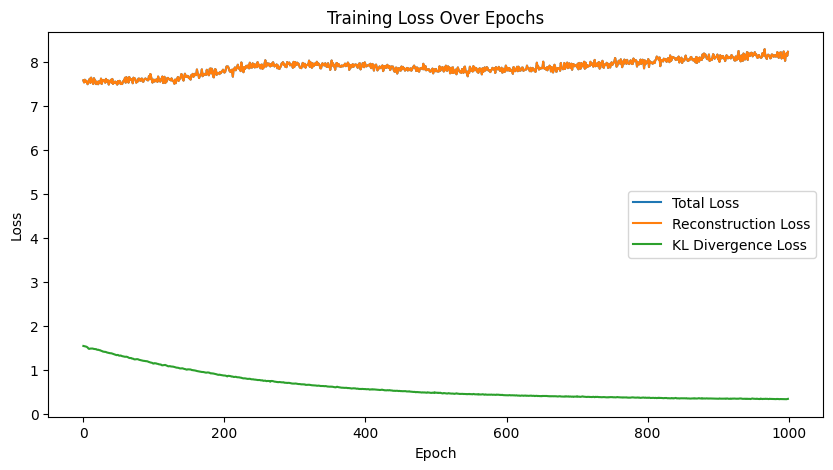

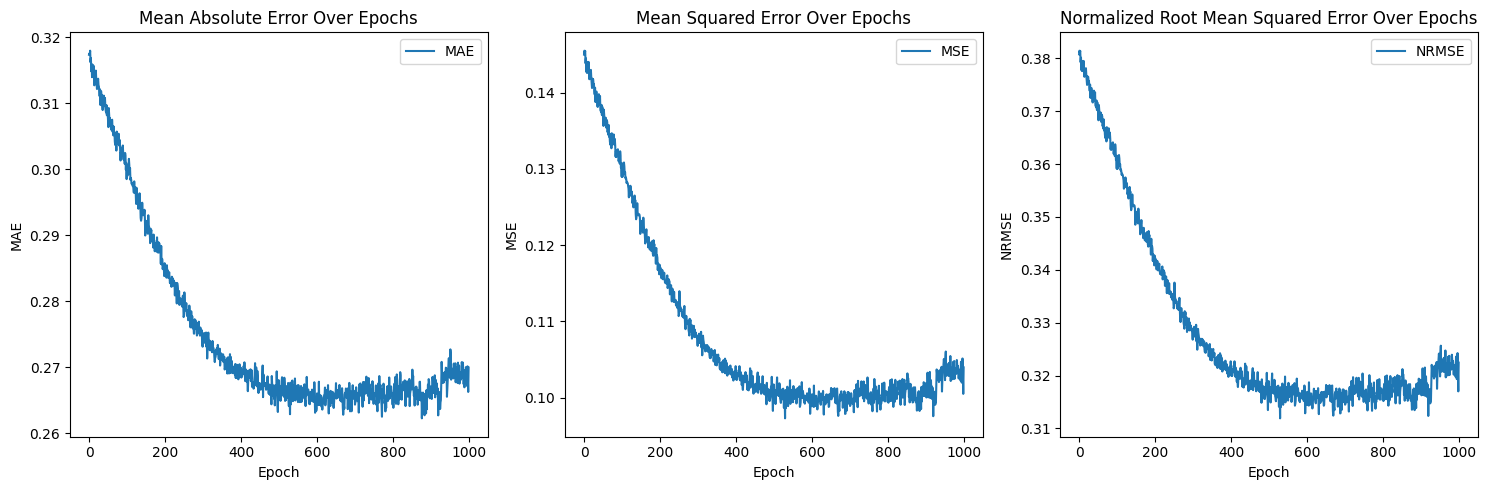

In [28]:
# Cell 4 (modified)
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        total_loss = reconstruction_loss + total_kl_loss
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, reconstruction_loss, kl_loss

batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(10000).batch(batch_size)

epochs = 1000
early_stopping_patience = 1000
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0

total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
mae_history = []
mse_history = []
nrmse_history = []

for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            total_loss_batch, reconstruction_loss, kl_loss = train_step(vae, batch, optimizer)
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            pbar.update(1)
            pbar.set_postfix({'Total Loss': float(total_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    avg_total_loss = total_loss / num_batches
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    total_loss_history.append(avg_total_loss)
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate MAE, MSE, NRMSE
    augmented_data = vae.decode(tf.random.normal(shape=(combined_data.shape[0], latent_dim))).numpy()
    mae = mean_absolute_error(combined_data[:, :2], augmented_data[:, :2])
    mse = mean_squared_error(combined_data[:, :2], augmented_data[:, :2])
    rmse = np.sqrt(mse)
    nrmse = rmse / (combined_data[:, :2].max() - combined_data[:, :2].min())

    mae_history.append(mae)
    mse_history.append(mse)
    nrmse_history.append(nrmse)

    print(f"Epoch {epoch+1}: Total Loss = {avg_total_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"MAE = {mae:.6f}, MSE = {mse:.6f}, NRMSE = {nrmse:.6f}")

    if avg_total_loss < best_loss - min_delta:
        best_loss = avg_total_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Final output of metrics
print(f"Final MAE: {mae_history[-1]:.6f}")
print(f"Final MSE: {mse_history[-1]:.6f}")
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(total_loss_history, label='Total Loss')
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot MAE, MSE, and NRMSE history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(mae_history, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mse_history, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

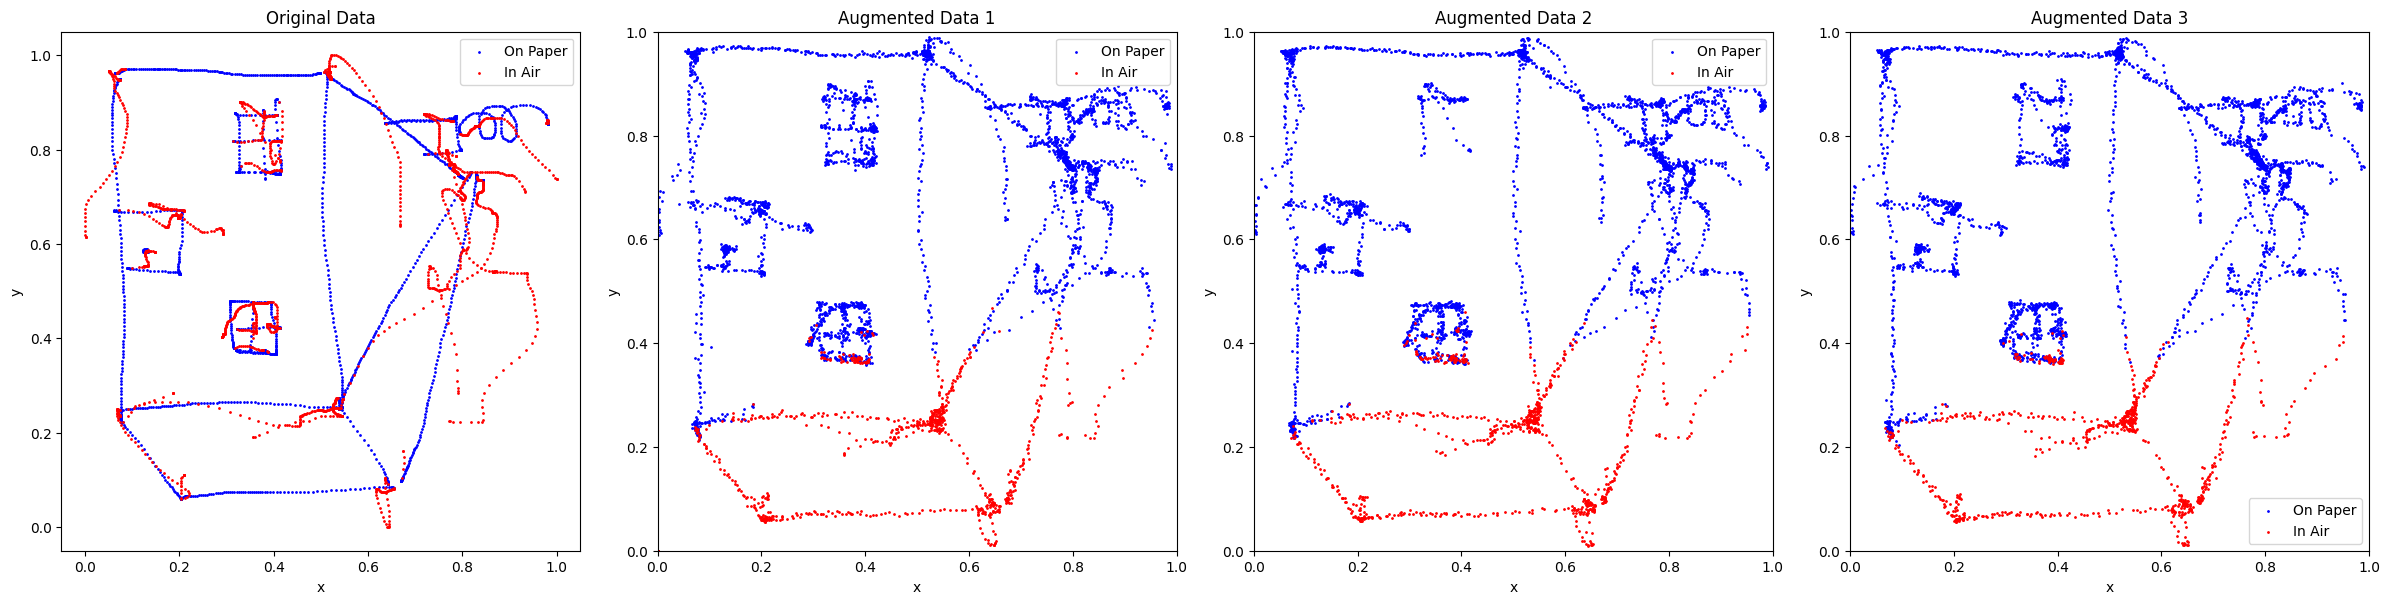

In [38]:
# Cell 5 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        mean, logvar = model.encode(tf.convert_to_tensor(combined_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar)
        augmented_data = model.decode(z).numpy()

        # Determine the number of data points for this augmented dataset
        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # Truncate or pad the augmented data to match the number of data points
        if num_points < augmented_data.shape[0]:
            augmented_datasets.append(augmented_data[:num_points])
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_datasets.append(np.vstack([augmented_data, padding]))

    return augmented_datasets

num_augmented_files = 3
augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points)

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6*(num_augmented_files + 1), 6))
original_on_paper = combined_data[combined_data[:, 2] == 1]
original_in_air = combined_data[combined_data[:, 2] == 0]
axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
axs[0].set_title('Original Data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
axs[0].legend()

# Set consistent axis limits for square aspect ratio
x_min, x_max = combined_data[:, 0].min(), combined_data[:, 0].max()
y_min, y_max = combined_data[:, 1].min(), combined_data[:, 1].max()

for i, augmented_data in enumerate(augmented_datasets):
    augmented_on_paper = augmented_data[augmented_data[:, 2] == 1]
    augmented_in_air = augmented_data[augmented_data[:, 2] == 0]
    axs[i+1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i+1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i+1].set_title(f'Augmented Data {i+1}')
    axs[i+1].set_xlabel('x')
    axs[i+1].set_ylabel('y')
    axs[i+1].set_aspect('equal')
    axs[i+1].set_xlim(x_min, x_max)
    axs[i+1].set_ylim(y_min, y_max)
    axs[i+1].legend()

plt.tight_layout()
plt.show()


In [39]:
# Updated function for downloading augmented data
def download_augmented_data(augmented_datasets, scalers, directory='augmented_data'):
    # Ensure the output directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Iterate over augmented datasets and corresponding scalers
    for i, (augmented_data, scaler) in enumerate(zip(augmented_datasets, scalers)):
        # Inverse transform the x and y coordinates
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :2]),  # Inverse scale x, y
            augmented_data[:, 2]  # Keep pen_status unchanged
        ))
        
        # # Round coordinates and ensure pen_status is binary
        # augmented_data_original_scale[:, :2] = np.round(augmented_data_original_scale[:, :2])
        # augmented_data_original_scale[:, 2] = np.round(augmented_data_original_scale[:, 2]).astype(int)
        
        # Save each augmented dataset to a CSV file
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

# Call the updated function with your augmented datasets
download_augmented_data(augmented_datasets, scalers[:len(augmented_datasets)])


Saved augmented_data\augmented_data_1.csv
